# STOFS Event-based Skill Assessment 
Here we are reading, subsetting and visualizing the forecast and nowcast data from STOFS-2D-Global and STOFS-3D-Atl data. We also read and plot reported water levels at CO-OPS stations. 

In [148]:
import dask
import geoviews as gv
import holoviews as hv
import numcodecs
import numpy as np
import pandas as pd
import geopandas as gpd
from cartopy.feature import NaturalEarthFeature
from matplotlib import pyplot
from shapely.geometry import Polygon

import shapely
import xarray as xr
import matplotlib.pyplot as plt
import s3fs  # Importing the s3fs library for accessing S3 buckets
import time  # Importing the time library for recording execution time
import shapely  # Importing shapely for geometric operations 
import thalassa  # Importing thalassa library for STOFS data analysis
from thalassa import api  # Importing thalassa API for data handling
from thalassa import normalization
from thalassa import utils
from holoviews import opts as hvopts
from holoviews import streams
from holoviews.streams import PointerXY
from holoviews.streams import Tap
import bokeh.plotting as bp
from datetime import datetime, timedelta, timezone
import searvey
from searvey.coops import get_coops_stations
from searvey._coops_api import fetch_coops_station
import tempfile
import pygrib
import math
from typing import List
from stormevents.nhc import nhc_storms, VortexTrack
from stormevents import StormEvent

# Input Parameters for Event Analysis


- **bucket_name_2d**: Name of the S3 bucket storing STOFS-2d-global data.
- **bucket_name_3d**: Name of the S3 bucket storing STOFS-3d-Atl data.
- **date_range**: Date range in YYYYMMDD format for analysis.
- **cycles_2d**: List of cycle times (in HH format, e.g., 00, 06, 12, 18) for STOFS-2d-Global forecasts.
- **Hours_before_landfall**: Number of hours before landfall for analysis.
- **Region**: Bounding box string defining the region of interest (min_lon, max_lon, min_lat, max_lat).
- **Event_name**: Name of the storm for hurricane track data extraction and file naming.
- **STOFS_file_2d**: File from STOFS-2d-Global for water level skill assessment.
- **STOFS_file_3d**: File from STOFS-3d-Atl for water level skill assessment.




In [149]:
# Info of STOFS data

bucket_name_2d   = 'noaa-gestofs-pds'
bucket_name_3d  = 'noaa-nos-stofs3d-pds'
date_range         = ['20240910','20240712']  
landfall_time_step = 145 # hours after start date from the date range input
cycles_2d        = ['00', '06', '12', '18']  
Hours_before_landfall = 48 # For reading Forecast data
Region       = 'NaN'  # select 'NaN' if you want to use region based on storm track or use (longitude_min, longitude_max, latitude_min, latitude_max) e.g. (-96, -94, 28, 30) 
Event_name = 'Hurricane Milton'
storm_name = 'milton'
storm_year = 2024
advisory = 'BEST' #'OFCL' for latest forecast and change it to 'BEST' if best track is available 
STOFS_file_2d   = 'points.cwl'
STOFS_file_3d   = 'points.cwl'
STOFS_file_2d_noanomaly = 'points.cwl.noanomaly'



## Hurricane Track Visualization: Optional, Skip if Storm Track Data is Not Needed


In [150]:
# Load storm and obtain isobars from stormevent  
storm = StormEvent(storm_name, storm_year)

#By default, retrieves data from the BEST track file deck (b). You can specify that you want the ADVISORY (a) or FIXED (f) file decks with the file_deck parameter.
#storm_track = storm.track() #storm.track(file_deck='a')
if advisory=='BEST':
    storm_track = storm.track()
else:    
    storm_track = storm.track(file_deck='a')
#storm_track.data[storm_track.data['advisory']=='BEST']

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/stormevents/nhc/track.py:1137: RuntimeWarning:

invalid value encountered in divide

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/stormevents/nhc/track.py:1137: RuntimeWarning:

invalid value encountered in divide



In [151]:
def get_storm_track_date(storm_track, advisory):
    if advisory == 'BEST':

      for idx in storm_track.linestrings[advisory]:
          track_date = idx
    else:
      for idx in storm_track.wind_swaths(wind_speed=64)[advisory]:
        track_date = idx
    return track_date

In [152]:
# get start and end date of storm
#track_date = get_storm_track_date(storm_best_track, 'BEST')
track_date = get_storm_track_date(storm_track, advisory)
storm_start_date = storm_track.start_date.strftime('%Y%m%d')
storm_end_date = storm_track.end_date.strftime('%Y%m%d') 
date_range = (storm_start_date, storm_end_date)
date_range

('20241004', '20241010')

In [153]:
gdf_countries = gpd.GeoSeries(NaturalEarthFeature(category='physical', scale='10m', name='land').geometries(), crs=4326)
gdf_countries

0     MULTIPOLYGON (((-0.00029 -71.49903, 0.01555 -7...
1     MULTIPOLYGON (((166.13697 -50.86435, 166.20525...
2     MULTIPOLYGON (((-78.78897 -33.60906, -78.78038...
3     MULTIPOLYGON (((163.98512 -20.04762, 163.98609...
4     MULTIPOLYGON (((134.70737 -6.58904, 134.72006 ...
5     MULTIPOLYGON (((-80.05989 -2.66277, -80.01452 ...
6     MULTIPOLYGON (((81.87599 7.09195, 81.87843 7.0...
7     MULTIPOLYGON (((55.01800 24.97651, 55.01580 24...
8     MULTIPOLYGON (((134.68979 33.82807, 134.72203 ...
9     MULTIPOLYGON (((14.76303 68.49486, 14.71746 68...
10    POLYGON ((-0.00479 -0.00439, -0.00479 0.00482,...
dtype: geometry

In [154]:
geometries = list(NaturalEarthFeature(category='physical', scale='50m', name='land').geometries())
land_gdf = gpd.GeoDataFrame(geometry=geometries, crs='EPSG:4326')
land_gdf

geometry
0     POLYGON ((179.99922 -16.16855, 179.84824 -16.3...
1     POLYGON ((177.23418 -17.14707, 177.18281 -17.1...
2     POLYGON ((127.37266 0.79131, 127.33838 0.75845...
3     POLYGON ((-81.33481 24.65049, -81.36479 24.629...
4     POLYGON ((-80.82939 24.80366, -80.84834 24.803...
...                                                 ...
1415  POLYGON ((-166.10986 66.22744, -166.14863 66.2...
1416  POLYGON ((-86.71401 21.23931, -86.69629 21.191...
1417  POLYGON ((54.46543 24.44277, 54.45664 24.42334...
1418  POLYGON ((-81.78384 24.54458, -81.80923 24.542...
1419  POLYGON ((124.74453 37.98062, 124.75547 37.969...

[1420 rows x 1 columns]

In [155]:
#gpd.sjoin(storm_track.data[storm_track.data['advisory']=='BEST'], land_gdf, how='inner')


In [156]:
def plot_isobar_domains(storm_track, track_date, gdf_countries):
    figure, axis = plt.subplots(1, 1)
    figure.set_size_inches(12, 12 / 1.618)
    
    # track_date = get_storm_track_date(storm_track, 'BEST')

    axis.plot(*storm_track.wind_swaths(wind_speed=34)[advisory][track_date].exterior.xy, 
              c='limegreen', label='34 kt')
    axis.plot(*storm_track.wind_swaths(wind_speed=50)[advisory][track_date].exterior.xy, 
              c='blue', label='50 kt')
    axis.plot(*storm_track.wind_swaths(wind_speed=64)[advisory][track_date].exterior.xy, 
              c='red', label='64 kt')
    axis.plot(*storm_track.linestrings[advisory][track_date].xy, 
              c='black',label='track')
    
    xlim = axis.get_xlim()
    ylim = axis.get_ylim()
    
    gdf_countries.plot(color='lightgrey', ax=axis, zorder=-1)
    
    axis.set_xlim(xlim)
    axis.set_ylim(ylim)
    axis.legend()
    axis.set_title(f'{storm_track.name}_{storm_track.year}  track windswath')
    figure.savefig(f'{storm_track.name}_{storm_track.year}_track_windswath.png')

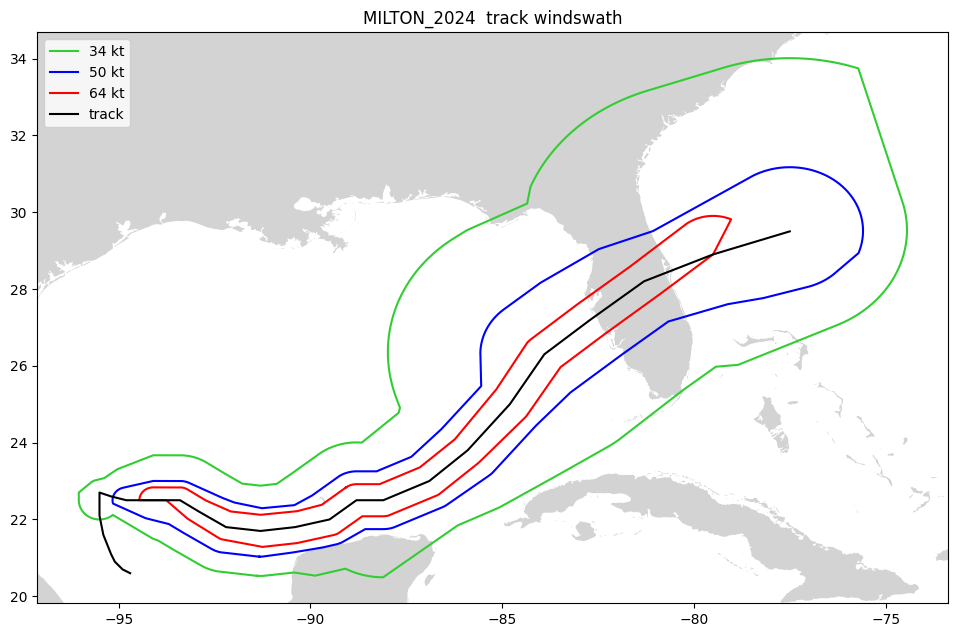

In [157]:
plot_isobar_domains(storm_track, track_date, gdf_countries)


# Read STOFS-2d-Global Nowcast Data on the Fly

In [158]:
#STOFS.py functions
def read_STOFS_from_s3(bucket_name, key):
    """
    Function to read a STOFS station files from an S3 bucket.
    
    Parameters:
    - bucket_name: Name of the S3 bucket
    - key: Key/path to the NetCDF file in the bucket
    
    Returns:
    - ds: xarray Dataset containing the NetCDF data
    """
    s3 = s3fs.S3FileSystem(anon=True)
    url = f"s3://{bucket_name}/{key}"
    ds = xr.open_dataset(s3.open(url, 'rb'))
    return ds


def get_station_nowcast_data(filename, modelname, directoryname, bucketname, daterange, steps, cycles):
    """
    Function to read STOFS Nowcast data from a station file on an S3 bucket.
    
    Parameters:
    - filename (str): The base filename for STOFS data
    - modelname (str): The STOFS model name 
    - directoryname (str): Optional directory name in the S3 bucket
    - bucketname (str): The name of the S3 bucket
    - daterange (list of two str): Start and end dates in 'YYYYMMDD' format
    - steps (int): Number of steps to slice as the nowcast period in each STOFS file
    - cycles (list of str): List of cycles (e.g., ['00', '12'])
    
    Returns:
    - xarray.Dataset: Dataset containing the STOFS Nowcast data
    """

    # Parse the start and end dates from the date range
    start_date = datetime.strptime(daterange[0], '%Y%m%d')
    end_date = datetime.strptime(daterange[1], '%Y%m%d') + timedelta(days=1)  # Include the last day
    
    # Generate a list of dates in the specified range
    dates = []
    current_date = start_date
    while current_date <= end_date:
        dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYYMMDD
        current_date += timedelta(days=1)

    nowcast_all_list = []
    
    for date in dates:
        for cycle in cycles:
            base_key = f'{modelname}.{date}'
            dataname = f't{cycle}z.{filename}.nc'
            if directoryname:
                key = f'{directoryname}/{base_key}/{modelname}.{dataname}'
            else:
                key = f'{base_key}/{modelname}.{dataname}'
                
            try:
                dataset = read_STOFS_from_s3(bucketname, key)

                # Check if dataset exists and has data
                if dataset is not None:
                    nowcast = dataset.isel(time=slice(0, steps))  # First 'steps' time steps (nowcast data)
                    nowcast_all_list.append(nowcast)
            except Exception as e:
                print(f'Error reading file {key} from S3: {str(e)}')

    # Concatenate all nowcast data and filter by date range
    nowcast_all_out_of_range = xr.concat(nowcast_all_list, dim='time')
    nowcast_all = nowcast_all_out_of_range.sel(time=slice(start_date, end_date))  # Filtered dataset

    return nowcast_all


def get_station_data(filename, modelname, directoryname, bucketname, date, cycle):
    """
    Function to read STOFS data for a particular date and cycle from a station file on an S3 bucket.
    
    Parameters:
    - filename (str): The base filename for STOFS data
    - modelname (str): The STOFS model name 
    - directoryname (str): Optional directory name in the S3 bucket
    - bucketname (str): The name of the S3 bucket
    - date (str): date in 'YYYYMMDD' format
    - cycle (str): cycle of the data (e.g.'12')
    
    Returns:
    - xarray.Dataset: Dataset containing the STOFS nowcast+forecast data from one cycle
    """
    

    base_key = f'{modelname}.{date}'
    dataname = f't{cycle}z.{filename}.nc'
    if directoryname:
       key = f'{directoryname}/{base_key}/{modelname}.{dataname}'
    else:
       key = f'{base_key}/{modelname}.{dataname}'
    try:
       dataset = read_STOFS_from_s3(bucketname, key)
    except Exception as e:
                print(f'Error reading file {key} from S3: {str(e)}')
    return dataset

In [159]:
# Read STOFS-2d-global
filename = 'points.cwl'
modelname = 'stofs_2d_glo'
directoryname = ''
bucketname = 'noaa-gestofs-pds'
steps = 60
cycles = ['00','06','12','18']

nowcast_2d_all = get_station_nowcast_data(filename, modelname, directoryname, bucketname,date_range, steps, cycles)

nowcast_2d_all

<xarray.Dataset> Size: 210MB
Dimensions:       (time: 1681, station: 1688)
Coordinates:
  * time          (time) datetime64[ns] 13kB 2024-10-04 ... 2024-10-11
Dimensions without coordinates: station
Data variables:
    station_name  (time, station) |S50 142MB b'PSBM1 SOUS41 8410140 ME Eastpo...
    x             (time, station) float64 23MB -66.98 -67.2 ... -51.01 -25.5
    y             (time, station) float64 23MB 44.9 44.65 44.39 ... 58.96 58.96
    zeta          (time, station) float64 23MB -1.675 -1.11 ... -0.1685 0.1544
Attributes: (12/50)
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            noaa.stofs.2d.glo.v2.1.0r1.v55.12
    git_hash:           23947fbd9683d0ef48f12e6ce62d45d18bc27ff3
    grid_type:          Triangular
    description:        2024100400 :-6 hr nowcast and +180 hr forecast ! 32 C...
    ...                 ...
    sfea0:              45.0
    cf:                 0.0005
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               0

In [160]:
filename = 'points.cwl.noanomaly'
modelname = 'stofs_2d_glo'
directoryname = ''
bucketname = 'noaa-gestofs-pds'
steps = 60
cycles = ['00','06','12','18']

nowcast_2d_noanomaly_all = get_station_nowcast_data(filename, modelname, directoryname, bucketname,date_range, steps, cycles)
nowcast_2d_noanomaly_all

<xarray.Dataset> Size: 210MB
Dimensions:       (time: 1681, station: 1688)
Coordinates:
  * time          (time) datetime64[ns] 13kB 2024-10-04 ... 2024-10-11
Dimensions without coordinates: station
Data variables:
    station_name  (time, station) |S50 142MB b'PSBM1 SOUS41 8410140 ME Eastpo...
    x             (time, station) float64 23MB -66.98 -67.2 ... -51.01 -25.5
    y             (time, station) float64 23MB 44.9 44.65 44.39 ... 58.96 58.96
    zeta          (time, station) float64 23MB -1.665 -1.26 ... -0.1685 0.1544
Attributes: (12/51)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            noaa.stofs.2d.glo.v2.1.0r1.v55.12
    git_hash:           23947fbd9683d0ef48f12e6ce62d45d18bc27ff3
    grid_type:          Triangular
    ...                 ...
    sfea0:              45.0
    cf:                 0.0005
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               0

# Read STOFS-3d-Atlantic Nowcast Data on the Fly

In [161]:
# Read STOFS-3d-Atlantic

filename = 'points.cwl'
modelname = 'stofs_3d_atl'
directoryname = 'STOFS-3D-Atl'
bucketname = 'noaa-nos-stofs3d-pds'
steps = 240
cycles = ['12']

nowcast_3d_all = get_station_nowcast_data(filename, modelname, directoryname, bucketname,date_range, steps, cycles)
nowcast_3d_all   # a xarray data set containing all the nowcast data


<xarray.Dataset> Size: 19MB
Dimensions:       (time: 1681, station: 108)
Coordinates:
  * time          (time) datetime64[ns] 13kB 2024-10-04 ... 2024-10-11
Dimensions without coordinates: station
Data variables:
    zeta          (time, station) float64 1MB -2.175 -1.453 ... 0.1239 0.4862
    station_name  (time, station) |S50 9MB b'PSBM1 SOUS41 8410140 ME Eastport...
    x             (time, station) float64 1MB 44.9 44.66 43.66 ... 26.06 27.83
    y             (time, station) float64 1MB -66.98 -67.2 ... -97.22 -97.49
    u             (time, station) float64 1MB -0.5799 -0.06305 ... -999.0
    v             (time, station) float64 1MB -0.4101 0.05678 ... -999.0
    salinity      (time, station) float64 1MB 31.33 32.49 ... 26.14 -999.0
    temperature   (time, station) float64 1MB 11.77 12.43 ... 26.75 -999.0
Attributes:
    title:       SCHISM Model output
    source:      SCHISM model output version v10
    references:  http://ccrm.vims.edu/schismweb/
    history:     Fri Oct  4 18:04:16 2024: ncap2 -O -F -S /lfs/h1/ops/prod/pa...
    NCO:         netCDF Operators version 4.9.7 (Homepage = http://nco.sf.net...

# Find all the CO-OPs stations in the region using searvey

In [162]:
if Region == 'NaN':
   bbox = storm_track.wind_swaths(wind_speed=50)[advisory][track_date]
   buffered_bbox = bbox.buffer(0.5)

else:
   bbox = shapely.box(Region[0], Region[2], Region[1], Region[3])
station_ds_all= searvey.coops.coops_product_within_region('water_level', region=buffered_bbox, start_date=datetime.fromtimestamp(nowcast_2d_all.time.values[0].astype(int) * 1e-9)
, end_date=datetime.fromtimestamp(nowcast_2d_all.time.values[-1].astype(int) * 1e-9))
station_ds_all


/tmp/ipykernel_20039/1273869425.py:7: DeprecationWarning:

Call to deprecated function (or staticmethod) coops_product_within_region. (This function is deprecated and will be removed in the future. Replace it with `fetch_coops_station`.) -- Deprecated since version 0.4.0.



<xarray.Dataset> Size: 377kB
Dimensions:  (t: 1681, nos_id: 9)
Coordinates:
  * t        (t) datetime64[ns] 13kB 2024-10-04 ... 2024-10-11
  * nos_id   (nos_id) object 72B '8726384' '8725520' ... '8725114' '8726724'
    nws_id   (nos_id) <U5 180B 'PMAF1' 'FMRF1' 'TRDF1' ... 'NBNF1' 'CWBF1'
    x        (nos_id) float64 72B -82.56 -81.87 -80.59 ... -83.03 -81.79 -82.83
    y        (nos_id) float64 72B 27.64 26.65 28.42 27.86 ... 29.14 26.14 27.98
Data variables:
    v        (nos_id, t) float32 61kB 0.622 0.617 0.614 ... 1.163 1.174 1.178
    s        (nos_id, t) float32 61kB 0.009 0.008 0.008 ... 0.071 0.075 0.054
    f        (nos_id, t) object 121kB '0,0,0,0' '1,0,0,0' ... '1,0,0,0'
    q        (nos_id, t) object 121kB 'p' 'p' 'p' 'p' 'p' ... 'p' 'p' 'p' 'p'

In [163]:

all_stations = get_coops_stations(metadata_source='main', region=buffered_bbox)
#wind_stations = all_stations[((all_stations.status == 'active') & (all_stations.station_type == 'met')) | (all_stations.status == 'active') & (all_stations.station_type == 'waterlevelsandmet') ]
waterlevel_stations = all_stations[((all_stations.status == 'active') & (all_stations.station_type == 'waterlevels'))]

waterlevel_stations = waterlevel_stations.sort_values(by ='nos_id')
waterlevel_stations = waterlevel_stations.reset_index()
waterlevel_stations


nos_id nws_id station_type                          name state        lon  \
0  8721604  TRDF1  waterlevels  Trident Pier, Port Canaveral    FL -80.593056   
1  8725114  NBNF1  waterlevels             Naples Bay, North    FL -81.788300   
2  8725520  FMRF1  waterlevels                    Fort Myers    FL -81.871002   
3  8726384  PMAF1  waterlevels                  Port Manatee    FL -82.562103   
4  8726520  SAPF1  waterlevels                St. Petersburg    FL -82.626900   
5  8726607  OPTF1  waterlevels                Old Port Tampa    FL -82.552803   
6  8726674  EBEF1  waterlevels                      East Bay    FL -82.421387   
7  8726724  CWBF1  waterlevels              Clearwater Beach    FL -82.831665   
8  8727520  CKYF1  waterlevels                     Cedar Key    FL -83.031700   

         lat removed  status                    geometry  
0  28.415833     NaT  active  POINT (-80.59306 28.41583)  
1  26.136700     NaT  active  POINT (-81.78830 26.13670)  
2  26.648001     NaT  active  POINT (-81.87100 26.64800)  
3  27.638700     NaT  active  POINT (-82.56210 27.63870)  
4  27.760599     NaT  active  POINT (-82.62690 27.76060)  
5  27.857800     NaT  active  POINT (-82.55280 27.85780)  
6  27.923056     NaT  active  POINT (-82.42139 27.92306)  
7  27.978333     NaT  active  POINT (-82.83167 27.97833)  
8  29.135000     NaT  active  POINT (-83.03170 29.13500)

# Find CO-OPS station in STOFS-2D-Global station list

In [164]:
# Create an empty list to collect zeta values
zeta_values_list = []
nos_id_points = []
x_values = []
y_values = []
names = []


# Loop over stations and extract zeta if any search string is found in the station name

station_id = waterlevel_stations['nos_id'].values

for nos_id in station_id:
  
    for station_index in range(len(nowcast_2d_all.station)):
        station_name = nowcast_2d_all.station_name[0,station_index].item().decode('utf-8').strip()
        if (nos_id in station_name):
           zeta_values = nowcast_2d_all.zeta[:, station_index]  # Extract zeta values for the current station
           x = nowcast_2d_all.x[0, station_index]
           y = nowcast_2d_all.y[0, station_index]
           # Save the availilbe stations in the station list
           nos_id_points.append(nos_id)
           zeta_values_list.append(zeta_values)
           x_values.append(x.item())
           y_values.append(y.item())
           #names.append(station_name)
           names.append(waterlevel_stations.loc[waterlevel_stations['nos_id'] == nos_id, 'name'].values[0])

# Concatenate all zeta values into a single NumPy array
all_zeta_values = np.concatenate(zeta_values_list, axis=0)

all_zeta_values = np.reshape(all_zeta_values, (int(len(all_zeta_values)/len(nowcast_2d_all.time)),len(nowcast_2d_all.time)))

# Sample data
data = {
    'latitude': y_values,
    'longitude':x_values ,
    'Name': names,
    'id':  nos_id_points,
}

# Create a DataFrame
df_2d = pd.DataFrame(data)

df_2d

latitude  longitude                          Name       id
0  28.415670 -80.593719  Trident Pier, Port Canaveral  8721604
1  26.648001 -81.871002                    Fort Myers  8725520
2  27.638300 -82.562500                  Port Manatee  8726384
3  27.758301 -82.626801                St. Petersburg  8726520
4  27.857800 -82.552803                Old Port Tampa  8726607
5  27.977591 -82.832413              Clearwater Beach  8726724
6  29.133600 -83.030899                     Cedar Key  8727520

# Plot the stations for STOFS-2d-Global


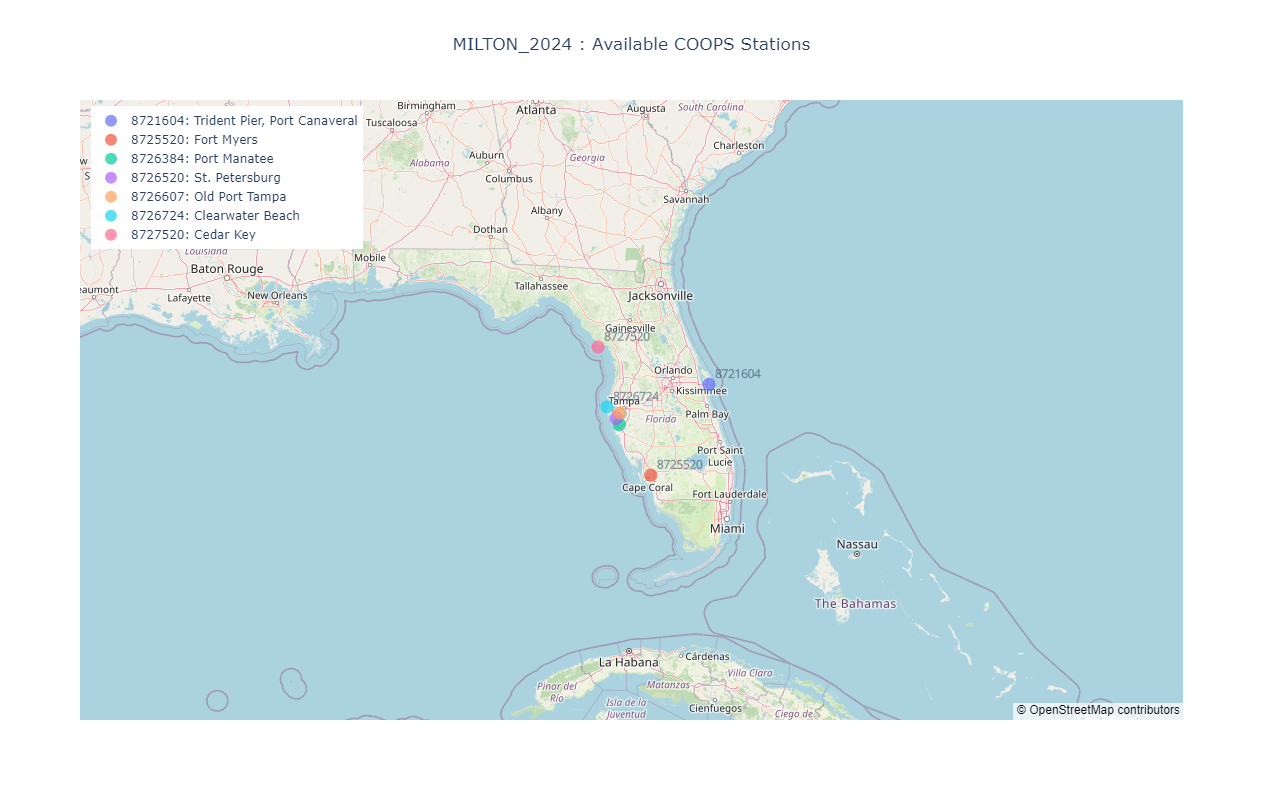

In [165]:
import plotly.express as px
import pandas as pd
import plotly.io as pio


# Create a new column in the DataFrame combining 'id' and 'Name' 
df_2d['id-name'] = df_2d['id'].astype(str) + ': ' + df_2d['Name']

# Create the scatter mapbox plot with red points
fig = px.scatter_mapbox(
    df_2d,
    lat='latitude',
    lon='longitude',
    center=dict(lat=df_2d['latitude'].mean(), lon=df_2d['longitude'].mean()),
    #color_discrete_sequence=['red'],  # Set the color of the points to red
    color = 'id-name',
    size=[1]*len(df_2d),  # Adjust the size of the markers if needed
    size_max = 10,
    text= 'id',
    hover_name='id',
    hover_data=['id', 'Name'],
    title= f'{storm_track.name}_{storm_track.year} : Available COOPS Stations',
    mapbox_style='open-street-map',  # Use OpenStreetMap for simplicity
    width=1000,  # Set the width of the figure
    height=800,  # Set the height of the figure
    zoom=5,  # Zoom level
)


fig.update_layout(
    
    title=dict(x=0.5),  # Center the title
    legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
)
)

fig.update_traces(textposition='top right')
fig.update_layout(legend=dict(title=None))



# Show the plot
fig.show()
fig.write_html("file.html")
#fig.write_image("fig2.png")



In [167]:
# Find CO-OPS station in STOFS-2D-Global noanomaly station list

# Create an empty list to collect zeta values
zeta_values_noanomaly_list = []
x_values = []
y_values = []


# Loop over stations and extract zeta if any search string is found in the station name

#station_id = np.sort(station_ds['nos_id'].values)

for nos_id in station_id:
  
    for station_index in range(len(nowcast_2d_all.station)):
        station_name = nowcast_2d_noanomaly_all.station_name[0,station_index].item().decode('utf-8').strip()
        if (nos_id in station_name):
           zeta_values = nowcast_2d_noanomaly_all.zeta[:, station_index]  # Extract zeta values for the current station
           # Save the availilbe stations in the station list
           zeta_values_noanomaly_list.append(zeta_values)
          
# Concatenate all zeta values into a single NumPy array
all_zeta_noanomaly_values = np.concatenate(zeta_values_noanomaly_list, axis=0)

all_zeta_noanomaly_values = np.reshape(all_zeta_noanomaly_values, (int(len(all_zeta_noanomaly_values)/len(nowcast_2d_noanomaly_all.time)),len(nowcast_2d_noanomaly_all.time)))


# Find CO-OPS station in STOFS-3D-Atlantic station list

In [168]:
# Create an empty list to collect zeta values
zeta_values_list_3d = []
nos_id_points_3d = []
x_values_3d = []
y_values_3d = []
names_3d = []

# Loop over stations and extract zeta if any search string is found in the station name

for nos_id in station_id:
    
     for station_index in range(len(nowcast_3d_all.station)):
        station_name = nowcast_3d_all.station_name[0,station_index].item().decode('utf-8').strip()  
        if (nos_id in station_name):
           zeta_values = nowcast_3d_all.zeta[:, station_index]  # Extract zeta values for the current station
           x = nowcast_3d_all.x[0, station_index]
           y = nowcast_3d_all.y[0, station_index]
           # Save the availilbe stations in the station list
           nos_id_points_3d.append(nos_id)
           zeta_values_list_3d.append(zeta_values)
           x_values_3d.append(x.item())
           y_values_3d.append(y.item())
           names_3d.append(waterlevel_stations.loc[waterlevel_stations['nos_id'] == nos_id, 'name'].values[0])
          
# Concatenate all zeta values into a single NumPy array
all_zeta_values_3d = np.concatenate(zeta_values_list_3d, axis=0)

all_zeta_values_3d = np.reshape(all_zeta_values_3d, ( int(len(all_zeta_values_3d)/len(nowcast_3d_all.time)),len(nowcast_3d_all.time)))
nos_id_points_3d , names_3d

# Sample data
data = {
    'latitude':  x_values_3d,
    'longitude': y_values_3d ,
    'Name': names_3d,
    'id':  nos_id_points_3d,
}

# Create a DataFrame
df_3d = pd.DataFrame(data)

df_3d


latitude  longitude                          Name       id
0 -80.593400  28.415700  Trident Pier, Port Canaveral  8721604
1  26.648006 -81.871006                    Fort Myers  8725520
2  27.638339 -82.562507                  Port Manatee  8726384
3  27.761117 -82.626951                St. Petersburg  8726520
4  27.857806 -82.552810                Old Port Tampa  8726607
5  27.978339 -82.831674              Clearwater Beach  8726724
6  29.135006 -83.031707                     Cedar Key  8727520

# Plot the stations for STOFS-3d-Atlantic

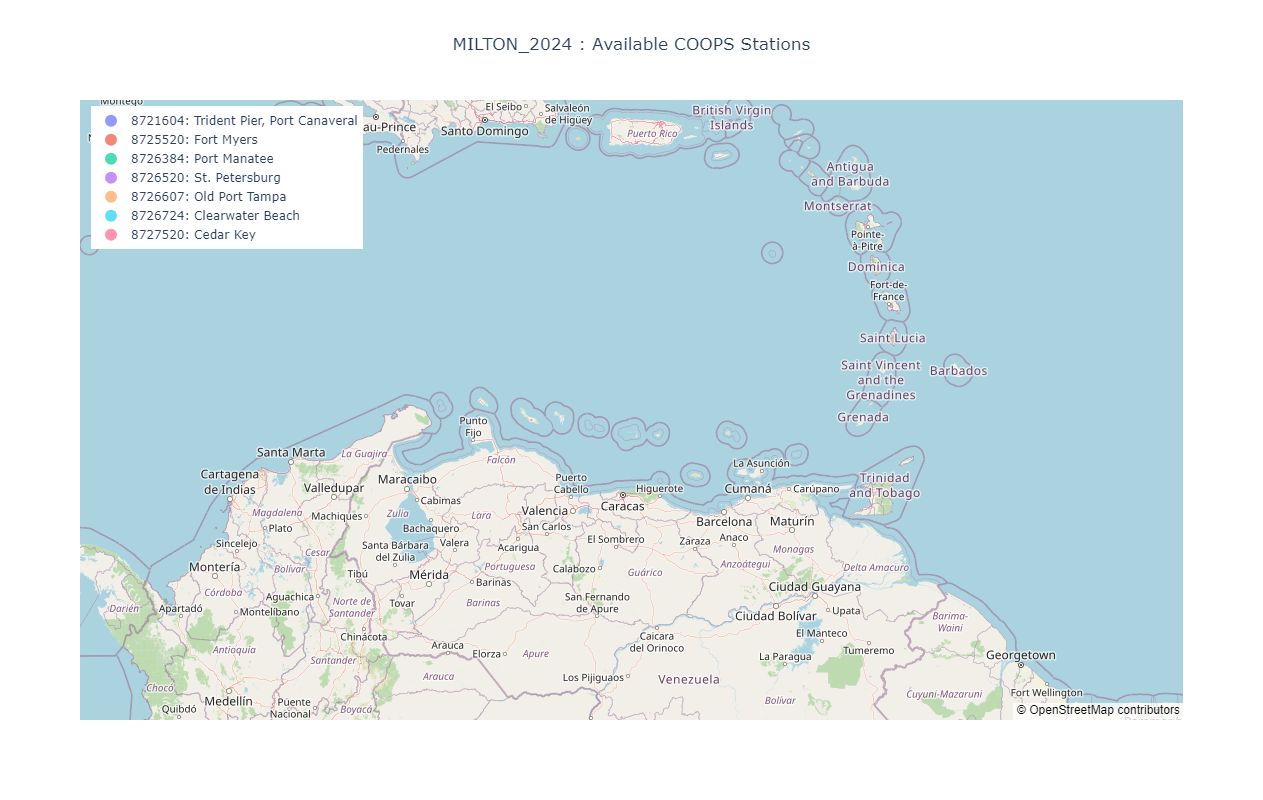

In [21]:

#Create a new column in the DataFrame combining 'id' and 'Name' 
df_3d['id-name'] = df_3d['id'].astype(str) + ': ' + df_3d['Name']



# Create the scatter mapbox plot with red points
fig = px.scatter_mapbox(
    df_3d,
    lat='latitude',
    lon='longitude',
    center=dict(lat=df_3d['latitude'].mean(), lon=df_3d['longitude'].mean()),
    #color_discrete_sequence=['red'],  # Set the color of the points to red
    color = 'id-name',
    size=[1]*len(df_3d),  # Adjust the size of the markers if needed
    size_max = 10,
    text= 'id',
    hover_name='id',
    hover_data=['id', 'Name'],
    title= f'{storm_track.name}_{storm_track.year} : Available COOPS Stations',
    mapbox_style='open-street-map',  # Use OpenStreetMap for simplicity
    width=1000,  # Set the width of the figure
    height=800,  # Set the height of the figure
    zoom=5,  # Zoom level
)



fig.update_layout(
    
    title=dict(x=0.5),  # Center the title
    legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
)
)

fig.update_traces(textposition='top right')
fig.update_layout(legend=dict(title=None))



# Show the plot
fig.show()
fig.write_html("file.html")
#fig.write_image("fig3.png")


# Read Observation data for STOFS-2D-Global

In [169]:
# Initialize an empty DataFrame to store the data
Observation = []

# Loop over each nos_id
for nos_id in nos_id_points:
   
       # Retrieve water level information for the specified date range
       station_df = fetch_coops_station(
       station_id=nos_id,
       start_date=datetime.fromtimestamp(nowcast_2d_all.time.values[0].astype(int) * 1e-9, tz=timezone.utc),
       end_date=datetime.fromtimestamp(nowcast_2d_all.time.values[-1].astype(int) * 1e-9, tz=timezone.utc),
       product='water_level',datum='MSL')
   
       # Add the data for the current station to the result DataFrame
       Observation.append(station_df['value'].values)


# Read Observation data for STOFS-3D-Atlantic

In [170]:

# Initialize an empty DataFrame to store the data
Observation_3d = []

# Loop over each nos_id
for nos_id in nos_id_points_3d:
   
       # Retrieve water level information for the specified date range
       station_df = fetch_coops_station(
       station_id=nos_id,
       start_date=datetime.fromtimestamp(nowcast_3d_all.time.values[0].astype(int) * 1e-9, tz=timezone.utc),
       end_date=datetime.fromtimestamp(nowcast_3d_all.time.values[-1].astype(int) * 1e-9, tz=timezone.utc),
       product='water_level',datum='NAVD')
      

       # Add the data for the current station to the result DataFrame
       Observation_3d.append(station_df['value'].values)



# Plot Nowcast Time series STOFS-2D-Global

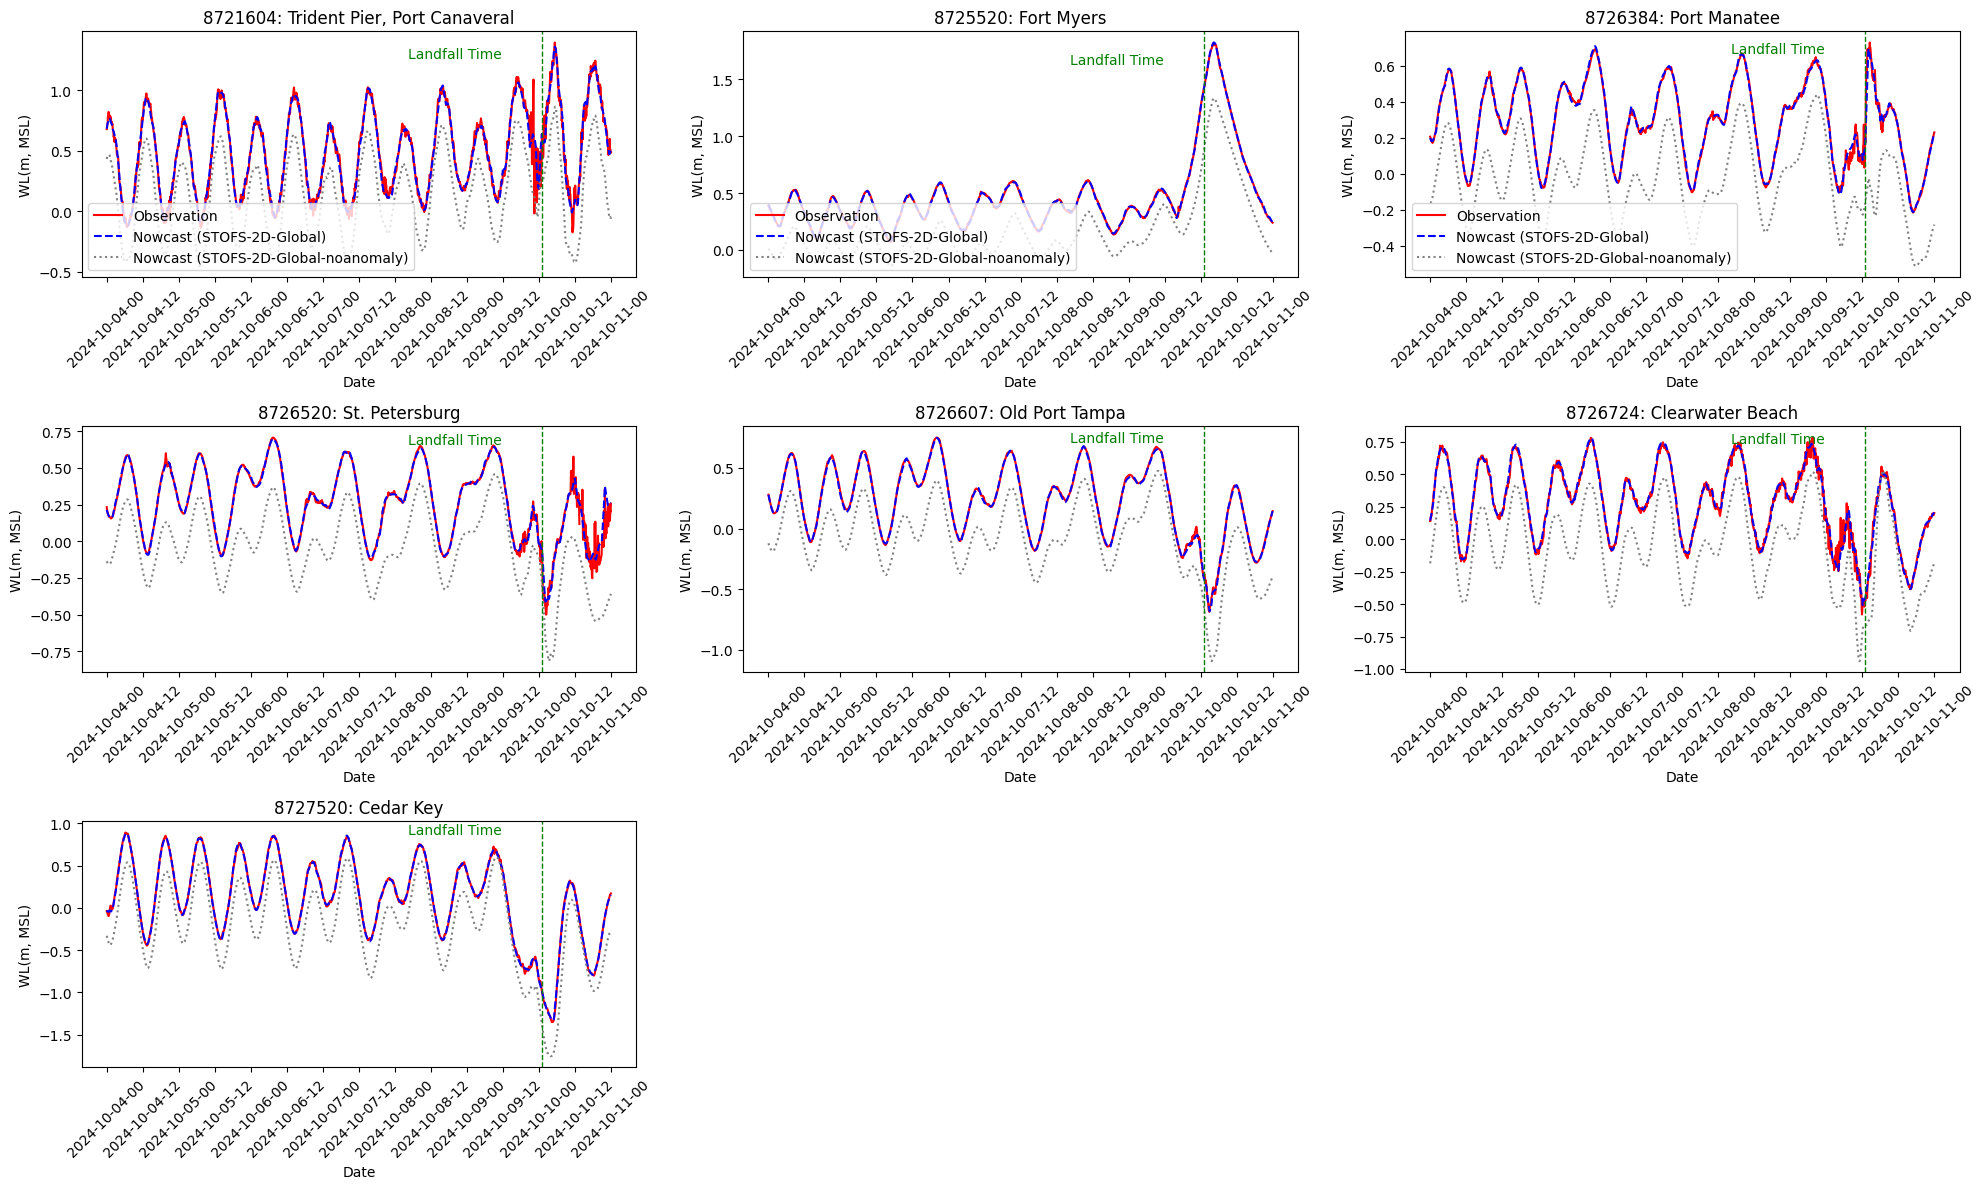

In [171]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta

def convert_to_datetime(time_step, date_range):
    start_date = datetime.strptime(date_range[0], '%Y%m%d')
    time_delta = timedelta(minutes=6)
    return start_date + time_step * time_delta

# Define the number of rows and columns for subplots (2 columns)
num_rows = 3
num_cols = 3

# Create a figure and axes array with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12))

index = 0
for row in range(num_rows):
    for col in range(num_cols):
        ax = axs[row, col]
      
        if index >= len(nos_id_points):
            # If there are fewer stations than subplots, turn off unused subplots
            axs[row, col].axis('off')
            break
    
        #ax.plot(all_zeta_para_values[index, :], label='Nowcast (STOFS-2D-Global-new)', color='blue', linestyle='dashed')
        ax.plot(Observation[index], label='Observation',color='red')

        ax.plot(all_zeta_values[index, :], linestyle='--', label='Nowcast (STOFS-2D-Global)', color='blue')
        ax.plot(all_zeta_noanomaly_values[index, :], label='Nowcast (STOFS-2D-Global-noanomaly)', color='gray', linestyle='dotted')

        ax.set_title(f'{nos_id_points[index]}: {names[index]}')
            
        ax.set_xlabel('Date')
            
        # Set x ticks and labels
        ax.set_xticks(range(0, len(all_zeta_values[index, :]), 120))
        time_steps = range(0, len(all_zeta_values[index, :]))
        time_labels = [convert_to_datetime(step, date_range) for step in time_steps]
        selected_dates = time_labels[::120]
        ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
            
            
        ax.axvline(x=landfall_time_step*10, color='green', linestyle='--', linewidth=1)
        ax.text(landfall_time_step*10*0.8, ax.get_ylim()[1]*0.85, 'Landfall Time', color='green', ha='center')
            
        ax.set_ylabel('WL(m, MSL)')
        if row == 0 :
            ax.legend(loc='lower left')
        
        index += 1
            
# Turn off any remaining unused subplots 
for i in range(index, num_rows * num_cols): 
    axs.flatten()[i].axis('off')
          
# Adjust layout
plt.tight_layout()
plt.savefig(f'nowcast_2d_{Event_name}')  # Save the figure
plt.show()

# Plot Nowcast Time series STOFS-3D-Atlantic

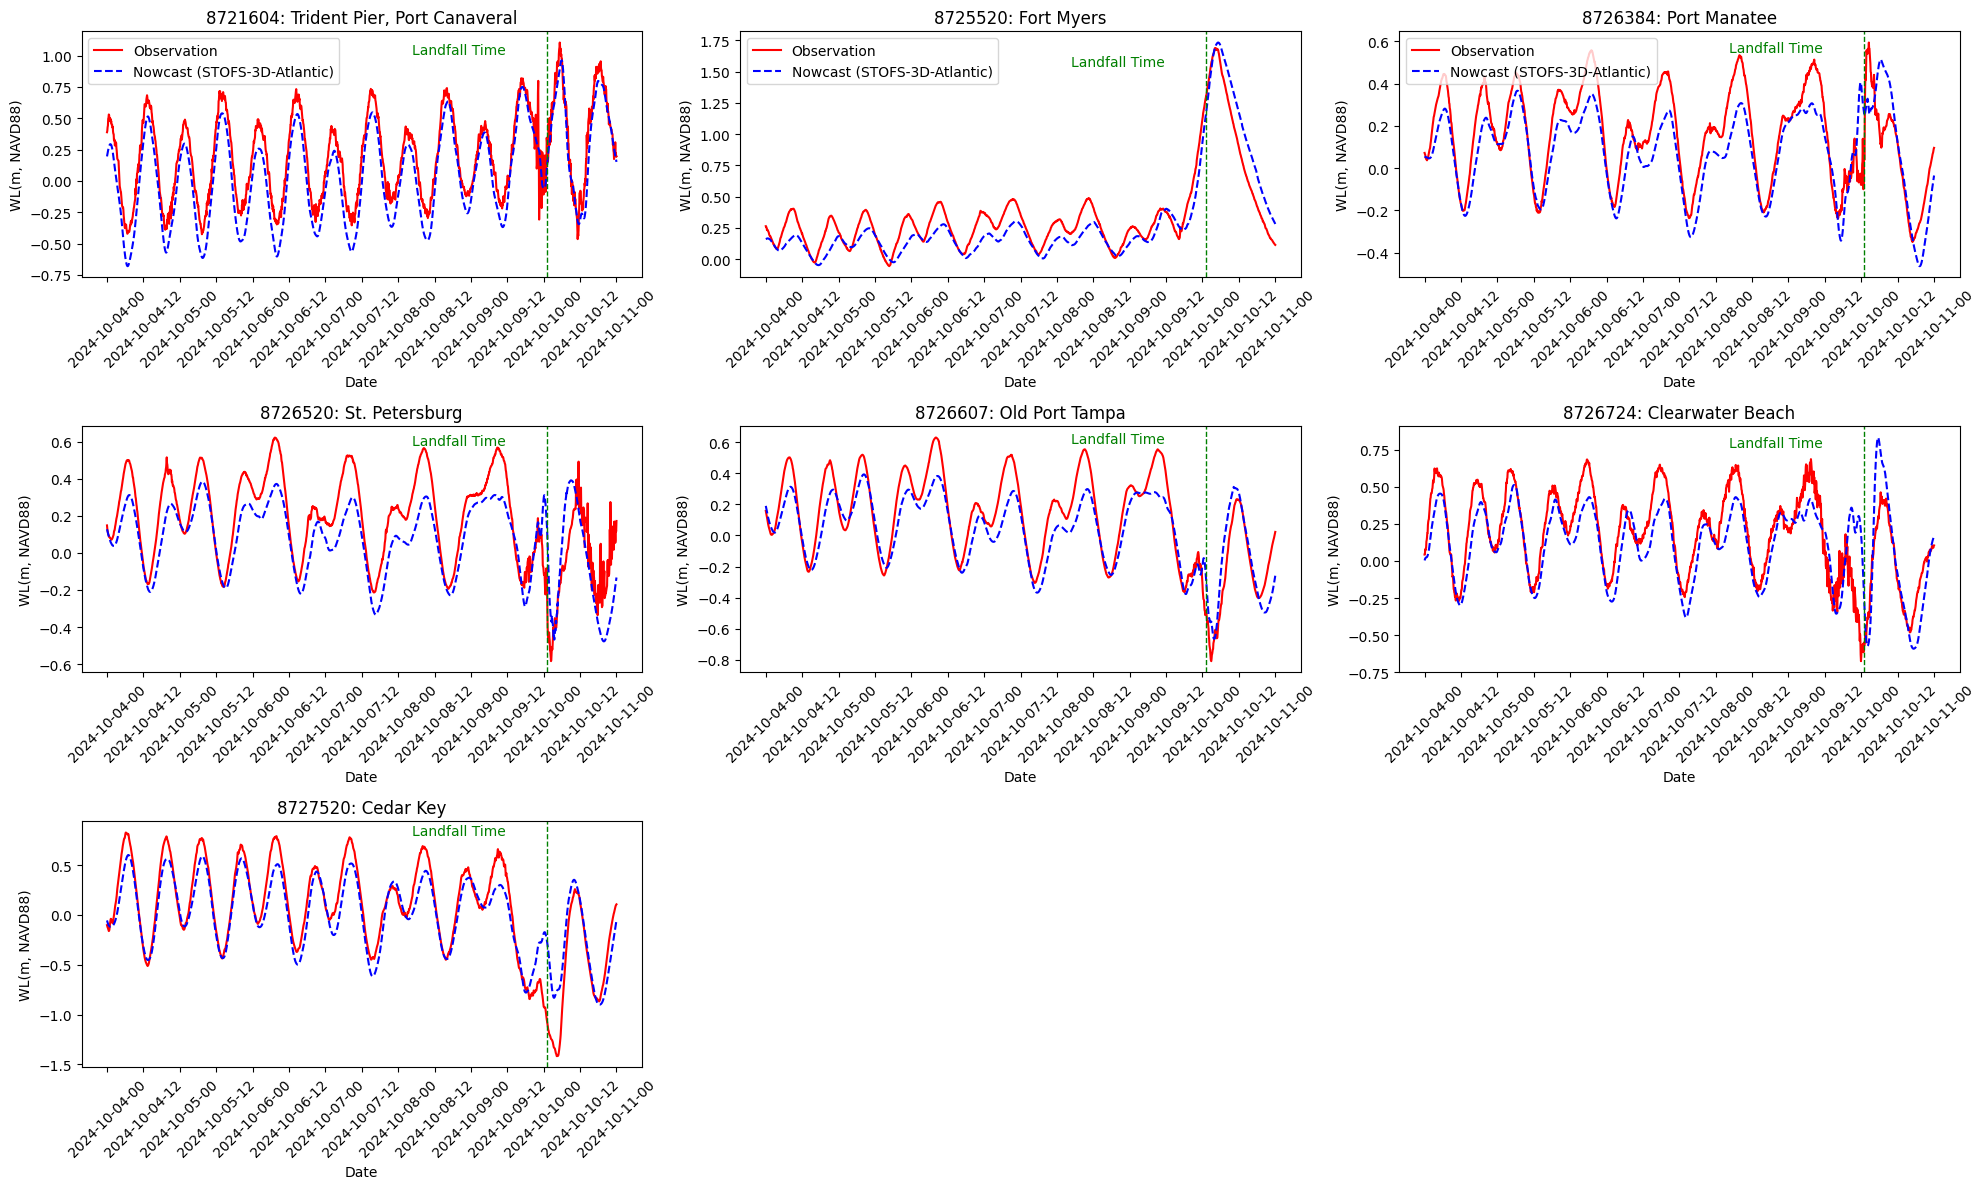

In [172]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta

def convert_to_datetime(time_step, date_range):
    start_date = datetime.strptime(date_range[0], '%Y%m%d')
    time_delta = timedelta(minutes=6)
    return start_date + time_step * time_delta

# Define the number of rows and columns for subplots (2 columns)
num_rows = 3
num_cols = 3

# Create a figure and axes array with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12))

index = 0
for row in range(num_rows):
    for col in range(num_cols):
        ax = axs[row, col]
        if index == len(nos_id_points_3d):
            # If there are fewer stations than subplots, turn off unused subplots
            ax.axis('off')
            continue
        
    
        #ax.plot(all_zeta_noanomaly_values[index, :], label='Nowcast (STOFS-2D-Global-noanomaly)', color='blue', linestyle='dotted')
        #ax.plot(all_zeta_para_values[index, :], label='Nowcast (STOFS-2D-Global-new)', color='blue', linestyle='dashed')
        
        ax.plot(Observation_3d[index], label='Observation', color='red')
        ax.plot(all_zeta_values_3d[index, :], label='Nowcast (STOFS-3D-Atlantic)', color='blue', linestyle='dashed')
        ax.set_title(f'{nos_id_points_3d[index]}: {names_3d[index]}')
    
        ax.set_xlabel('Date')
            
        # Set x ticks and labels
        ax.set_xticks(range(0, len(all_zeta_values_3d[index, :]), 120))
        time_steps = range(0, len(all_zeta_values_3d[index, :]))
        time_labels = [convert_to_datetime(step, date_range) for step in time_steps]
        selected_dates = time_labels[::120]
        ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
                        
        ax.axvline(x=landfall_time_step*10, color='green', linestyle='--', linewidth=1)
        ax.text(landfall_time_step*0.8*10, ax.get_ylim()[1]*0.85, 'Landfall Time', color='green', ha='center')
            
        ax.set_ylabel('WL(m, NAVD88)')
        if row == 0:
            ax.legend(loc='upper left')
        
        index += 1

# Turn off any remaining unused subplots 
for i in range(index, num_rows * num_cols): 
    axs.flatten()[i].axis('off')

# Adjust layout
plt.tight_layout()
plt.savefig(f'nowcast_3d_{Event_name}')  # Save the figure
plt.show()

# Plot Nowcast Time series STOFS-3D-Atlantic and 2D Global

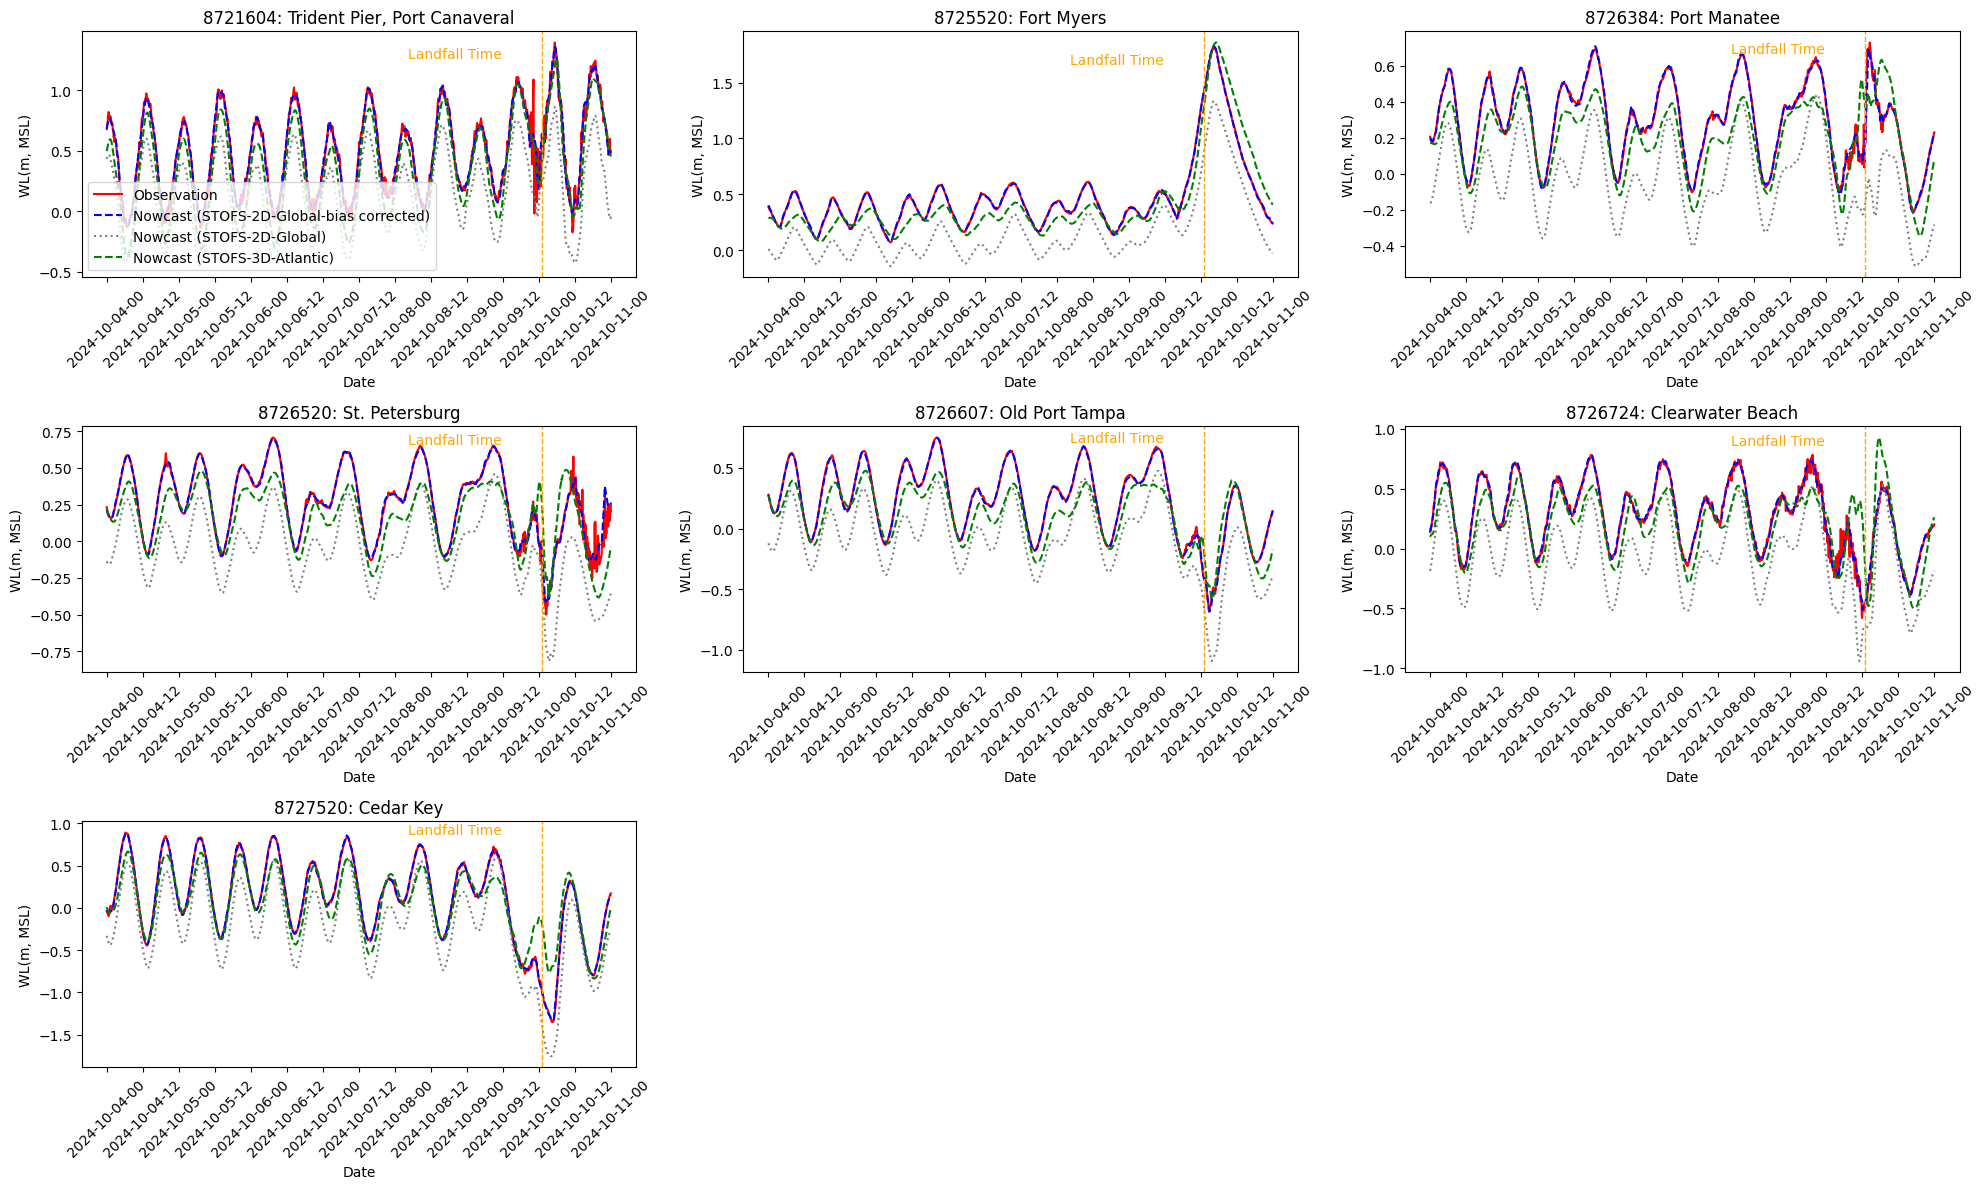

In [173]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta


# From VDatum Package
Conversion_values = [0.299, 0.125, 0.117,0.095,0.084,0.094,0.066]





def convert_to_datetime(time_step, date_range):
    start_date = datetime.strptime(date_range[0], '%Y%m%d')
    time_delta = timedelta(minutes=6)
    return start_date + time_step * time_delta

# Define the number of rows and columns for subplots (2 columns)
num_rows = 3
num_cols = 3

# Create a figure and axes array with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12))

index = 0
for row in range(num_rows):
    for col in range(num_cols):
        ax = axs[row, col]
      
        if index >= len(nos_id_points):
            # If there are fewer stations than subplots, turn off unused subplots
            axs[row, col].axis('off')
            break
    
        #ax.plot(all_zeta_para_values[index, :], label='Nowcast (STOFS-2D-Global-new)', color='blue', linestyle='dashed')
        ax.plot(Observation[index], label='Observation',color='red')

        ax.plot(all_zeta_values[index, :], linestyle='--', label='Nowcast (STOFS-2D-Global-bias corrected)', color='blue')
        ax.plot(all_zeta_noanomaly_values[index, :], label='Nowcast (STOFS-2D-Global)', color='gray', linestyle='dotted')
        if nos_id_points[index] in nos_id_points_3d:
           for i in range(0,len(nos_id_points_3d)):
                if nos_id_points[index]== nos_id_points_3d[i]:
                   index_3d = i
                   break

           ax.plot(all_zeta_values_3d[index_3d, :]+Conversion_values[index_3d], label='Nowcast (STOFS-3D-Atlantic)', color='green', linestyle='dashed')
        
        ax.set_title(f'{nos_id_points[index]}: {names[index]}')
            
        ax.set_xlabel('Date')
            
        # Set x ticks and labels
        ax.set_xticks(range(0, len(all_zeta_values[index, :]), 120))
        time_steps = range(0, len(all_zeta_values[index, :]))
        time_labels = [convert_to_datetime(step, date_range) for step in time_steps]
        selected_dates = time_labels[::120]
        ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
            
            
        ax.axvline(x=landfall_time_step*10, color='orange', linestyle='--', linewidth=1)
        ax.text(landfall_time_step*10*0.8, ax.get_ylim()[1]*0.85, 'Landfall Time', color='orange', ha='center')
            
        ax.set_ylabel('WL(m, MSL)')
        if row == 0 and col == 0:
            ax.legend(loc='lower left')
        
        index += 1
            
# Turn off any remaining unused subplots 
for i in range(index, num_rows * num_cols): 
    axs.flatten()[i].axis('off')
          
# Adjust layout
plt.tight_layout()
plt.savefig(f'nowcast_stofs_{Event_name}')  # Save the figure
plt.show()

# Read STOFS-2d-Global Forecast Data on the Fly 

In [175]:
# Read STOFS-2d-global

bucket_name = bucket_name_2d
start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = datetime.strptime(date_range[1], '%Y%m%d')
end_date += timedelta(days=1) # to include all nowcast data for the specified rage

dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYY-MM-DD
    current_date += timedelta(days=1)

# Find the forecast date
date = (start_date + timedelta(hours=landfall_time_step-Hours_before_landfall)).strftime('%Y%m%d')
print(date)
# Find the Forecast cycle
date_H = int((start_date + timedelta(hours=landfall_time_step-Hours_before_landfall)).strftime('%H'))

cycle = None
for num in cycles_2d:
    if int(num) < date_H:
        if cycle is None or int(num) > cycle:
            cycle = int(num)
cycle = f'{cycle:02}'
#cycle = '12'
filename = 'points.cwl'
modelname = 'stofs_2d_glo'
directoryname = ''
bucketname = 'noaa-gestofs-pds'

forecast_2d = get_station_data(filename, modelname, directoryname, bucketname, date, cycle)

forecast_2d

20241008


<xarray.Dataset> Size: 25MB
Dimensions:       (time: 1860, station: 1688)
Coordinates:
  * time          (time) datetime64[ns] 15kB 2024-10-07T18:06:00 ... 2024-10-...
Dimensions without coordinates: station
Data variables:
    station_name  (station) |S50 84kB ...
    x             (station) float64 14kB ...
    y             (station) float64 14kB ...
    zeta          (time, station) float64 25MB ...
Attributes: (12/50)
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            noaa.stofs.2d.glo.v2.1.0r1.v55.12
    git_hash:           23947fbd9683d0ef48f12e6ce62d45d18bc27ff3
    grid_type:          Triangular
    description:        2024100800 :-6 hr nowcast and +180 hr forecast ! 32 C...
    ...                 ...
    sfea0:              45.0
    cf:                 0.0005
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               0

In [176]:
filename = 'points.cwl.noanomaly'
modelname = 'stofs_2d_glo'
directoryname = ''
bucketname = 'noaa-gestofs-pds'

forecast_2d_noanomaly = get_station_data(filename, modelname, directoryname, bucketname, date, cycle)
forecast_2d_noanomaly 

<xarray.Dataset> Size: 25MB
Dimensions:       (time: 1860, station: 1688)
Coordinates:
  * time          (time) datetime64[ns] 15kB 2024-10-07T18:06:00 ... 2024-10-...
Dimensions without coordinates: station
Data variables:
    station_name  (station) |S50 84kB ...
    x             (station) float64 14kB ...
    y             (station) float64 14kB ...
    zeta          (time, station) float64 25MB ...
Attributes: (12/51)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            noaa.stofs.2d.glo.v2.1.0r1.v55.12
    git_hash:           23947fbd9683d0ef48f12e6ce62d45d18bc27ff3
    grid_type:          Triangular
    ...                 ...
    sfea0:              45.0
    cf:                 0.0005
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               0

# Read STOFS-3d-Atlantic Forecast Data on the Fly 

In [177]:
# Read STOFS-3d-Atlantic

bucket_name = bucket_name_3d
start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = datetime.strptime(date_range[1], '%Y%m%d')
end_date += timedelta(days=1) # to include all nowcast data for the specified rage

dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYY-MM-DD
    current_date += timedelta(days=1)


# Find the forecast date
date = (start_date + timedelta(hours=landfall_time_step-Hours_before_landfall)).strftime('%Y%m%d')
print(date)


filename = 'points.cwl'
modelname = 'stofs_3d_atl'
directoryname = 'STOFS-3D-Atl'
bucketname = 'noaa-nos-stofs3d-pds'
cycle = '12'

forecast_3d = get_station_data(filename, modelname, directoryname, bucketname, date, cycle)

forecast_3d


20241008


<xarray.Dataset> Size: 5MB
Dimensions:       (time: 1200, station: 108)
Coordinates:
  * time          (time) datetime64[ns] 10kB 2024-10-07T12:06:00 ... 2024-10-...
Dimensions without coordinates: station
Data variables:
    zeta          (time, station) float64 1MB ...
    station_name  (station) |S50 5kB ...
    x             (station) float64 864B ...
    y             (station) float64 864B ...
    u             (time, station) float64 1MB ...
    v             (time, station) float64 1MB ...
    salinity      (time, station) float64 1MB ...
    temperature   (time, station) float64 1MB ...
Attributes:
    title:       SCHISM Model output
    source:      SCHISM model output version v10
    references:  http://ccrm.vims.edu/schismweb/
    history:     Tue Oct  8 18:03:58 2024: ncap2 -O -F -S /lfs/h1/ops/prod/pa...
    NCO:         netCDF Operators version 4.9.7 (Homepage = http://nco.sf.net...

# Collect Forecast data at CO-OPS stations in STOFS-2D-Global station list

In [178]:
# Create an empty list to collect zeta values
zeta_values_list = []
nos_id_points = []
x_values = []
y_values = []
names = []


# Loop over stations and extract zeta if any search string is found in the station name


    
for nos_id in station_id:
  

   for station_index in range(len(forecast_2d.station)):
        station_name = forecast_2d.station_name[station_index].item().decode('utf-8').strip()  
        if (nos_id in station_name):
           print(nos_id)
           zeta_values = forecast_2d.zeta[:, station_index]  # Extract zeta values for the current station
           x = forecast_2d.x[station_index]
           y = forecast_2d.y[station_index]
           # Save the availilbe stations in the station list
           nos_id_points.append(nos_id)
           zeta_values_list.append(zeta_values)
           x_values.append(x.item())
           y_values.append(y.item())
           names.append(waterlevel_stations.loc[waterlevel_stations['nos_id'] == nos_id, 'name'].values[0])
          
# Concatenate all zeta values into a single NumPy array
forecast_all_zeta_values = np.concatenate(zeta_values_list, axis=0)

forecast_all_zeta_values = np.reshape(forecast_all_zeta_values, (int(len(forecast_all_zeta_values)/len(forecast_2d.time)),len(forecast_2d.time)))


8721604
8725520
8726384
8726520
8726607
8726724
8727520


In [179]:
# Create an empty list to collect zeta values
zeta_values_list_noanomaly = []
nos_id_points = []
x_values_noanomaly = []
y_values_noanomaly = []
names_noanomaly = []


# Loop over stations and extract zeta if any search string is found in the station name


    
for nos_id in station_id:
  

   for station_index in range(len(forecast_2d.station)):
        station_name = forecast_2d_noanomaly.station_name[station_index].item().decode('utf-8').strip()  
        if (nos_id in station_name):
           print(nos_id)
           zeta_values = forecast_2d_noanomaly.zeta[:, station_index]  # Extract zeta values for the current station
           x = forecast_2d_noanomaly.x[station_index]
           y = forecast_2d_noanomaly.y[station_index]
           # Save the availilbe stations in the station list
           nos_id_points.append(nos_id)
           zeta_values_list_noanomaly.append(zeta_values)
           x_values_noanomaly.append(x.item())
           y_values_noanomaly.append(y.item())
           names_noanomaly.append(waterlevel_stations.loc[waterlevel_stations['nos_id'] == nos_id, 'name'].values[0])
          
# Concatenate all zeta values into a single NumPy array
forecast_all_zeta_values_noanomaly = np.concatenate(zeta_values_list_noanomaly, axis=0)

forecast_all_zeta_values_noanomaly = np.reshape(forecast_all_zeta_values_noanomaly, (int(len(forecast_all_zeta_values_noanomaly)/len(forecast_2d_noanomaly.time)),len(forecast_2d_noanomaly.time)))


8721604
8725520
8726384
8726520
8726607
8726724
8727520


# Collect Forecast data at CO-OPS stations in STOFS-3D_Atlantic station list

In [180]:
# Create an empty list to collect zeta values
zeta_values_list = []
nos_id_points_3d = []
x_values = []
y_values = []
names_3d = []


# Loop over stations and extract zeta if any search string is found in the station name

    
for nos_id in station_id:
    
    for station_index in range(len(forecast_3d.station)):
        station_name = forecast_3d.station_name[station_index].item().decode('utf-8').strip()  
        if (nos_id in station_name):
           print(nos_id)
           zeta_values = forecast_3d.zeta[:, station_index]  # Extract zeta values for the current station
           x = forecast_3d.x[station_index]
           y = forecast_3d.y[station_index]
           # Save the availilbe stations in the station list
           nos_id_points_3d.append(nos_id)
           zeta_values_list.append(zeta_values)
           x_values.append(x.item())
           y_values.append(y.item())
           names_3d.append(waterlevel_stations.loc[waterlevel_stations['nos_id'] == nos_id, 'name'].values[0])
          
# Concatenate all zeta values into a single NumPy array
forecast_3d_all_zeta_values = np.concatenate(zeta_values_list, axis=0)

forecast_3d_all_zeta_values = np.reshape(forecast_3d_all_zeta_values, (int(len(forecast_3d_all_zeta_values)/len(forecast_3d.time)),len(forecast_3d.time)))


8721604
8725520
8726384
8726520
8726607
8726724
8727520


# Collect the observation data for STOFS-2D-Global

In [181]:

# Initialize an empty DataFrame to store the data
Observation_2d_forecast = []

# Loop over each nos_id
for nos_id in nos_id_points:
   
       # Retrieve water level information for the specified date range
       station_df = fetch_coops_station(
       station_id=nos_id,
       start_date=datetime.fromtimestamp(forecast_2d.time.values[0].astype(int) * 1e-9, tz=timezone.utc),
       end_date=datetime.fromtimestamp(forecast_2d.time.values[-1].astype(int) * 1e-9, tz=timezone.utc),
       product='water_level',datum='MSL')
      

       # Add the data for the current station to the result DataFrame
       Observation_2d_forecast.append(station_df['value'].values)



# Collect the observation data for STOFS-3D-Atlantic

In [182]:

# Initialize an empty DataFrame to store the data
Observation_3d_forecast = []

# Loop over each nos_id
for nos_id in nos_id_points_3d:
   
       # Retrieve water level information for the specified date range
       station= searvey.coops.COOPS_Station(int(nos_id)) 
       station_df = fetch_coops_station(
       station_id=nos_id,
       start_date=datetime.fromtimestamp(forecast_3d.time.values[0].astype(int) * 1e-9, tz=timezone.utc),
       end_date=datetime.fromtimestamp(forecast_3d.time.values[-1].astype(int) * 1e-9, tz=timezone.utc),
       product='water_level',datum='MSL')
    
      

       # Add the data for the current station to the result DataFrame
       Observation_3d_forecast.append(station_df['value'].values)

In [197]:
max(all_zeta_values[1, :])

1.82365

In [199]:
max(all_zeta_values_3d[1,:])

1.733468000795722

In [198]:
max(forecast_all_zeta_values[1,:])

1.76854

In [184]:
max(forecast_3d_all_zeta_values[1, :])


1.695456000795722

In [202]:
max(Observation_2d_forecast[1])

1.814

# Plot Forecast for STOFS-2D-Global

# Create a figure for STOFS-2D-Global forecast data

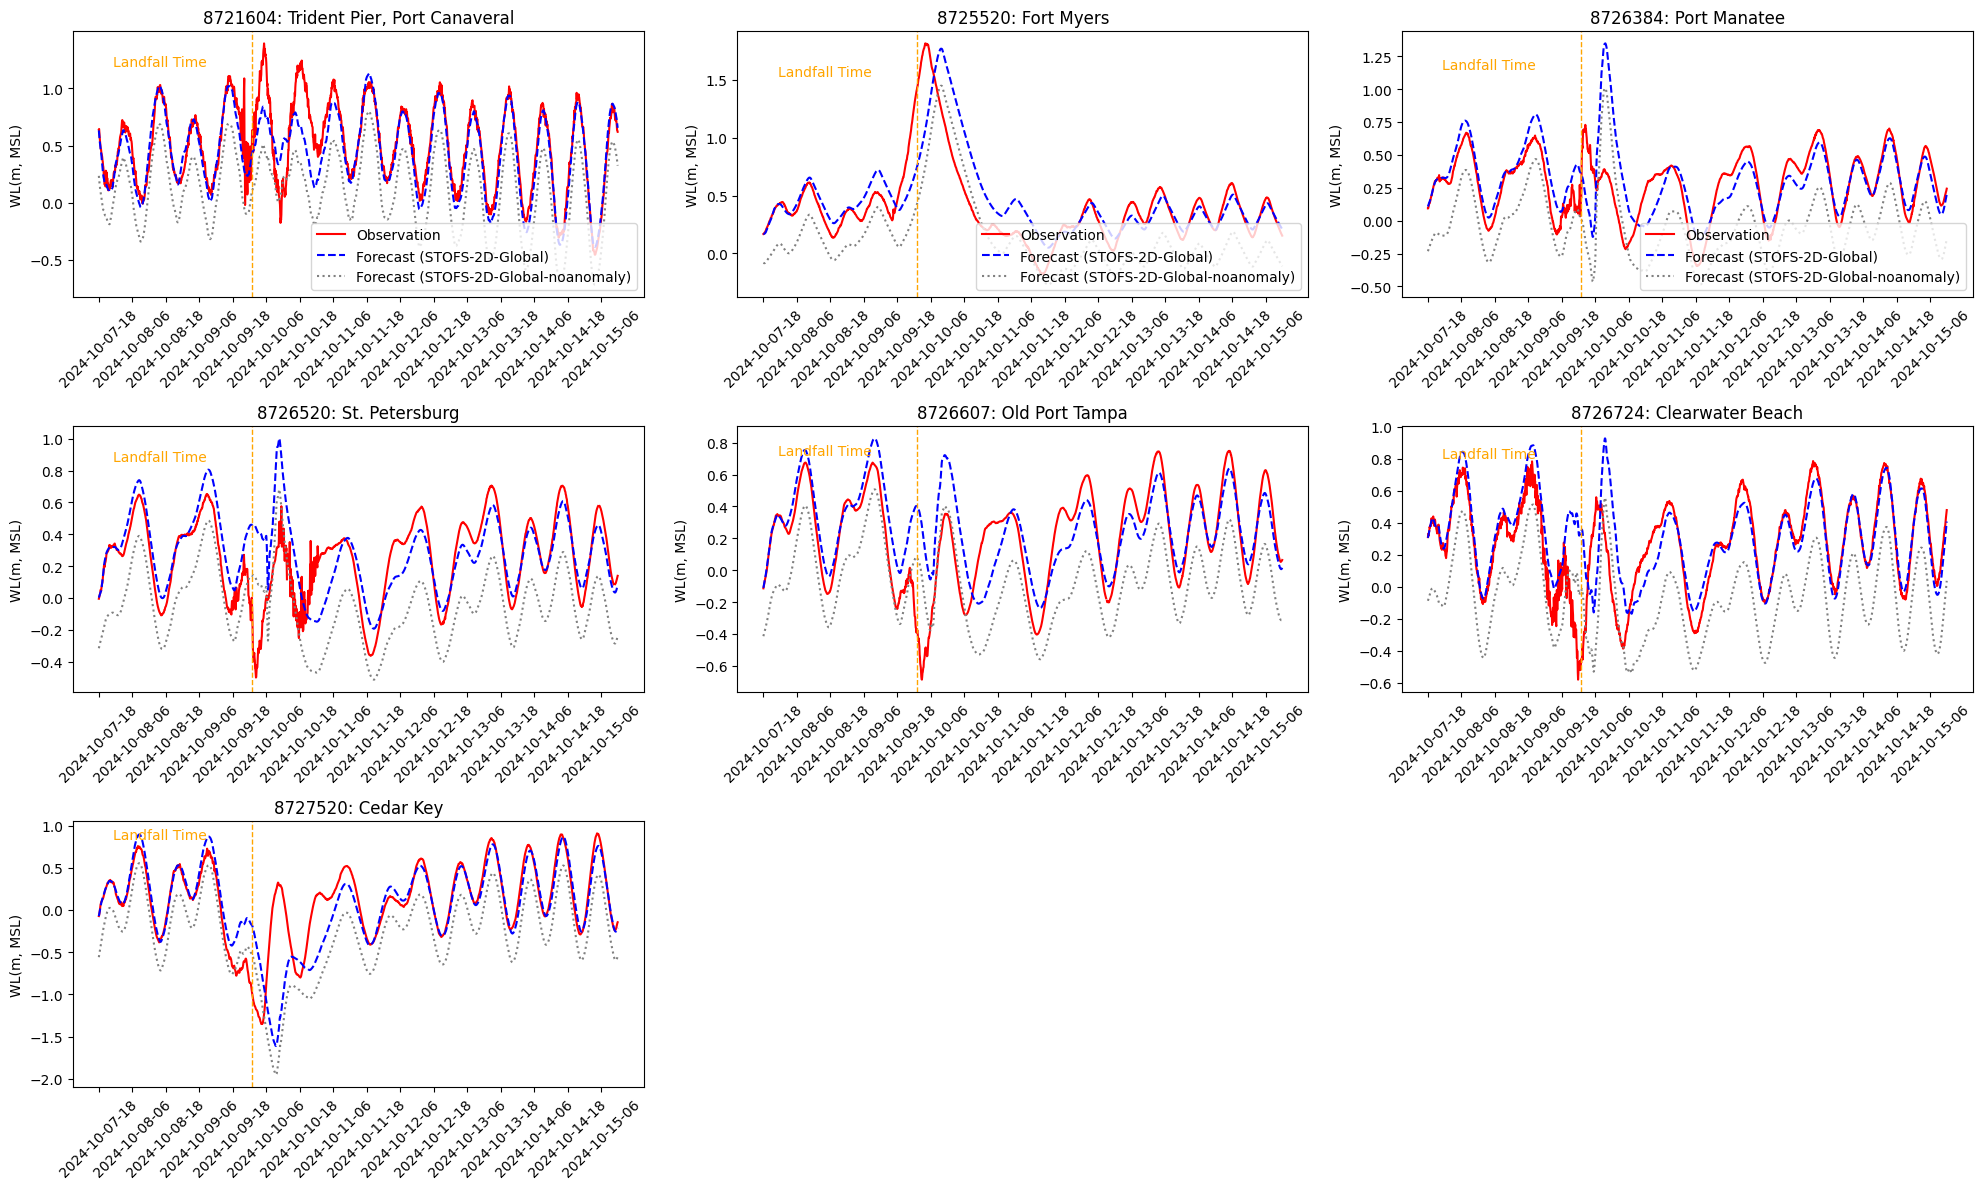

In [185]:


def convert_to_datetime(time_step):
    start_date = datetime.fromtimestamp(forecast_2d.time.values[0].astype(int) * 1e-9, tz=timezone.utc)
    time_delta = timedelta(minutes=6)
    return start_date + time_step * time_delta
num_rows = 3
num_cols = 3

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 12))  # 4 rows, 2 columns


index = 0


for row in range(num_rows):  
    for col in range(num_cols):  
        if index >= len(nos_id_points):
           # If there are fewer stations than subplots, turn off unused subplots
           axs[row, col].axis('off')
           break
            
        if index < len(nos_id_points):
            ax = axs[row, col]
            ax.plot(Observation_2d_forecast[index], label='Observation', color='red')

            ax.plot(forecast_all_zeta_values[index, :], label='Forecast (STOFS-2D-Global)', color='blue',linestyle='dashed')
            ax.plot(forecast_all_zeta_values_noanomaly[index,:], label='Forecast (STOFS-2D-Global-noanomaly)', color='gray', linestyle='dotted')

            
            ax.set_title(f'{nos_id_points[index]}: {names[index]}')
            ax.set_xticks(range(0, len(forecast_all_zeta_values[index, :]), 120)) 
            time_steps = range(0, len(forecast_all_zeta_values[index, :]))
            time_labels = [convert_to_datetime(step) for step in time_steps]
            
            # Calculate the landfall time step
            start_date = datetime.strptime(date_range[0], '%Y%m%d')
 
            landfall_datetime = start_date + timedelta(hours=landfall_time_step)
            
            forecast_2d_landfall_time_step = None 
            
            for step, time_label in zip(time_steps, time_labels): 
                if time_label.replace(tzinfo = None) == landfall_datetime:
                    forecast_2d_landfall_time_step = step 
                    break   
        

            selected_dates = time_labels[::120]
            ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
        
            ax.axvline(x=forecast_2d_landfall_time_step, color='orange', linestyle='--', linewidth=1)
            ax.text(forecast_2d_landfall_time_step*0.4, ax.get_ylim()[1]*0.8, 'Landfall Time', color='orange', ha='center')
            
            ax.set_ylabel('WL(m, MSL)')
            if row == 0 :
                ax.legend(loc='lower right')
        
        index += 1

# Turn off any remaining unused subplots 
for i in range(index, num_rows * num_cols): 
    axs.flatten()[i].axis('off')
    
plt.tight_layout()
plt.savefig(f'Forecast_2d_{Event_name}')  # Save the figure
plt.show()



# Plot Forecast for STOFS-3D-Atlantic

# Create a figure for STOFS-3D-Atlantic forecast data

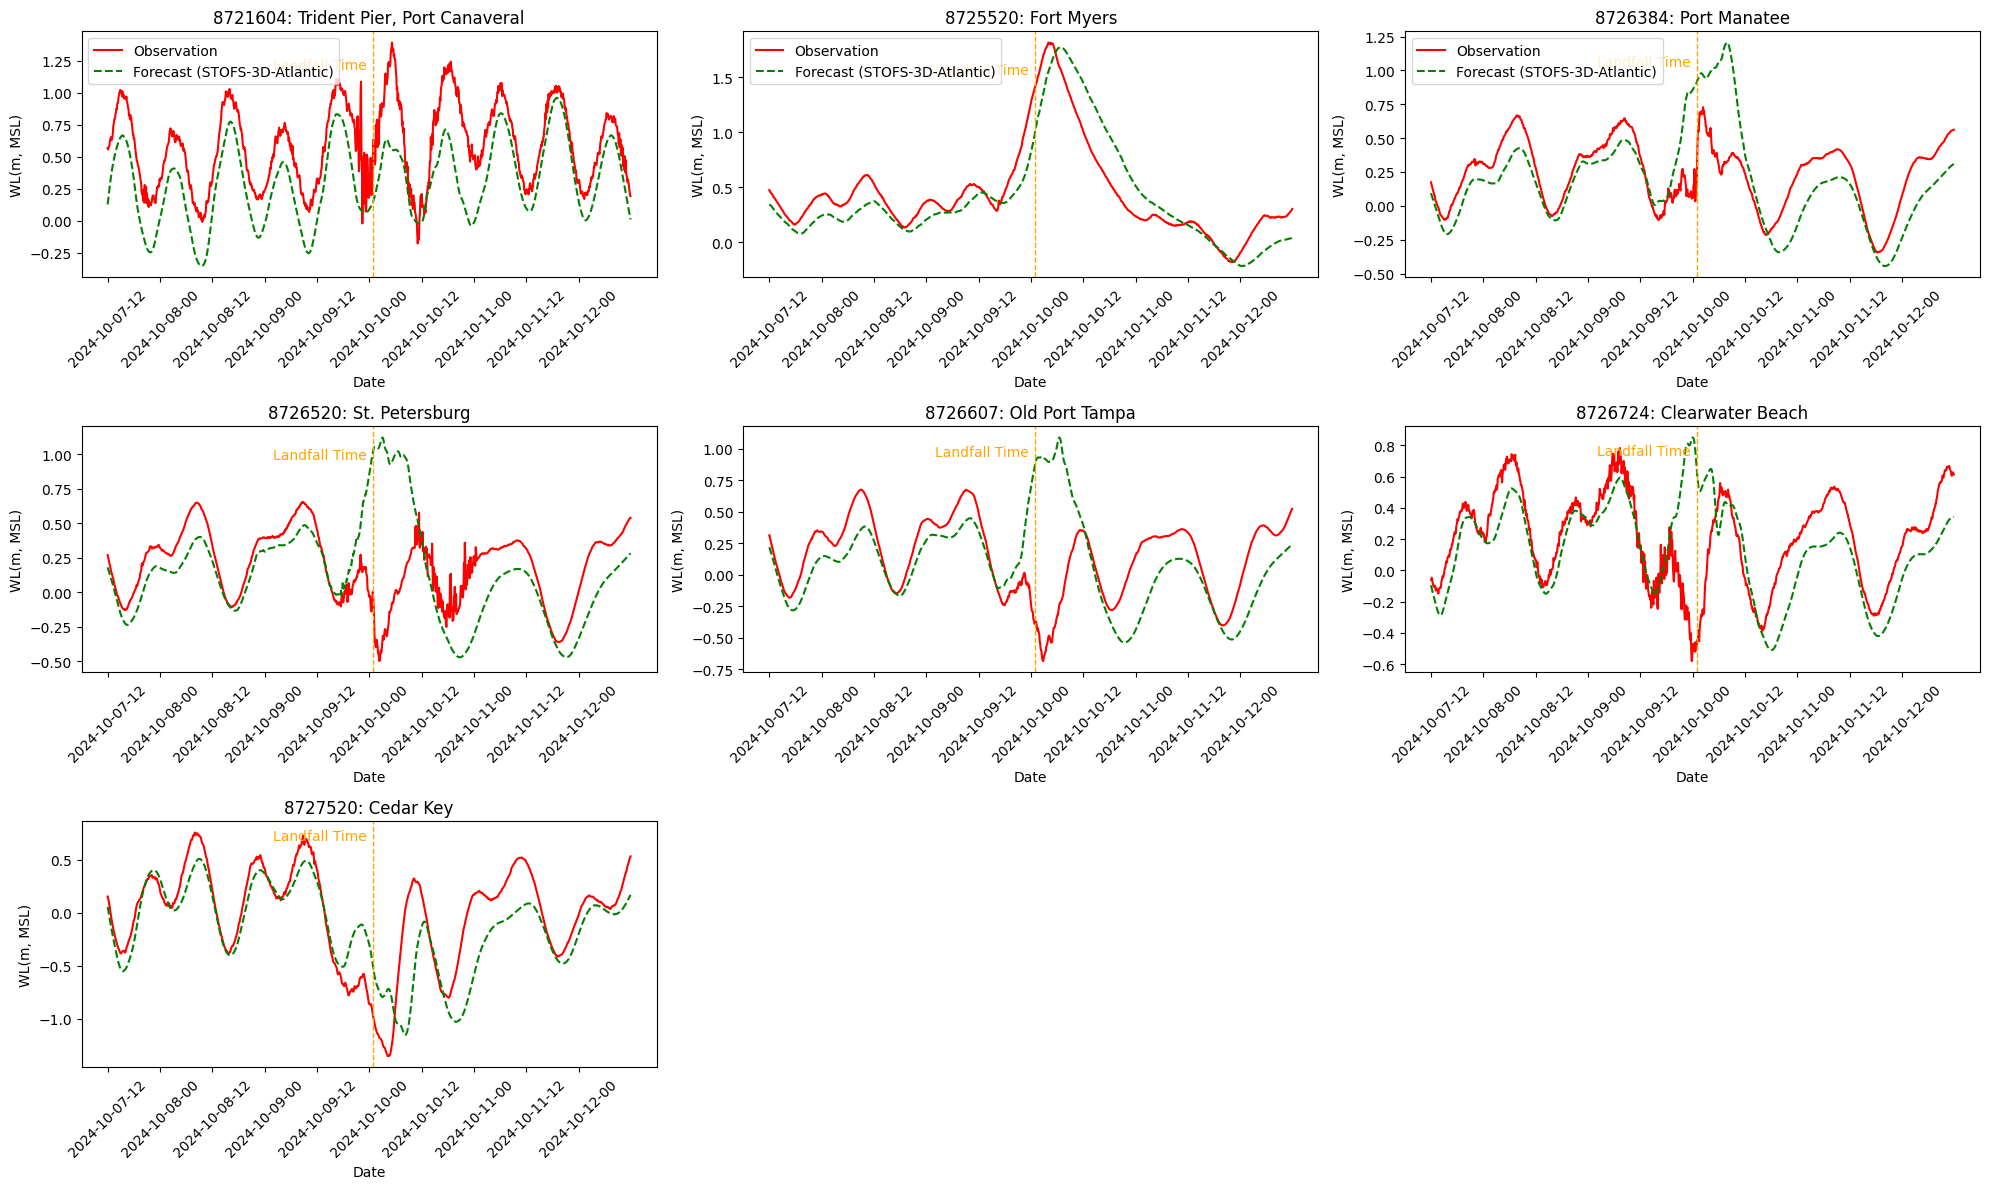

In [186]:

def convert_to_datetime(time_step):
    start_date = datetime.fromtimestamp(forecast_3d.time.values[0].astype(int) * 1e-9, tz=timezone.utc)
    time_delta = timedelta(minutes=6)
    return start_date + time_step * time_delta

num_rows = 3
num_cols = 3
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 12))  # 4 rows, 2 columns


index = 0

# From VDatum Package
Conversion_values = [0.12 , 0.076 , 0.117 ,0.095, 0.084, 0.094, 0.066, -0.041, -0.035]


for row in range(num_rows):  
    for col in range(num_cols):  
        ax = axs[row, col]
        if index >= len(nos_id_points_3d):
           # If there are fewer stations than subplots, turn off unused subplots
           ax.axis('off')
           break
            
        if index < len(nos_id_points_3d):
            
            
            ax.plot(Observation_3d_forecast[index], label='Observation', color='red')
            ax.plot(forecast_3d_all_zeta_values[index, :]+Conversion_values[index], label='Forecast (STOFS-3D-Atlantic)', color='green',linestyle='dashed')

            
            
            ax.set_title(names_3d[index])
            ax.set_title(f'{nos_id_points_3d[index]}: {names_3d[index]}')

            ax.set_xlabel('Date')
            
            # Set x ticks and labels
            ax.set_xticks(range(0, len(forecast_3d_all_zeta_values[index, :]), 120)) 
            time_steps = range(0, len(forecast_3d_all_zeta_values[index, :]))
            time_labels = [convert_to_datetime(step) for step in time_steps]
            
            # Calculate the landfall time step
            start_date = datetime.strptime(date_range[0], '%Y%m%d')
            landfall_datetime = start_date + timedelta(hours=landfall_time_step)
 
            forecast_3d_landfall_time_step = None 
            
            for step, time_label in zip(time_steps, time_labels): 
                if time_label.replace(tzinfo = None) == landfall_datetime:
                    forecast_3d_landfall_time_step = step 
                    break   
        
            selected_dates = time_labels[::120]
            ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
   
            ax.axvline(x=forecast_3d_landfall_time_step, color='orange', linestyle='--', linewidth=1)
            ax.text(forecast_3d_landfall_time_step*0.8, ax.get_ylim()[1]*0.8, 'Landfall Time', color='orange', ha='center')
            
            ax.set_ylabel('WL(m, MSL)')
            if row == 0 :
                ax.legend(loc='upper left')
        
        index += 1
        
# Turn off any remaining unused subplots 
for i in range(index, num_rows * num_cols): 
    axs.flatten()[i].axis('off')


plt.tight_layout()
plt.savefig(f'forecast_3d_{Event_name}')  # Save the figure
plt.show()


# create the overlapped figures for STOFS 2d and 3D

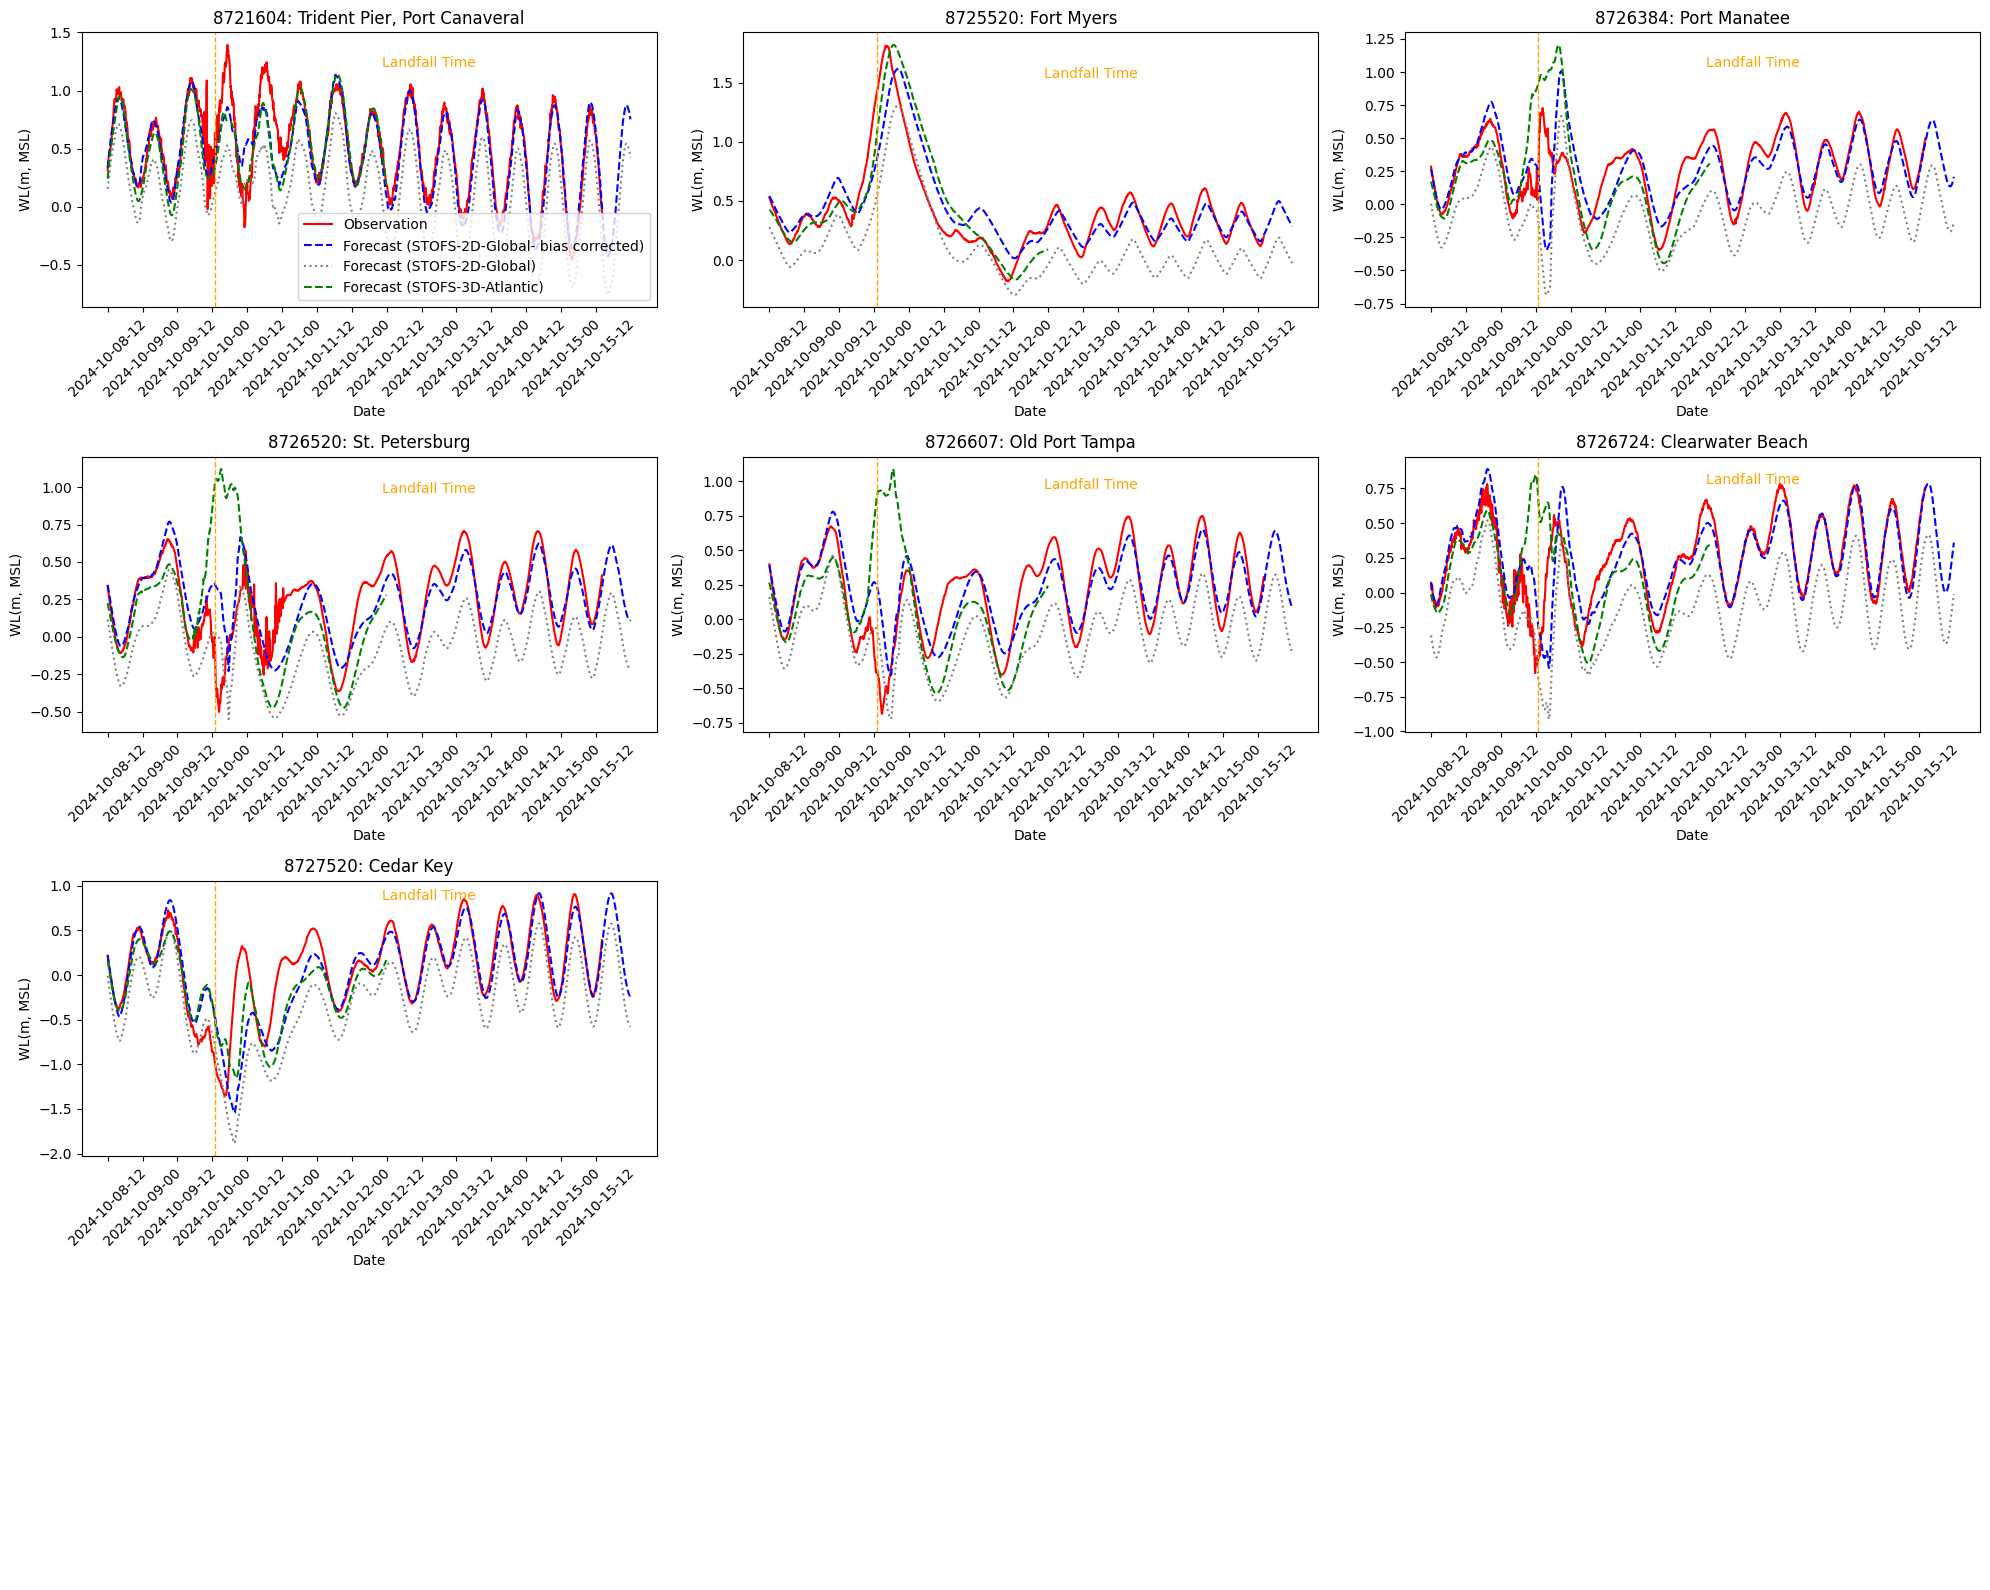

In [39]:


# From VDatum Package
Conversion_values = [0.299, 0.125, 0.117,0.095,0.084,0.094,0.066]

#Conversion_values = [0.694,0.408,0.473,0.464,0.479,0.545,0.686,0.258,0.164]




def convert_to_datetime(time_step):
    start_date = datetime.fromtimestamp(forecast_2d.time.values[6*10].astype(int) * 1e-9, tz=timezone.utc)
    time_delta = timedelta(minutes=6)
    return start_date + time_step * time_delta

# Define the number of rows and columns for subplots (2 columns)
num_rows = 4
num_cols = 3

# Create a figure and axes array with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 16))

index = 0
for row in range(num_rows):
    for col in range(num_cols):
        ax = axs[row, col]
      
        if index >= len(nos_id_points):
            # If there are fewer stations than subplots, turn off unused subplots
            axs[row, col].axis('off')
            break
    
        #ax.plot(all_zeta_para_values[index, :], label='Nowcast (STOFS-2D-Global-new)', color='blue', linestyle='dashed')
        ax.plot(Observation_2d_forecast[index][(6*10):], label='Observation',color='red')

        ax.plot(forecast_all_zeta_values[index, (6*10):], linestyle='--', label='Forecast (STOFS-2D-Global- bias corrected)', color='blue')
        ax.plot(forecast_all_zeta_values_noanomaly[index, (6*10):], label='Forecast (STOFS-2D-Global)', color='gray', linestyle='dotted')
        if nos_id_points[index] in nos_id_points_3d:
           for i in range(0,len(nos_id_points_3d)):
                if nos_id_points[index]== nos_id_points_3d[i]:
                   index_3d = i
                   break

           ax.plot(forecast_3d_all_zeta_values[index_3d, (24*10):]+Conversion_values[index_3d], label='Forecast (STOFS-3D-Atlantic)', color='green', linestyle='dashed')
        
        ax.set_title(f'{nos_id_points[index]}: {names[index]}')
            
        ax.set_xlabel('Date')
            
        ax.set_xticks(range(0, len(forecast_all_zeta_values[index, (6*10):]), 120)) 
        time_steps = range(0, len(forecast_all_zeta_values[index, (6*10):]))
        time_labels = [convert_to_datetime(step) for step in time_steps]
            
        # Calculate the landfall time step
        start_date = datetime.strptime(date_range[0], '%Y%m%d')
 
        landfall_datetime = start_date + timedelta(hours=landfall_time_step)
            
        forecast_2d_landfall_time_step = None 
            
        for step, time_label in zip(time_steps, time_labels): 
            if time_label.replace(tzinfo = None) == landfall_datetime:
                forecast_2d_landfall_time_step = step 
                break   
        

        selected_dates = time_labels[::120]
        ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
        
        ax.axvline(x=forecast_2d_landfall_time_step, color='orange', linestyle='--', linewidth=1)
        ax.text(forecast_2d_landfall_time_step*3, ax.get_ylim()[1]*0.8, 'Landfall Time', color='orange', ha='center')
            
        ax.set_ylabel('WL(m, MSL)')
        if row == 0 and col == 0:
            ax.legend(loc='lower right')
        
        index += 1
            
# Turn off any remaining unused subplots 
for i in range(index, num_rows * num_cols): 
    axs.flatten()[i].axis('off')
          
# Adjust layout
plt.tight_layout()
plt.savefig(f'forecast_stofs_{Event_name}')  # Save the figure
plt.show()

# Find CO-OPS wind observational stations

In [40]:
if Region == 'NaN':
   bbox = storm_track.wind_swaths(wind_speed=50)[advisory][track_date]
   buffered_bbox = bbox.buffer(0.8)

else:
   bbox = shapely.box(Region[0], Region[2], Region[1], Region[3])
   buffered_bbox = bbox 
all_stations = get_coops_stations(metadata_source='main', region=buffered_bbox)
#wind_stations = all_stations[((all_stations.status == 'active') & (all_stations.station_type == 'met')) | (all_stations.status == 'active') & (all_stations.station_type == 'waterlevelsandmet') ]
wind_stations = all_stations[((all_stations.status == 'active') & (all_stations.station_type == 'met'))]

wind_stations = wind_stations.sort_values(by ='nos_id')
wind_stations = wind_stations.reset_index()


wind_stations

nos_id nws_id station_type                             name state  \
0   8721604  TRDF1          met     Trident Pier, Port Canaveral    FL   
1   8722670  LKWF1          met  Lake Worth Pier, Atlantic Ocean    FL   
2   8725520  FMRF1          met                       Fort Myers    FL   
3   8726384  PMAF1          met                     Port Manatee    FL   
4   8726412  MTBF1          met                 Middle Tampa Bay    FL   
5   8726520  SAPF1          met                   St. Petersburg    FL   
6   8726524  GCTF1          met           Gadsden Cut, Tampa Bay    FL   
7   8726607  OPTF1          met                   Old Port Tampa    FL   
8   8726671  SKCF1          met        Sparkman Channel Entrance    FL   
9   8726674  EBEF1          met                         East Bay    FL   
10  8726679  TSHF1          met                East Bay Causeway    FL   
11  8726694  TPAF1          met            TPA Cruise Terminal 2    FL   
12  8726724  CWBF1          met                 Clearwater Beach    FL   
13  8727520  CKYF1          met                        Cedar Key    FL   

          lon        lat removed  status                    geometry  
0  -80.593056  28.415833     NaT  active  POINT (-80.59306 28.41583)  
1  -80.034164  26.612778     NaT  active  POINT (-80.03416 26.61278)  
2  -81.871002  26.648001     NaT  active  POINT (-81.87100 26.64800)  
3  -82.562103  27.638700     NaT  active  POINT (-82.56210 27.63870)  
4  -82.599442  27.661667     NaT  active  POINT (-82.59944 27.66167)  
5  -82.626900  27.760599     NaT  active  POINT (-82.62690 27.76060)  
6  -82.516861  27.773527     NaT  active  POINT (-82.51686 27.77353)  
7  -82.552803  27.857800     NaT  active  POINT (-82.55280 27.85780)  
8  -82.445274  27.920555     NaT  active  POINT (-82.44527 27.92056)  
9  -82.421387  27.923056     NaT  active  POINT (-82.42139 27.92306)  
10 -82.425751  27.929001     NaT  active  POINT (-82.42575 27.92900)  
11 -82.445862  27.942972     NaT  active  POINT (-82.44586 27.94297)  
12 -82.831665  27.978333     NaT  active  POINT (-82.83167 27.97833)  
13 -83.031700  29.135000     NaT  active  POINT (-83.03170 29.13500)

# Read wind Observation data

# Read GFS Nowcast on the Fly

In [105]:


def find_index_closest_data(ds, stations):
    lat_indices = {}
    lon_indices = {}
    
    for y_val, x_val, nos_id in zip(stations['lat'], stations['lon'], stations['nos_id']): 
        longitude_adjusted = float(x_val) + 360 if float(x_val) < 0 else float(x_val)
        
        # Get the nearest indices for latitude and longitude
        lat_idx = np.where((np.abs(ds['latitude'][0:4718592:3072] - float(y_val))) == np.min(np.abs(ds['latitude'][0:4718592:3072] -                          float(y_val))))
        lon_idx = np.where((np.abs(ds['longitude'][0:3072] - longitude_adjusted)) == np.min(np.abs(ds['longitude'][0:3072] -                                  longitude_adjusted)))
       
        # Store indices in dictionaries 
        lat_indices[nos_id] = lat_idx 
        lon_indices[nos_id] = lon_idx

    return lat_indices, lon_indices

def fetch_gfs_Nowcast_data(start_date, end_date, cycles, stations, num_time_steps):
    """
    Function to fetch GFS data for specified dates and cycles and return a DataFrame with wind and pressure information.

    Parameters:
    - start_date (str): The start date in 'YYYYMMDD' format.
    - end_date (str): The end date in 'YYYYMMDD' format.
    - cycles (list of str): List of cycles (e.g., ['00', '06', '12', '18']).
    - stations (DataFrame): DataFrame containing station information (lat, lon, nos_id).
    - num_time_steps (int): Number of time steps to retrieve from each cycle.

    Returns:
    - pd.DataFrame: DataFrame containing the time, u_wind, v_wind, and surface pressure.
    """
    
    # Initialize a list to store data for the DataFrame
    u_wind_dfs = pd.DataFrame()
    v_wind_dfs = pd.DataFrame()
    surface_pressure_dfs = pd.DataFrame()

    # Initialize list to store all time information 
    all_times = []


    # Generate date list
    dates = []
    current_date = datetime.strptime(start_date, '%Y%m%d')
    end_date = datetime.strptime(end_date, '%Y%m%d')

    while current_date <= end_date:
        dates.append(current_date.strftime('%Y%m%d'))
        current_date += timedelta(days=1)

    for date in dates:
        print(date)
        for i, cycle in enumerate(cycles):
            for hour in range(0, num_time_steps, 1):  # Loop over specified number of time steps
                # Adjust date for the previous cycle if needed

                key = f'gfs.{date}/{cycle}/atmos/gfs.t{cycle}z.sfluxgrbf{hour:03d}.grib2'
                time = datetime.strptime(date, '%Y%m%d') + timedelta(hours=int(cycle)) + timedelta(hours=hour)

                print(key)    
                url = f"s3://noaa-gfs-bdp-pds/{key}"

                # Fetch the GRIB2 data from S3
                try:
                    s3 = s3fs.S3FileSystem(anon=True)
                    with s3.open(url, 'rb') as f:
                        grib_data = f.read()
                except Exception as e:
                    print(f"Error fetching data from {url}: {e}")
                    continue

                # Define variable names of interest
                variable_names = ['Surface pressure', '10 metre U wind component', '10 metre V wind component']
                data_arrays = {var_name: [] for var_name in variable_names}

                # Read GRIB2 data
                with tempfile.NamedTemporaryFile(suffix=".grib2") as tmp_file:
                    tmp_file.write(grib_data)
                    tmp_file.seek(0)
                    grbs = pygrib.open(tmp_file.name)

                    for grb in grbs:
                        if grb['name'] in variable_names:
                            data_arrays[grb['name']].append(grb.values)

                    grbs.close()


                # Convert data arrays to xarray DataArrays
                pressure_data = xr.DataArray(np.array(data_arrays['Surface pressure']), name='surface_pressure')
                u_wind_data = xr.DataArray(np.array(data_arrays['10 metre U wind component']), name='u_wind')
                v_wind_data = xr.DataArray(np.array(data_arrays['10 metre V wind component']), name='v_wind')

                print(hour)
                # Create an xarray Dataset
                ds = xr.Dataset(
                data_vars={
                'surface_pressure': pressure_data,
                'u_wind': u_wind_data,
                'v_wind': v_wind_data},
                coords={
                'latitude': grb.latitudes,  # Assuming latitudes are the same for all messages
                'longitude': grb.longitudes,},
                attrs={
                'description': 'GRIB Data Example'})


                # Rename the dimensions 'dim_0', 'dim_1', 'dim_2' to 'time', 'y', 'x'
                ds = ds.rename({'dim_0': 'time', 'dim_1': 'y', 'dim_2': 'x'})
                # Initialize empty DataFrames to store wind and pressure data for this hour
                u_wind_df = pd.DataFrame()
                v_wind_df = pd.DataFrame()
                surface_pressure_df = pd.DataFrame()
                   
                # Extract values for  stations
                if not all_times:
                    lat_indices, lon_indices = find_index_closest_data(ds, stations)  
                    print(lat_indices)
             
                for nos_id in  stations['nos_id']:
                    # Extract the forcing data using the index
                    u_wind_value = ds.u_wind[0, lat_indices[nos_id][0][0], lon_indices[nos_id][0][0]].values
                    v_wind_value = ds.v_wind[0, lat_indices[nos_id][0][0], lon_indices[nos_id][0][0]].values
                    surface_pressure_value = ds.surface_pressure[0, lat_indices[nos_id][0][0], lon_indices[nos_id][0][0]].values


                    # Append the values to the respective DataFrames as columns with NOS ids as column names
                    u_wind_df[int(nos_id)] = [np.round(u_wind_value, 2)]
                    v_wind_df[int(nos_id)]= [np.round(v_wind_value, 2)]
                    surface_pressure_df[int(nos_id)] = [np.round(surface_pressure_value, 2)]
            
                # Append data for each station to the list
                u_wind_dfs = pd.concat([u_wind_dfs, u_wind_df], ignore_index=True)
                v_wind_dfs = pd.concat([v_wind_dfs, v_wind_df], ignore_index=True)
                surface_pressure_dfs = pd.concat([surface_pressure_dfs, surface_pressure_df], ignore_index=True)
            
                # Store the time information 
                all_times.append(time) 

    return u_wind_dfs, v_wind_dfs, surface_pressure_dfs, all_times


def fetch_gfs_Forecast_data(date, cycle, stations):
    """
    Function to fetch GFS data for date and cycle used as the STOFS forcing data and return a DataFrame with wind and pressure information.

    Parameters:
    - date (str): The date in 'YYYYMMDD' format.
    - cycle (str): cycle (e.g., ['00', '06', '12', '18']).
    - stations (DataFrame): DataFrame containing station information (lat, lon, nos_id).

    Returns:
    - pd.DataFrames: DataFrame containing the time, u_wind, v_wind, and surface pressure.
    """
    
    # Initialize a list to store data for the DataFrame
    u_wind_dfs = pd.DataFrame()
    v_wind_dfs = pd.DataFrame()
    surface_pressure_dfs = pd.DataFrame()

    # Initialize list to store all time information 
    all_times = []

    # list of cycles in STOFS-2dd-Global
    cycles_2d = ['00', '06', '12', '18']  


    # Generate date list
    for hour in range(0, 121, 1):  # Assuming we want to loop from 0 to 120 hours
            print(hour)
            if hour < 6:
                if cycle == '00':
                        current_date = datetime.strptime(date, '%Y%m%d') 
                        current_date -= timedelta(days=1) # Go back one day 
                        date_one_day_back = current_date.strftime('%Y%m%d')
                        previous_cycle = '18'

                        # Define the filename and the location of the GRIB2 file
                        key = f'gfs.{date_one_day_back}/{previous_cycle}/atmos/gfs.t{previous_cycle}z.sfluxgrbf{hour:03d}.grib2'
                        url = f"s3://noaa-gfs-bdp-pds/{key}"
                        time = datetime.strptime(date_one_day_back, '%Y%m%d') + timedelta(hours=int(previous_cycle)) + timedelta(hours=hour) 
                        print(time)
                else:
                        
                        
                        previous_cycle = cycles_2d[cycles_2d.index(cycle) - 1] 
                         
                        # Define the filename and the location of the GRIB2 file
                        key = f'gfs.{date}/{previous_cycle}/atmos/gfs.t{previous_cycle}z.sfluxgrbf{(hour):03d}.grib2'
                        url = f"s3://noaa-gfs-bdp-pds/{key}"
                        print(url)
                        #time = datetime.strptime(date, '%Y%m%d') + timedelta(hours=int(previous_cycle)) + timedelta(hours=hour) 
                        time = datetime.strptime(date, '%Y%m%d') + timedelta(hours=int(previous_cycle)) + timedelta(hours=hour)
                        print(time)
            else: 
                
                # Define the filename and the location of the GRIB2 file
                key = f'gfs.{date}/{cycle}/atmos/gfs.t{cycle}z.sfluxgrbf{(hour-6):03d}.grib2'
                url = f"s3://noaa-gfs-bdp-pds/{key}"
                print(url)
                time = datetime.strptime(date, '%Y%m%d') + timedelta(hours=int(cycle))+ timedelta(hours=hour-6) 
                print(time)
                

            # Fetch the GRIB2 data from S3
            s3 = s3fs.S3FileSystem(anon=True)
            with s3.open(url, 'rb') as f:
                 grib_data = f.read()


            # Define the variable names of interest
            variable_names = ['Surface pressure', '10 metre U wind component', '10 metre V wind component']


            # Initialize empty arrays to store data
            data_arrays = {var_name: [] for var_name in variable_names}


            # Save the GRIB2 data to a temporary file
            with tempfile.NamedTemporaryFile(suffix=".grib2") as tmp_file:
                 tmp_file.write(grib_data)
                 tmp_file.seek(0)  # Reset file pointer to the beginning
                 # Read the GRIB2 data using pygrib from the temporary file
                 grbs = pygrib.open(tmp_file.name)


                 # Iterate over each message in the GRIB2 file
                 for grb in grbs:
                     # Check if the message corresponds to one of the variables of interest
                 
                     if grb['name'] in variable_names:
                        # Append data to the corresponding array
                        data_arrays[grb['name']].append(grb.values)

                 # Close the GRIB2 file
                 grbs.close()

            # Convert data arrays to xarray DataArrays
            pressdata_arraysure_data = xr.DataArray(np.array(data_arrays['Surface pressure']), name='surface_pressure')
            u_wind_data = xr.DataArray(np.array(data_arrays['10 metre U wind component']), name='u_wind')
            v_wind_data = xr.DataArray(np.array(data_arrays['10 metre V wind component']), name='v_wind')


            # Create an xarray Dataset
            ds = xr.Dataset(
            data_vars={
            'surface_pressure': pressdata_arraysure_data,
            'u_wind': u_wind_data,
            'v_wind': v_wind_data},
             coords={
            'latitude': grb.latitudes,  # Assuming latitudes are the same for all messages
            'longitude': grb.longitudes,},
             attrs={
            'description': 'GRIB Data Example'})


            # Rename the dimensions 'dim_0', 'dim_1', 'dim_2' to 'time', 'y', 'x'
            ds = ds.rename({'dim_0': 'time', 'dim_1': 'y', 'dim_2': 'x'})
    
            # Initialize empty DataFrames to store wind and pressure data for this hour
            u_wind_df = pd.DataFrame()
            v_wind_df = pd.DataFrame()
            surface_pressure_df = pd.DataFrame()
    
            # Extract values for  stations
            if not all_times:
                    lat_indices, lon_indices = find_index_closest_data(ds, stations)  
                    
             
            for nos_id in  stations['nos_id']:
                    
                    # Extract the forcing data using the index
                    u_wind_value = ds.u_wind[0, lat_indices[nos_id][0][0], lon_indices[nos_id][0][0]].values
                    v_wind_value = ds.v_wind[0, lat_indices[nos_id][0][0], lon_indices[nos_id][0][0]].values
                    surface_pressure_value = ds.surface_pressure[0, lat_indices[nos_id][0][0], lon_indices[nos_id][0][0]].values


                    # Append the values to the respective DataFrames as columns with NOS ids as column names
                    u_wind_df[int(nos_id)] = [np.round(u_wind_value, 2)]
                    v_wind_df[int(nos_id)]= [np.round(v_wind_value, 2)]
                    surface_pressure_df[int(nos_id)] = [np.round(surface_pressure_value, 2)]


            u_wind_dfs = pd.concat([u_wind_dfs, u_wind_df], ignore_index=True)
            
            v_wind_dfs = pd.concat([v_wind_dfs, v_wind_df], ignore_index=True)
            surface_pressure_dfs = pd.concat([surface_pressure_dfs, surface_pressure_df], ignore_index=True)
            
            # Store the time information 
            all_times.append(time) 

    # Loop over different files for different hours
    for hour in range(120, 184, 3):  
            print(hour)
            
            # Define the filename and the location of the GRIB2 file for the current hour

            key_current = f'gfs.{date}/{cycle}/atmos/gfs.t{cycle}z.sfluxgrbf{(hour-6):03d}.grib2'
            url_current = f"s3://noaa-gfs-bdp-pds/{key_current}"
             
            print(url_current)
            # Fetch the GRIB2 data from S3 for the current hour
            s3_current = s3fs.S3FileSystem(anon=True)
            with s3_current.open(url_current, 'rb') as f_current:
                 grib_data_current = f_current.read()

            # Define the variable names of interest
            variable_names = ['Surface pressure', '10 metre U wind component', '10 metre V wind component']

            # Initialize empty arrays to store current data
            data_arrays_current = {var_name: [] for var_name in variable_names}
 
            # Save the current GRIB2 data to a temporary file
            with tempfile.NamedTemporaryFile(suffix=".grib2") as tmp_file:
                 tmp_file.write(grib_data_current)
                 tmp_file.seek(0)  # Reset file pointer to the beginning
                 # Read the GRIB2 data using pygrib from the temporary file
                 grbs = pygrib.open(tmp_file.name)

                 # Iterate over each message in the GRIB2 file
                 for grb in grbs:
                     # Check if the message corresponds to one of the variables of interest
                     if grb['name'] in variable_names:
                        # Append data to the corresponding array
                        data_arrays_current[grb['name']].append(grb.values)

                 # Close the GRIB2 file
                 grbs.close()

    
            # Convert data arrays to xarray DataArrays for current data
            pressure_data_current = xr.DataArray(np.array(data_arrays_current['Surface pressure']), name='surface_pressure')
            u_wind_data_current = xr.DataArray(np.array(data_arrays_current['10 metre U wind component']), name='u_wind')
            v_wind_data_current = xr.DataArray(np.array(data_arrays_current['10 metre V wind component']), name='v_wind')

            # Create an xarray Dataset for current data
            ds_current = xr.Dataset(
            data_vars={
               'surface_pressure': pressure_data_current,
               'u_wind': u_wind_data_current,
               'v_wind': v_wind_data_current,},
            coords={
            'latitude': grb.latitudes,  # Assuming latitudes are the same for all messages
            'longitude': grb.longitudes,},  # Assuming longitudes are the same for all messages 
            attrs={ 'description': 'GRIB Data Example', }, )

            # Rename the dimensions 'dim_0', 'dim_1', 'dim_2' to 'time', 'y', 'x'
            ds_current = ds_current.rename({'dim_0': 'time', 'dim_1': 'y', 'dim_2': 'x'})
    
            # Define the filename and the location of the GRIB2 file for the next hour
            hour_next = hour + 3  # Assuming data is available 3-hourly
            key_next = f'gfs.{date}/{cycle}/atmos/gfs.t{cycle}z.sfluxgrbf{(hour_next-6):03d}.grib2'
            url_next = f"s3://noaa-gfs-bdp-pds/{key_next}"
  
            # Fetch the GRIB2 data from S3 for the next hour
            s3_next = s3fs.S3FileSystem(anon=True)
            with s3_next.open(url_next, 'rb') as f_next:
                grib_data_next = f_next.read()

            # Initialize empty arrays to store current data
            data_arrays_next = {var_name: [] for var_name in variable_names}

            # Save the current GRIB2 data to a temporary file
            with tempfile.NamedTemporaryFile(suffix=".grib2") as tmp_file:
                 tmp_file.write(grib_data_next)
                 tmp_file.seek(0)  # Reset file pointer to the beginning
                 # Read the GRIB2 data using pygrib from the temporary file
                 grbs = pygrib.open(tmp_file.name)

                 # Iterate over each message in the GRIB2 file
                 for grb in grbs:
                     # Check if the message corresponds to one of the variables of interest
                     if grb['name'] in variable_names:
                        # Append data to the corresponding array
                        data_arrays_next[grb['name']].append(grb.values)

                 # Close the GRIB2 file
                 grbs.close()


            # Convert data arrays to xarray DataArrays for next file data
            pressure_data_next = xr.DataArray(np.array(data_arrays_next['Surface pressure']), name='surface_pressure')
            u_wind_data_next = xr.DataArray(np.array(data_arrays_next['10 metre U wind component']), name='u_wind')
            v_wind_data_next = xr.DataArray(np.array(data_arrays_next['10 metre V wind component']), name='v_wind')

            # Create an xarray Dataset for next file data
            ds_next = xr.Dataset(
            data_vars={
            'surface_pressure': pressure_data_next,
            'u_wind': u_wind_data_next,
            'v_wind': v_wind_data_next,    },
            coords={
            'latitude': grb.latitudes,  # Assuming latitudes are the same for all messages
            'longitude': grb.longitudes,  # Assuming longitudes are the same for all messages
            },
            attrs={
            'description': 'GRIB Data Example',    },
            )

            # Rename the dimensions 'dim_0', 'dim_1', 'dim_2' to 'time', 'y', 'x'
            ds_next = ds_next.rename({'dim_0': 'time', 'dim_1': 'y', 'dim_2': 'x'})

            # Initialize empty DataFrames to store wind and pressure data for this hour
            for hour_1 in range(1, 4, 1): 
         
                u_wind_df = pd.DataFrame()
                v_wind_df = pd.DataFrame()
                surface_pressure_df = pd.DataFrame()
    
                # Loop over the elements of station_ds['y'] and station_ds['x']
                for nos_id in stations['nos_id']:

                    # Extract the current forcing data using the index 
                    u_wind_value_0 = ds_current.u_wind[0, lat_indices[nos_id][0][0], lon_indices[nos_id][0][0]].values
                    v_wind_value_0 = ds_current.v_wind[0, lat_indices[nos_id][0][0], lon_indices[nos_id][0][0]].values
                    surface_pressure_value_0 = ds_current.surface_pressure[0, lat_indices[nos_id][0][0], lon_indices[nos_id][0][0]].values

                    # Extract the next forcing data using the index 
                    u_wind_value_3 = ds_next.u_wind[0, lat_indices[nos_id][0][0], lon_indices[nos_id][0][0]].values
                    v_wind_value_3 = ds_next.v_wind[0, lat_indices[nos_id][0][0], lon_indices[nos_id][0][0]].values
                    surface_pressure_value_3 = ds_next.surface_pressure[0, lat_indices[nos_id][0][0], lon_indices[nos_id][0][0]].values
             
                    # Calculate interpolation coefficient
                    u_wind_coeff = (u_wind_value_3 - u_wind_value_0) / 3
                    v_wind_coeff = (v_wind_value_3 - v_wind_value_0) / 3 
                    surface_pressure_coeff = (surface_pressure_value_3 - surface_pressure_value_0) / 3 
                           
                    # Append the values to the respective DataFrames as columns with NOS ids as column names
                    u_wind_df[int(nos_id)] = [np.round(u_wind_value_0, 2)] + hour_1*u_wind_coeff
                    v_wind_df[int(nos_id)]= [np.round(v_wind_value_0, 2)] + hour_1*v_wind_coeff
                    surface_pressure_df[int(nos_id)] = [np.round(surface_pressure_value_0, 2)] + hour_1*surface_pressure_coeff

                u_wind_dfs = pd.concat([u_wind_dfs, u_wind_df], ignore_index=True)
                v_wind_dfs = pd.concat([v_wind_dfs, v_wind_df], ignore_index=True)
                surface_pressure_dfs = pd.concat([surface_pressure_dfs, surface_pressure_df], ignore_index=True)
                time = datetime.strptime(date, '%Y%m%d') + timedelta(hours=int(previous_cycle)) + timedelta(hours=hour)+timedelta(hours=hour_1)
                all_times.append(time) 


    

    return u_wind_dfs, v_wind_dfs, surface_pressure_dfs, all_times




In [106]:
# Define parameters
start_date = date_range[0]
end_date = date_range[1]
cycles = ['00', '06', '12', '18']
num_time_steps = 6  # Number of time steps to retrieve

# Fetch GFS data
u_wind_dfs,v_wind_dfs, surface_pressure_dfs, all_time  = fetch_gfs_Nowcast_data(start_date, end_date, cycles, wind_stations, num_time_steps)

print(u_wind_dfs)
print(v_wind_dfs)
print(surface_pressure_dfs)
print(all_time)


20241004
gfs.20241004/00/atmos/gfs.t00z.sfluxgrbf000.grib2
0
{'8721604': (array([525]),), '8722670': (array([540]),), '8725520': (array([540]),), '8726384': (array([532]),), '8726412': (array([531]),), '8726520': (array([531]),), '8726524': (array([530]),), '8726607': (array([530]),), '8726671': (array([529]),), '8726674': (array([529]),), '8726679': (array([529]),), '8726694': (array([529]),), '8726724': (array([529]),), '8727520': (array([519]),)}
gfs.20241004/00/atmos/gfs.t00z.sfluxgrbf001.grib2
1
gfs.20241004/00/atmos/gfs.t00z.sfluxgrbf002.grib2
2
gfs.20241004/00/atmos/gfs.t00z.sfluxgrbf003.grib2
3
gfs.20241004/00/atmos/gfs.t00z.sfluxgrbf004.grib2
4
gfs.20241004/00/atmos/gfs.t00z.sfluxgrbf005.grib2
5
gfs.20241004/06/atmos/gfs.t06z.sfluxgrbf000.grib2
0
gfs.20241004/06/atmos/gfs.t06z.sfluxgrbf001.grib2
1
gfs.20241004/06/atmos/gfs.t06z.sfluxgrbf002.grib2
2
gfs.20241004/06/atmos/gfs.t06z.sfluxgrbf003.grib2
3
gfs.20241004/06/atmos/gfs.t06z.sfluxgrbf004.grib2
4
gfs.20241004/06/atmos/gfs.

In [107]:
# Convert all_times list to DataFrame 
time_df = pd.DataFrame({'Time': all_time}) # Print or use time_df as needed print(time_df)

time_df


Time
0   2024-10-04 00:00:00
1   2024-10-04 01:00:00
2   2024-10-04 02:00:00
3   2024-10-04 03:00:00
4   2024-10-04 04:00:00
..                  ...
163 2024-10-10 19:00:00
164 2024-10-10 20:00:00
165 2024-10-10 21:00:00
166 2024-10-10 22:00:00
167 2024-10-10 23:00:00

[168 rows x 1 columns]

# Read Observation data for GFS

In [108]:
# Initialize an empty DataFrame to store the data
Wind_Observation_2d_Nowcast= []
pressure_Observation_2d_Nowcast= []
# Loop over each nos_id
for nos_id in wind_stations['nos_id']:
      
       try:
          # Retrieve wind information for the specified date range
          station_wind = fetch_coops_station(
          station_id=nos_id,
          start_date=time_df['Time'][0],
          end_date=time_df['Time'][len(time_df)-1],
          product='wind',  interval='h')
          # Add the data for the current station to the result DataFrame
          #station_wind = station_wind.reset_index()
          Wind_Observation_2d_Nowcast.append(station_wind['speed'])

          station_pressure = fetch_coops_station(
          station_id=nos_id,
          start_date=time_df['Time'][0],
          end_date=time_df['Time'][len(time_df)-1],
          product='air_pressure',  interval='h')
          # Add the data for the current station to the result DataFrame
          #station_wind = station_wind.reset_index()
          pressure_Observation_2d_Nowcast.append(station_pressure['value'])

    
       except: 

          print(f'{nos_id} has no wind data')
     
    
Wind_Observation_2d_Nowcast

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/en

8726384 has no wind data


/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

8726524: Encountered an error response for {'station_id': '8726524', 'url': URL('https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?station=8726524&product=wind&datum=M

8726524 has no wind data


/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

8726671: Encountered an error response for {'station_id': '8726671', 'url': URL('https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?station=8726671&product=wind&datum=MSL&units=metric&time_zone=gmt&format=json&application=oceanmodeling%2Fstormevents&interval=h&begin_date=20241004%2000%3A00&end_date=20241010%2023%3A00'), 'client': <httpx.Client object at 0x2b3dc0d558e0>, 'rate_limit': <multifutures._rate_limit.RateLimit object at 0x2b3dd5082f00>, 'product': <COOPS_Product.WIND: 'wind'>, 'redire

8726671 has no wind data
8726674 has no wind data


8726679: Encountered an error response for {'station_id': '8726679', 'url': URL('https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?station=8726679&product=wind&datum=MSL&units=metric&time_zone=gmt&format=json&application=oceanmodeling%2Fstormevents&interval=h&begin_date=20241004%2000%3A00&end_date=20241010%2023%3A00'), 'client': <httpx.Client object at 0x2b3da7dabf50>, 'rate_limit': <multifutures._rate_limit.RateLimit object at 0x2b3db3384a70>, 'product': <COOPS_Product.WIND: 'wind'>, 'redirect': True}!
--> No data was found. This product may not be offered at this station at the requested time.
COOPS-8726679: No data. Creating a dummy dataframe


8726679 has no wind data


/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

8726694: Encountered an error response for {'station_id': '8726694', 'url': URL('https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?station=8726694&product=air_pressure&datum=MSL&units=metric&time_zone=gmt&format=json&application=oceanmodeling%2Fstormevents&interval=h&begin_date=20241004%2000%3A00&end_date=20241010%2023%3A00'), 'client': <httpx.Client object at 0x2b3dc0d54530>, 'rate_limit': <multifutures._rate_limit.RateLimit object at 0x2b3dd4773e00>, 'product': <COOPS_Product.AIR_PRESSURE: 'air_pressure'>, 'redirect': True}!
--> No data was found. This product may not be offered at this station at the requested time.
COOPS-8726694: No data. Creating a 

8726694 has no wind data


/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time



[time
 2024-10-04 00:00:00+00:00    1.6
 2024-10-04 01:00:00+00:00    2.1
 2024-10-04 02:00:00+00:00    2.4
 2024-10-04 03:00:00+00:00    1.8
 2024-10-04 04:00:00+00:00    2.9
                             ... 
 2024-10-10 19:00:00+00:00    9.8
 2024-10-10 20:00:00+00:00    9.1
 2024-10-10 21:00:00+00:00    5.5
 2024-10-10 22:00:00+00:00    7.3
 2024-10-10 23:00:00+00:00    4.9
 Name: speed, Length: 168, dtype: float64,
 time
 2024-10-04 00:00:00+00:00    3.8
 2024-10-04 01:00:00+00:00    3.4
 2024-10-04 02:00:00+00:00    3.1
 2024-10-04 03:00:00+00:00    3.8
 2024-10-04 04:00:00+00:00    3.9
                             ... 
 2024-10-10 19:00:00+00:00    7.8
 2024-10-10 20:00:00+00:00    8.5
 2024-10-10 21:00:00+00:00    6.5
 2024-10-10 22:00:00+00:00    6.6
 2024-10-10 23:00:00+00:00    3.3
 Name: speed, Length: 168, dtype: float64,
 time
 2024-10-04 00:00:00+00:00    1.7
 2024-10-04 01:00:00+00:00    3.4
 2024-10-04 02:00:00+00:00    1.7
 2024-10-04 03:00:00+00:00    2.2
 2024-10-04 

In [109]:
# Initialize an empty DataFrame to store the data
Wind_Observation_2d_Nowcast = []
pressure_Observation_2d_Nowcast = []
valid_nos_ids = list(wind_stations['nos_id'])  # List of all nos_ids

# Loop over each nos_id
for nos_id in valid_nos_ids.copy():  # Use a copy of the list to avoid modifying it while iterating
    try:
        # Retrieve wind information for the specified date range
        station_wind = fetch_coops_station(
            station_id=nos_id,
            start_date=time_df['Time'][0],
            end_date=time_df['Time'].iloc[-1],  # Use iloc[-1] to get the last element
            product='wind',  
            interval='h'
        )
        # Add the data for the current station to the result DataFrame
        Wind_Observation_2d_Nowcast.append(station_wind['speed'])
        station_pressure = fetch_coops_station(
            station_id=nos_id,
            start_date=time_df['Time'][0],
            end_date=time_df['Time'].iloc[-1],  # Use iloc[-1] to get the last element
            product='air_pressure',  
            interval='h'
        )
        # Add the data for the current station to the result DataFrame
        pressure_Observation_2d_Nowcast.append(station_pressure['value'])
    except Exception as e:  # Catch the specific exception and print the error message
        print(f'{nos_id} has no wind data. Error: {e}')
        valid_nos_ids.remove(nos_id)  # Remove the nos_id from the list if an exception occurs

# Create a new DataFrame with the valid nos_ids
filtered_wind_stations = wind_stations[wind_stations['nos_id'].isin(valid_nos_ids)]

# Output or further process the results
print(Wind_Observation_2d_Nowcast)
print(pressure_Observation_2d_Nowcast)
print(filtered_wind_stations)



/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/en

8726384 has no wind data. Error: 'speed'


/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

8726524: Encountered an error response for {'station_id': '8726524', 'url': URL('https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?station=8726524&product=wind&datum=M

8726524 has no wind data. Error: 'speed'


/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

8726671: Encountered an error response for {'station_id': '8726671', 'url': URL('https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?station=8726671&product=wind&datum=MSL&units=metric&time_zone=gmt&format=json&application=oceanmodeling%2Fstormevents&interval=h&begin_date=20241004%2000%3A00&end_date=20241010%2023%3A00'), 'client': <httpx.Client object at 0x2b3dc0d56d20>, 'rate_limit': <multifutures._rate_limit.RateLimit object at 0x2b3dc0d55280>, 'product': <COOPS_Product.WIND: 'wind'>, 'redire

8726671 has no wind data. Error: 'speed'
8726674 has no wind data. Error: 'speed'
8726679 has no wind data. Error: 'speed'


/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

8726694: Encountered an error response for {'station_id': '8726694', 'url': URL('https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?station=8726694&product=air_pressure&datum=MSL&units=metric&time_zone=gmt&format=json&application=oceanmodeling%2Fstormevents&interval=h&begin_date=20241004%2000%3A00&end_date=20241010%2023%3A00'), 'client': <httpx.Client object at 0x2b3da74c7fb0>, 'rate_limit': <multifutures._rate_limit.RateLimit object at 0x2b3dd49f5070>, 'product': <COOPS_Product.AIR_PRESSURE: 'air_pressure'>, 'redirect': True}!
--> No data was found. This product may not be offered at this station at the requested time.
COOPS-8726694: No data. Creating a 

8726694 has no wind data. Error: 'value'


/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time



[time
2024-10-04 00:00:00+00:00    1.6
2024-10-04 01:00:00+00:00    2.1
2024-10-04 02:00:00+00:00    2.4
2024-10-04 03:00:00+00:00    1.8
2024-10-04 04:00:00+00:00    2.9
                            ... 
2024-10-10 19:00:00+00:00    9.8
2024-10-10 20:00:00+00:00    9.1
2024-10-10 21:00:00+00:00    5.5
2024-10-10 22:00:00+00:00    7.3
2024-10-10 23:00:00+00:00    4.9
Name: speed, Length: 168, dtype: float64, time
2024-10-04 00:00:00+00:00    3.8
2024-10-04 01:00:00+00:00    3.4
2024-10-04 02:00:00+00:00    3.1
2024-10-04 03:00:00+00:00    3.8
2024-10-04 04:00:00+00:00    3.9
                            ... 
2024-10-10 19:00:00+00:00    7.8
2024-10-10 20:00:00+00:00    8.5
2024-10-10 21:00:00+00:00    6.5
2024-10-10 22:00:00+00:00    6.6
2024-10-10 23:00:00+00:00    3.3
Name: speed, Length: 168, dtype: float64, time
2024-10-04 00:00:00+00:00    1.7
2024-10-04 01:00:00+00:00    3.4
2024-10-04 02:00:00+00:00    1.7
2024-10-04 03:00:00+00:00    2.2
2024-10-04 04:00:00+00:00    3.3
         

# check the wind sensor elevation

In [110]:
import requests
import json

# List of station IDs
#station_ids = wind_stations['nos_id'].values  # Add your station IDs here
station_ids = filtered_wind_stations['nos_id']
# Base URL for the JSON files
base_url = "https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/stations/{}.json?expand=sensors&units=metric"

# Loop through each station ID
for station_id in station_ids:
    # Construct the URL
    url = base_url.format(station_id)

    try:
        # Download the JSON data
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad responses
        
        # Parse the JSON data
        data = response.json()
        
        # Extract the necessary values
        wind_sensor_elevation = None
        site_elevation = None
        
        # Look through the sensors
        for sensor in data['stations'][0]['sensors']['sensors']:
            if sensor['name'] == "Wind":
                wind_sensor_elevation = sensor['elevation']
            if sensor['sensorID'] == "site":
                site_elevation = sensor['elevation']


        # Calculate the sum of elevations 
        if wind_sensor_elevation is not None and site_elevation is not None: 
            total_elevation = wind_sensor_elevation + site_elevation 
        else: 
            total_elevation = None 
            
        # Print the results
        print(f"Station ID: {station_id}")
        print(f"Wind Sensor Elevation: {wind_sensor_elevation} meters") 
        print(f"Site Elevation: {site_elevation} meters") 
        if total_elevation is not None: 
            print(f"Total Elevation: {total_elevation} meters") 
        else: 
            print("Elevation data not available for this station.") 
        print("-" * 40)


    except requests.RequestException as e:
        print(f"Failed to retrieve data for station ID {station_id}: {e}")
    except json.JSONDecodeError as e:
        print(f"Failed to decode JSON for station ID {station_id}: {e}")


Station ID: 8721604
Wind Sensor Elevation: 6.7 meters
Site Elevation: 3.52 meters
Total Elevation: 10.22 meters
----------------------------------------
Station ID: 8722670
Wind Sensor Elevation: 5.26 meters
Site Elevation: 5.91 meters
Total Elevation: 11.17 meters
----------------------------------------
Station ID: 8725520
Wind Sensor Elevation: 6.9 meters
Site Elevation: 1.38 meters
Total Elevation: 8.280000000000001 meters
----------------------------------------
Station ID: 8726412
Wind Sensor Elevation: 7.01 meters
Site Elevation: 0.0 meters
Total Elevation: 7.01 meters
----------------------------------------
Station ID: 8726520
Wind Sensor Elevation: 9.83 meters
Site Elevation: 0.99 meters
Total Elevation: 10.82 meters
----------------------------------------
Station ID: 8726607
Wind Sensor Elevation: 6.71 meters
Site Elevation: 2.12 meters
Total Elevation: 8.83 meters
----------------------------------------
Station ID: 8726724
Wind Sensor Elevation: 6.71 meters
Site Elevation

In [111]:
# Initialize an empty DataFrame to store the data
Wind_Observation_2d_Nowcast= []

# Loop over each nos_id
for nos_id in filtered_wind_stations['nos_id']:
   
       # Retrieve wind information for the specified date range
       station_wind = fetch_coops_station(
       station_id=nos_id,
       start_date=time_df['Time'][0],
       end_date=time_df['Time'][len(time_df)-1],
       product='wind',  interval='h')

       # Add the data for the current station to the result DataFrame
       #station_wind = station_wind.reset_index()
       Wind_Observation_2d_Nowcast.append(station_wind['speed'])
Wind_Observation_2d_Nowcast



/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/en

[time
 2024-10-04 00:00:00+00:00    1.6
 2024-10-04 01:00:00+00:00    2.1
 2024-10-04 02:00:00+00:00    2.4
 2024-10-04 03:00:00+00:00    1.8
 2024-10-04 04:00:00+00:00    2.9
                             ... 
 2024-10-10 19:00:00+00:00    9.8
 2024-10-10 20:00:00+00:00    9.1
 2024-10-10 21:00:00+00:00    5.5
 2024-10-10 22:00:00+00:00    7.3
 2024-10-10 23:00:00+00:00    4.9
 Name: speed, Length: 168, dtype: float64,
 time
 2024-10-04 00:00:00+00:00    3.8
 2024-10-04 01:00:00+00:00    3.4
 2024-10-04 02:00:00+00:00    3.1
 2024-10-04 03:00:00+00:00    3.8
 2024-10-04 04:00:00+00:00    3.9
                             ... 
 2024-10-10 19:00:00+00:00    7.8
 2024-10-10 20:00:00+00:00    8.5
 2024-10-10 21:00:00+00:00    6.5
 2024-10-10 22:00:00+00:00    6.6
 2024-10-10 23:00:00+00:00    3.3
 Name: speed, Length: 168, dtype: float64,
 time
 2024-10-04 00:00:00+00:00    1.7
 2024-10-04 01:00:00+00:00    3.4
 2024-10-04 02:00:00+00:00    1.7
 2024-10-04 03:00:00+00:00    2.2
 2024-10-04 

In [112]:
filtered_wind_stations

nos_id nws_id station_type                             name state  \
0   8721604  TRDF1          met     Trident Pier, Port Canaveral    FL   
1   8722670  LKWF1          met  Lake Worth Pier, Atlantic Ocean    FL   
2   8725520  FMRF1          met                       Fort Myers    FL   
4   8726412  MTBF1          met                 Middle Tampa Bay    FL   
5   8726520  SAPF1          met                   St. Petersburg    FL   
7   8726607  OPTF1          met                   Old Port Tampa    FL   
12  8726724  CWBF1          met                 Clearwater Beach    FL   
13  8727520  CKYF1          met                        Cedar Key    FL   

          lon        lat removed  status                    geometry  
0  -80.593056  28.415833     NaT  active  POINT (-80.59306 28.41583)  
1  -80.034164  26.612778     NaT  active  POINT (-80.03416 26.61278)  
2  -81.871002  26.648001     NaT  active  POINT (-81.87100 26.64800)  
4  -82.599442  27.661667     NaT  active  POINT (-82.59944 27.66167)  
5  -82.626900  27.760599     NaT  active  POINT (-82.62690 27.76060)  
7  -82.552803  27.857800     NaT  active  POINT (-82.55280 27.85780)  
12 -82.831665  27.978333     NaT  active  POINT (-82.83167 27.97833)  
13 -83.031700  29.135000     NaT  active  POINT (-83.03170 29.13500)

# plot wind station  

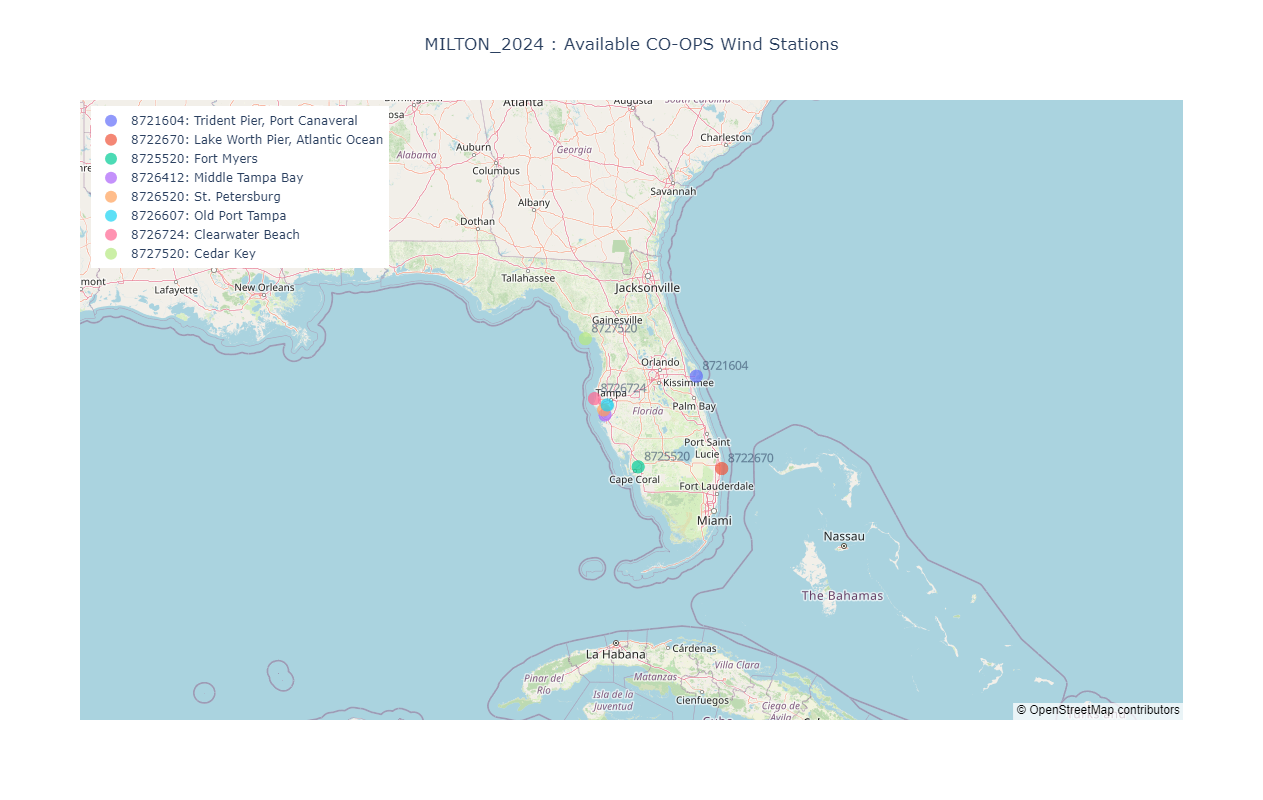

In [113]:
import plotly.express as px
import pandas as pd
import plotly.io as pio


# Create a new column in the DataFrame combining 'id' and 'Name' 
filtered_wind_stations['id-name'] = filtered_wind_stations['nos_id'].astype(str) + ': ' + filtered_wind_stations['name']

# Create the scatter mapbox plot with red points
fig = px.scatter_mapbox(
    filtered_wind_stations,
    lat='lat',
    lon='lon',
    center=dict(lat=filtered_wind_stations['lat'].mean(), lon=filtered_wind_stations['lon'].mean()),
    #color_discrete_sequence=['red'],  # Set the color of the points to red
    color = 'id-name',
    size=[1]*len(filtered_wind_stations),  # Adjust the size of the markers if needed
    size_max = 10,
    text= 'nos_id',
    hover_name='nos_id',
    hover_data=['nos_id', 'name'],
    title= f'{storm_track.name}_{storm_track.year} : Available CO-OPS Wind Stations',
    mapbox_style='open-street-map',  # Use OpenStreetMap for simplicity
    width=1000,  # Set the width of the figure
    height=800,  # Set the height of the figure
    zoom=5,  # Zoom level
)


fig.update_layout(
    
    title=dict(x=0.5),  # Center the title
    legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
)
)

fig.update_traces(textposition='top right')
fig.update_layout(legend=dict(title=None))



# Show the plot
fig.show()
fig.write_html("file.html")
#fig.write_image("fig2.png")



# Read STOFS-3D-Atl input wind data for nowcast

In [114]:
def read_netcdf_from_s3(bucket_name, key):
    """
    Function to read a NetCDF file from an S3 bucket using thalassa API.
    
    Parameters:
    - bucket_name: Name of the S3 bucket
    - key: Key/path to the NetCDF file in the bucket
    
    Returns:
    - ds: xarray Dataset containing the NetCDF data
    """
    s3 = s3fs.S3FileSystem(anon=True)
    url = f"s3://{bucket_name}/{key}"
    ds = xr.open_dataset(s3.open(url, 'rb'), drop_variables=['nvel'])
    return ds


In [115]:

date = date_range[0]

base_key = f'stofs_3d_atl.{date}'

filename = f'schout_adcirc_{date}.nc'
         
key = f'STOFS-3D-Atl/{base_key}/{filename}'

bucket_name = bucket_name_3d

dataset = read_netcdf_from_s3(bucket_name, key)  # the first 24 hr (240 time steps are the now cast data)



def  get_indices_of_nearest_nodes(ds: xr.Dataset, x: float, y: float, num_nodes: int ) -> List[int]:
    # https://www.unidata.ucar.edu/blogs/developer/en/entry/accessing_netcdf_data_by_coordinates
    # https://github.com/Unidata/python-workshop/blob/fall-2016/notebooks/netcdf-by-coordinates.ipynb
    dist = abs(ds.x - x) ** 2 + abs(ds.y - y) ** 2
    indices_of_nearest_nodes = dist.argsort()[:num_nodes]
    return indices_of_nearest_nodes.values

# Initialize an empty DataFrame to store the data
index = pd.DataFrame()

# Initialize an empty DataFrame to store the data
data = []

for nos_id, x, y in zip(filtered_wind_stations['nos_id'], filtered_wind_stations['lon'], filtered_wind_stations['lat']):
    index_values = get_indices_of_nearest_nodes(dataset, x, y,1)
    data.append({'nos_id': nos_id , 'index_value': index_values})

# Convert the list of dictionaries to a DataFrame
index = pd.DataFrame(data)
index_list = []

for i in range(0,len(index)):
  index_list.append(int(index.index_value[i][0]))



In [86]:
data

[{'nos_id': '8721604', 'index_value': array([1768690])},
 {'nos_id': '8722670', 'index_value': array([1679981])},
 {'nos_id': '8725520', 'index_value': array([1450114])},
 {'nos_id': '8726412', 'index_value': array([1402561])},
 {'nos_id': '8726520', 'index_value': array([1402878])},
 {'nos_id': '8726607', 'index_value': array([1393725])},
 {'nos_id': '8726724', 'index_value': array([1410258])},
 {'nos_id': '8727520', 'index_value': array([2525314])}]

In [87]:
index_list

[1768690, 1679981, 1450114, 1402561, 1402878, 1393725, 1410258, 2525314]

In [122]:


bucket_name = bucket_name_3d
start_date = datetime.strptime(date_range[0], '%Y%m%d')
#start_date -= timedelta(days=1)  # to include all nowcast data for the specified range
end_date = datetime.strptime(date_range[1], '%Y%m%d')
end_date += timedelta(days=1)  # to include all nowcast data for the specified range


dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYYMMDD
    current_date += timedelta(days=1)


wind_forecast_3d_all_list = []


for date in dates:
    print(date)
    base_key = f'stofs_3d_atl.{date}'
    previous_date = datetime.strptime(date, '%Y%m%d') - timedelta(days=1)
    filename = f'schout_adcirc_{previous_date.strftime("%Y%m%d")}.nc'
    key = f'STOFS-3D-Atl/{base_key}/{filename}'
    
    try:
        forecast_3d = read_netcdf_from_s3(bucket_name, key)
        
        # Calculate square root of sum of squares for uwind and vwind at specific points (nos_id)
        sqrt_uv_sum = np.sqrt(forecast_3d['uwind'][:, index_list]**2 + forecast_3d['vwind'][:, index_list]**2)
        
        # Store the result in a list
        wind_forecast_3d_all_list.append(sqrt_uv_sum)
        
    except Exception as e:
        print(f'Error reading file {key} from S3: {str(e)}')


# Concatenate all datasets along the time dimension
if wind_forecast_3d_all_list:
    wind_concat = xr.concat(wind_forecast_3d_all_list, dim='time')
else:
    print("No valid data found.")


wind_concat

20241004
20241005
20241006
20241007
20241008
20241009
20241010
20241011


<xarray.DataArray (time: 192, node: 8)> Size: 12kB
array([[4.9031562 , 1.58581738, 0.78648103, ..., 3.38904469, 2.59830747,
        5.13326115],
       [4.76802982, 3.24734149, 2.08911602, ..., 4.41120319, 3.74623147,
        5.09778556],
       [5.28507281, 2.69583382, 1.1215469 , ..., 4.33970595, 3.95530078,
        5.60738035],
       ...,
       [8.19672174, 4.41383783, 4.29599109, ..., 8.556999  , 6.21866606,
        6.61854648],
       [7.52577689, 5.09203161, 4.08854333, ..., 8.97917301, 6.98875041,
        6.75522218],
       [6.7668724 , 3.26766614, 3.84807977, ..., 8.14403654, 5.79120526,
        5.9597113 ]])
Coordinates:
  * time     (time) datetime64[ns] 2kB 2024-10-03T13:00:00 ... 2024-10-11T12:...
    x        (node) float64 64B -80.59 -80.04 -81.87 ... -82.55 -82.83 -83.03
    y        (node) float64 64B 28.42 26.61 26.65 27.66 27.76 27.86 27.98 29.13
Dimensions without coordinates: node

# Plot Nowcast wind 

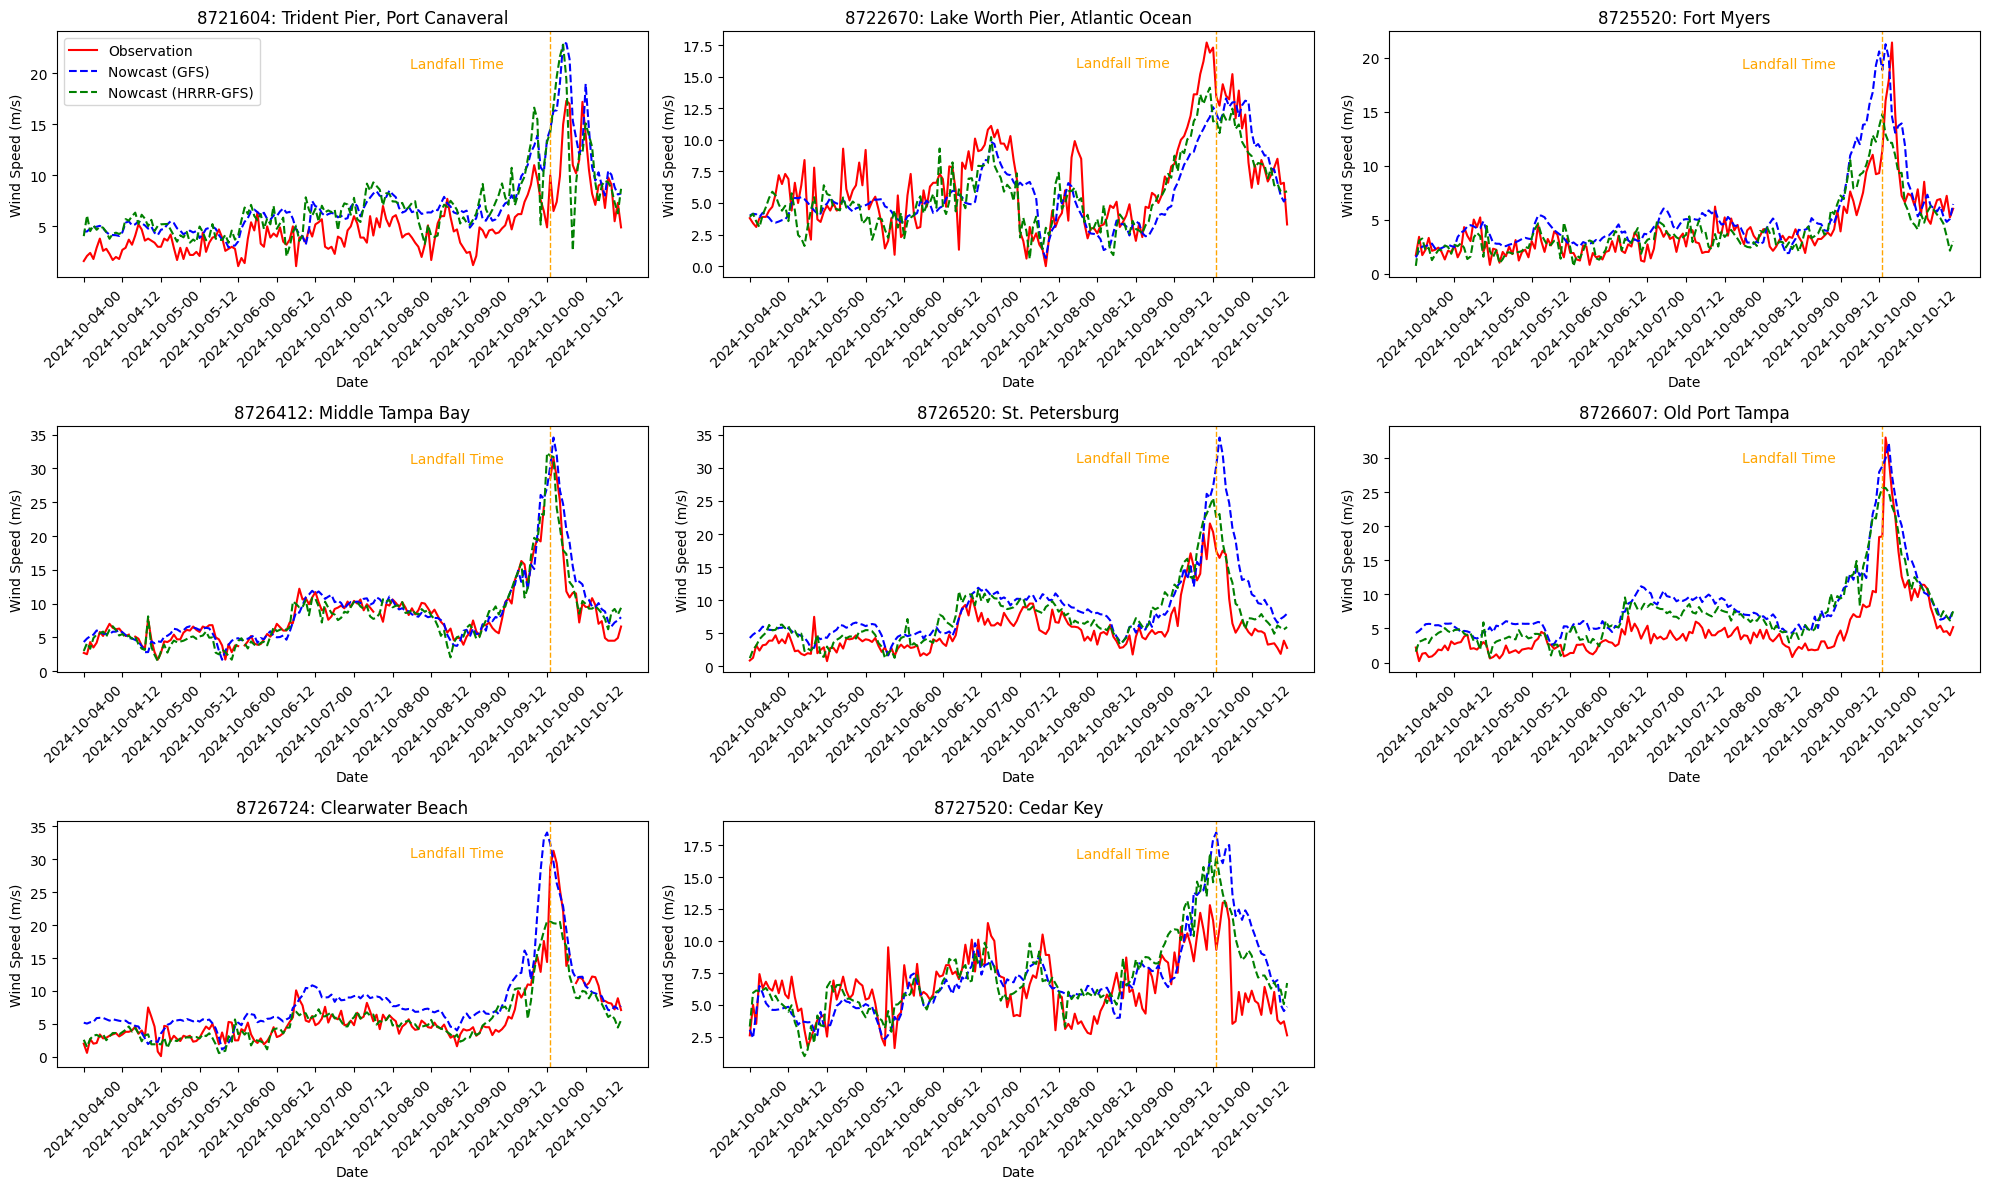

In [123]:

import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta

def convert_to_datetime(time_step):
    start_date = time_df['Time'][0]
    time_delta = timedelta(hours=1)  
    return start_date + time_step * time_delta

# Define the number of rows and columns for subplots (2 columns)
num_rows = 3
num_cols = 3

# Create a figure and axes array with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12))

index = 0
for row in range(num_rows):
    for col in range(num_cols):
        if index >= len(filtered_wind_stations):
            # If there are fewer stations than subplots, turn off unused subplots
            axs[row, col].axis('off')
            break
            
        
        nos_id = filtered_wind_stations['nos_id'][filtered_wind_stations.index[index]]
        ax = axs[row, col]
        
        # Plot data
        ax.plot(Wind_Observation_2d_Nowcast[index].values, label='Observation', color='red')

        ax.plot(np.sqrt(v_wind_dfs[int(nos_id)]**2 + u_wind_dfs[int(nos_id)]**2)[:len(Wind_Observation_2d_Nowcast[0])], label='Nowcast (GFS)', color='blue', linestyle='dashed')
        ax.plot(wind_concat[12:-12,index], label='Nowcast (HRRR-GFS)', color='green', linestyle='dashed')

        ax.set_title(f'{filtered_wind_stations['nos_id'][filtered_wind_stations.index[index]]}: {filtered_wind_stations['name'][filtered_wind_stations.index[index]]}')
        ax.set_xlabel('Date')
        
        # Set x ticks and labels
        ax.set_xticks(range(0, len(Wind_Observation_2d_Nowcast[0]), 12)) 
        time_steps = range(0, len(Wind_Observation_2d_Nowcast[0]))
        time_labels = [convert_to_datetime(step) for step in time_steps]
        selected_dates = time_labels[::12]
        ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)


        # Calculate the landfall time step
        start_date = datetime.strptime(date_range[0], '%Y%m%d')
        landfall_datetime = start_date + timedelta(hours=landfall_time_step)
 
        nowcast_wind_2d_landfall_time_step = None 
            
        for step, time_label in zip(time_steps, time_labels): 
                if time_label.replace(tzinfo = None) == landfall_datetime:
                    nowcast_wind_2d_landfall_time_step = step 
                    break


        
        ax.axvline(x=nowcast_wind_2d_landfall_time_step , color='orange', linestyle='--', linewidth=1)
        ax.text(nowcast_wind_2d_landfall_time_step * 0.8, ax.get_ylim()[1] * 0.85, 'Landfall Time', color='orange', ha='center')
        
        ax.set_ylabel('Wind Speed (m/s)')
        if row == 0 and col == 0:  # Place the legend in the top-left subplot to avoid overlapping
            ax.legend(loc='upper left')
        index += 1
            
          
# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('GFS_HRRR_Wind_nowcast.png')

# Display the plot
plt.show()



In [54]:
filtered_wind_stations['nos_id']

0     8721604
1     8722670
2     8725520
4     8726412
5     8726520
7     8726607
12    8726724
13    8727520
Name: nos_id, dtype: string

# Read GFS forecast data on the fly

In [124]:
start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = datetime.strptime(date_range[1], '%Y%m%d')
end_date += timedelta(days=1) # to include all nowcast data for the specified rage


# Find the forecast date
date = (start_date + timedelta(hours=landfall_time_step-Hours_before_landfall)).strftime('%Y%m%d')

# Find the Forecast cycle
date_H = int((start_date + timedelta(hours=landfall_time_step-Hours_before_landfall)).strftime('%H'))

cycle = None
for num in cycles_2d:
    if int(num) < date_H:
        if cycle is None or int(num) > cycle:
            cycle = int(num)
#cycle = f'{cycle:02}'

cycle = '12'

# Fetch GFS data
u_wind_dfs_forecast,v_wind_dfs_forecast, surface_pressure_dfs_forecast, all_times  = fetch_gfs_Forecast_data(date, cycle, filtered_wind_stations)

print(u_wind_dfs_forecast)
print(v_wind_dfs_forecast)
print(surface_pressure_dfs_forecast)
print(all_times)

0
s3://noaa-gfs-bdp-pds/gfs.20241008/06/atmos/gfs.t06z.sfluxgrbf000.grib2
2024-10-08 06:00:00
1
s3://noaa-gfs-bdp-pds/gfs.20241008/06/atmos/gfs.t06z.sfluxgrbf001.grib2
2024-10-08 07:00:00
2
s3://noaa-gfs-bdp-pds/gfs.20241008/06/atmos/gfs.t06z.sfluxgrbf002.grib2
2024-10-08 08:00:00
3
s3://noaa-gfs-bdp-pds/gfs.20241008/06/atmos/gfs.t06z.sfluxgrbf003.grib2
2024-10-08 09:00:00
4
s3://noaa-gfs-bdp-pds/gfs.20241008/06/atmos/gfs.t06z.sfluxgrbf004.grib2
2024-10-08 10:00:00
5
s3://noaa-gfs-bdp-pds/gfs.20241008/06/atmos/gfs.t06z.sfluxgrbf005.grib2
2024-10-08 11:00:00
6
s3://noaa-gfs-bdp-pds/gfs.20241008/12/atmos/gfs.t12z.sfluxgrbf000.grib2
2024-10-08 12:00:00
7
s3://noaa-gfs-bdp-pds/gfs.20241008/12/atmos/gfs.t12z.sfluxgrbf001.grib2
2024-10-08 13:00:00
8
s3://noaa-gfs-bdp-pds/gfs.20241008/12/atmos/gfs.t12z.sfluxgrbf002.grib2
2024-10-08 14:00:00
9
s3://noaa-gfs-bdp-pds/gfs.20241008/12/atmos/gfs.t12z.sfluxgrbf003.grib2
2024-10-08 15:00:00
10
s3://noaa-gfs-bdp-pds/gfs.20241008/12/atmos/gfs.t12z.sflu

In [56]:
date

'20241008'

In [125]:
# Convert all_times list to DataFrame 
time_df = pd.DataFrame({'Time': all_times}) # Print or use time_df as needed print(time_df)

time_df

Time
0   2024-10-08 06:00:00
1   2024-10-08 07:00:00
2   2024-10-08 08:00:00
3   2024-10-08 09:00:00
4   2024-10-08 10:00:00
..                  ...
182 2024-10-15 20:00:00
183 2024-10-15 21:00:00
184 2024-10-15 22:00:00
185 2024-10-15 23:00:00
186 2024-10-16 00:00:00

[187 rows x 1 columns]

In [189]:
 u_wind_dfs_forecast

8721604   8722670   8725520   8726412   8726520   8726607   8726724  \
0   -5.230000 -0.980000 -2.960000 -5.450000 -5.450000 -4.080000 -5.270000   
1   -5.180000 -0.130000 -1.840000 -5.190000 -5.190000 -4.220000 -4.760000   
2   -4.880000 -0.320000 -1.740000 -5.240000 -5.240000 -4.030000 -4.790000   
3   -4.390000  1.190000 -1.740000 -5.230000 -5.230000 -3.920000 -4.520000   
4   -4.800000  1.530000 -1.730000 -5.120000 -5.120000 -3.770000 -4.250000   
..        ...       ...       ...       ...       ...       ...       ...   
182 -2.636667 -1.626667  2.686667  1.883333  1.883333  2.823333  1.413333   
183 -1.900000 -1.890000  2.800000  2.030000  2.030000  3.100000  1.460000   
184 -2.003333 -2.120000  1.870000  2.066667  2.066667  2.736667  1.523333   
185 -2.106667 -2.350000  0.940000  2.103333  2.103333  2.373333  1.586667   
186 -2.210000 -2.580000  0.010000  2.140000  2.140000  2.010000  1.650000   

      8727520  
0   -3.510000  
1   -3.180000  
2   -2.850000  
3   -3.240000  
4   -3.310000  
..        ...  
182  5.716667  
183  6.000000  
184  3.136667  
185  0.273333  
186 -2.590000  

[187 rows x 8 columns]

In [190]:
v_wind_dfs_forecast

8721604   8722670   8725520   8726412   8726520   8726607   8726724  \
0   -3.670000 -4.470000 -2.050000 -6.390000 -6.390000 -5.720000 -4.930000   
1   -3.940000 -4.090000 -2.200000 -6.350000 -6.350000 -5.560000 -4.900000   
2   -4.420000 -3.570000 -2.280000 -6.110000 -6.110000 -5.640000 -4.910000   
3   -4.410000 -2.570000 -2.120000 -6.880000 -6.880000 -6.170000 -5.400000   
4   -4.080000 -2.080000 -2.430000 -6.490000 -6.490000 -6.060000 -5.880000   
..        ...       ...       ...       ...       ...       ...       ...   
182 -1.336667 -3.203333 -1.733333 -4.140000 -4.140000 -4.050000 -5.786667   
183 -1.300000 -3.210000 -2.170000 -5.760000 -5.760000 -5.520000 -5.800000   
184 -1.173333 -2.923333 -2.213333 -6.146667 -6.146667 -5.803333 -5.850000   
185 -1.046667 -2.636667 -2.256667 -6.533333 -6.533333 -6.086667 -5.900000   
186 -0.920000 -2.350000 -2.300000 -6.920000 -6.920000 -6.370000 -5.950000   

      8727520  
0   -4.610000  
1   -4.850000  
2   -5.170000  
3   -5.610000  
4   -5.510000  
..        ...  
182 -3.863333  
183 -4.220000  
184 -4.593333  
185 -4.966667  
186 -5.340000  

[187 rows x 8 columns]

In [191]:
surface_pressure_dfs_forecast

8721604        8722670        8725520        8726412  \
0    100569.930000  100329.930000  100449.930000  100611.530000   
1    100521.090000  100317.890000  100444.290000  100578.690000   
2    100475.340000  100270.540000  100411.340000  100560.140000   
3    100480.590000  100286.990000  100416.590000  100550.990000   
4    100493.410000  100299.810000  100423.010000  100562.210000   
..             ...            ...            ...            ...   
182  101185.320000  101064.263333  101041.320000  101184.786667   
183  101144.170000  101036.980000  101000.170000  101131.370000   
184  101173.157083  101075.023750  101040.357083  101168.357083   
185  101202.134167  101113.067500  101080.534167  101205.334167   
186  101231.111250  101151.111250  101120.711250  101242.311250   

           8726520        8726607       8726724        8727520  
0    100611.530000  100614.730000  100601.93000  100768.330000  
1    100578.690000  100578.690000  100578.69000  100735.490000  
2    100560.140000  100558.540000  100539.34000  100720.140000  
3    100550.990000  100552.590000  100534.99000  100696.590000  
4    100562.210000  100554.210000  100541.41000  100717.410000  
..             ...            ...           ...            ...  
182  101184.786667  101167.186667  101185.32000  101264.253333  
183  101131.370000  101118.570000  101137.77000  101209.770000  
184  101168.357083  101153.957083  101164.62375  101243.023750  
185  101205.334167  101189.334167  101191.46750  101276.267500  
186  101242.311250  101224.711250  101218.31125  101309.511250  

[187 rows x 8 columns]

In [61]:
v_wind_dfs_forecast

8721604   8722670   8725520   8726412   8726520   8726607   8726724  \
0   -3.670000 -4.470000 -2.050000 -6.390000 -6.390000 -5.720000 -4.930000   
1   -3.940000 -4.090000 -2.200000 -6.350000 -6.350000 -5.560000 -4.900000   
2   -4.420000 -3.570000 -2.280000 -6.110000 -6.110000 -5.640000 -4.910000   
3   -4.410000 -2.570000 -2.120000 -6.880000 -6.880000 -6.170000 -5.400000   
4   -4.080000 -2.080000 -2.430000 -6.490000 -6.490000 -6.060000 -5.880000   
..        ...       ...       ...       ...       ...       ...       ...   
182 -1.336667 -3.203333 -1.733333 -4.140000 -4.140000 -4.050000 -5.786667   
183 -1.300000 -3.210000 -2.170000 -5.760000 -5.760000 -5.520000 -5.800000   
184 -1.173333 -2.923333 -2.213333 -6.146667 -6.146667 -5.803333 -5.850000   
185 -1.046667 -2.636667 -2.256667 -6.533333 -6.533333 -6.086667 -5.900000   
186 -0.920000 -2.350000 -2.300000 -6.920000 -6.920000 -6.370000 -5.950000   

      8727520  
0   -4.610000  
1   -4.850000  
2   -5.170000  
3   -5.610000  
4   -5.510000  
..        ...  
182 -3.863333  
183 -4.220000  
184 -4.593333  
185 -4.966667  
186 -5.340000  

[187 rows x 8 columns]

In [62]:
time_df

Time
0   2024-10-08 06:00:00
1   2024-10-08 07:00:00
2   2024-10-08 08:00:00
3   2024-10-08 09:00:00
4   2024-10-08 10:00:00
..                  ...
182 2024-10-15 20:00:00
183 2024-10-15 21:00:00
184 2024-10-15 22:00:00
185 2024-10-15 23:00:00
186 2024-10-16 00:00:00

[187 rows x 1 columns]

# Get Observation Data for forecast Data

In [126]:
# Initialize an empty DataFrame to store the data
Wind_Observation_2d_forecast= []

# Loop over each nos_id
for nos_id in filtered_wind_stations['nos_id']:
   
       # Retrieve wind information for the specified date range
       station_wind = fetch_coops_station(
       station_id=nos_id,
       start_date=time_df['Time'][0],
       end_date=time_df['Time'][len(time_df)-1],
       product='wind',  interval='h')
      

       # Add the data for the current station to the result DataFrame
       #station_wind = station_wind.reset_index()
       Wind_Observation_2d_forecast.append(station_wind['speed'])
Wind_Observation_2d_forecast

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/en

[time
 2024-10-08 06:00:00+00:00    3.9
 2024-10-08 07:00:00+00:00    3.4
 2024-10-08 08:00:00+00:00    3.0
 2024-10-08 09:00:00+00:00    2.0
 2024-10-08 10:00:00+00:00    3.2
                             ... 
 2024-10-15 15:00:00+00:00    2.5
 2024-10-15 16:00:00+00:00    2.4
 2024-10-15 17:00:00+00:00    2.6
 2024-10-15 18:00:00+00:00    2.8
 2024-10-15 19:00:00+00:00    2.2
 Name: speed, Length: 182, dtype: float64,
 time
 2024-10-08 06:00:00+00:00    9.1
 2024-10-08 07:00:00+00:00    8.5
 2024-10-08 08:00:00+00:00    3.4
 2024-10-08 09:00:00+00:00    2.2
 2024-10-08 10:00:00+00:00    3.0
                             ... 
 2024-10-15 15:00:00+00:00    2.6
 2024-10-15 16:00:00+00:00    2.9
 2024-10-15 17:00:00+00:00    2.3
 2024-10-15 18:00:00+00:00    0.7
 2024-10-15 19:00:00+00:00    3.1
 Name: speed, Length: 182, dtype: float64,
 time
 2024-10-08 06:00:00+00:00    2.7
 2024-10-08 07:00:00+00:00    4.0
 2024-10-08 08:00:00+00:00    4.3
 2024-10-08 09:00:00+00:00    3.5
 2024-10-08 

In [127]:
# Read STOFS-3d-Atlantic


bucket_name = bucket_name_3d
start_date = datetime.strptime(date_range[0], '%Y%m%d')


# Find the forecast date

dates = []

forecast_date = (start_date + timedelta(hours=landfall_time_step-Hours_before_landfall)).strftime('%Y%m%d')
end_date = datetime.strptime(forecast_date, '%Y%m%d') + timedelta(days=5) # Forecast data provided in each STOFS-3D-Atl cycle

current_date = datetime.strptime(forecast_date, '%Y%m%d')-timedelta(days=1) #starting from nowcast data
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYYMMDD
    current_date += timedelta(days=1)


wind_forecast_3d_all_list = []

for date in dates:
    print(date)
    base_key = f'stofs_3d_atl.{forecast_date}'
    filename = f'schout_adcirc_{date}.nc'
    key = f'STOFS-3D-Atl/{base_key}/{filename}'
    
    try:
        wind_forecast_3d = read_netcdf_from_s3(bucket_name, key)
        
        # Calculate square root of sum of squares for uwind and vwind at specific points (nos_id)
        sqrt_uv_sum = np.sqrt(wind_forecast_3d['uwind'][:, index_list]**2 + wind_forecast_3d['vwind'][:, index_list]**2)
        
        # Store the result in a list
        wind_forecast_3d_all_list.append(sqrt_uv_sum)
        
    except Exception as e:
        print(f'Error reading file {key} from S3: {str(e)}')


# Concatenate all datasets along the time dimension
if wind_forecast_3d_all_list:
    wind_concat_forecast = xr.concat(wind_forecast_3d_all_list, dim='time')
else:
    print("No valid data found.")


wind_concat_forecast


20241007
20241008
20241009
20241010
20241011
20241012
Error reading file STOFS-3D-Atl/stofs_3d_atl.20241008/schout_adcirc_20241012.nc from S3: noaa-nos-stofs3d-pds/STOFS-3D-Atl/stofs_3d_atl.20241008/schout_adcirc_20241012.nc
20241013
Error reading file STOFS-3D-Atl/stofs_3d_atl.20241008/schout_adcirc_20241013.nc from S3: noaa-nos-stofs3d-pds/STOFS-3D-Atl/stofs_3d_atl.20241008/schout_adcirc_20241013.nc


<xarray.DataArray (time: 120, node: 8)> Size: 8kB
array([[ 7.79489672,  2.27296417,  3.58597752, 10.23933135, 10.163625  ,
         8.03612231,  6.01077157,  6.30621391],
       [ 5.70301831,  3.82882567,  5.29216217, 10.22064333, 10.25689478,
         8.57489068,  6.88546914,  6.49491738],
       [ 5.42769709,  2.73839223,  2.90543304,  9.56686649,  8.64268035,
         7.3438421 ,  5.81388525,  7.79793633],
       [ 6.89916148,  0.57653986,  3.99519427,  9.21608372,  8.60078919,
         7.18348282,  6.3517135 ,  9.81054645],
       [ 9.19059951,  3.12706218,  4.91649752,  9.64461386,  9.0666496 ,
         8.13593967,  6.75986536,  8.33289168],
       [ 8.49722628,  3.91689873,  3.7821979 ,  8.10039291,  8.4575796 ,
         7.41075752,  6.25071214,  8.19326409],
       [ 9.30773682,  2.23316236,  3.85394267,  7.73277679,  8.27054945,
         7.26990786,  6.42644007,  9.1739925 ],
       [ 8.95309032,  1.3683746 ,  2.47408542,  7.91734777,  8.04394878,
         6.99166926,  4.89708745,  6.83999864],
       [ 8.59830705,  3.04014434,  2.2540039 ,  8.5859424 ,  8.99072297,
         6.76502985,  5.43473283,  6.93301538],
       [ 7.05701509,  2.44695013,  3.65673902, 10.63206226,  9.35068025,
         7.38162748,  5.25431776,  6.64305724],
...
       [ 8.56420704,  5.67258239,  5.10554762,  8.92416296,  8.46297595,
         7.73423802,  8.69289862,  4.72533057],
       [ 8.0515549 ,  5.45403384,  5.32042815,  8.7495936 ,  8.27908824,
         7.51590929,  8.49012738,  4.88806871],
       [ 7.15699469,  5.22444395,  5.02759913,  8.26668671,  7.77255425,
         6.94712953,  7.9277549 ,  4.75454766],
       [ 5.91744574,  5.14040875,  4.86408779,  7.94859958,  7.54285588,
         6.69148185,  7.61944934,  4.60704135],
       [ 5.59116482,  5.02500059,  4.80217926,  7.86366597,  7.39016585,
         6.50355669,  7.35034802,  4.80150571],
       [ 5.40202069,  4.89446187,  4.54889092,  7.76797207,  7.29669279,
         6.43225208,  7.16765998,  4.92202202],
       [ 5.65816783,  4.85729167,  4.38158496,  7.38579699,  6.95471285,
         6.16857298,  7.1079016 ,  4.70682649],
       [ 5.63570244,  5.08452649,  4.37999334,  7.05681232,  6.64636045,
         5.87551768,  6.8850476 ,  4.71499594],
       [ 5.81851367,  5.42136807,  4.18807957,  6.93176337,  6.44740207,
         5.69355354,  6.5243281 ,  4.74624151],
       [ 5.83171941,  5.54298437,  4.09544639,  7.02174296,  6.48909674,
         5.74996617,  6.32760239,  4.75743061]])
Coordinates:
  * time     (time) datetime64[ns] 960B 2024-10-07T13:00:00 ... 2024-10-12T12...
    x        (node) float64 64B -80.59 -80.04 -81.87 ... -82.55 -82.83 -83.03
    y        (node) float64 64B 28.42 26.61 26.65 27.66 27.76 27.86 27.98 29.13
Dimensions without coordinates: node

In [65]:
end_date

datetime.datetime(2024, 10, 13, 0, 0)

In [66]:
forecast_date

'20241008'

# Plot GFS forecast 

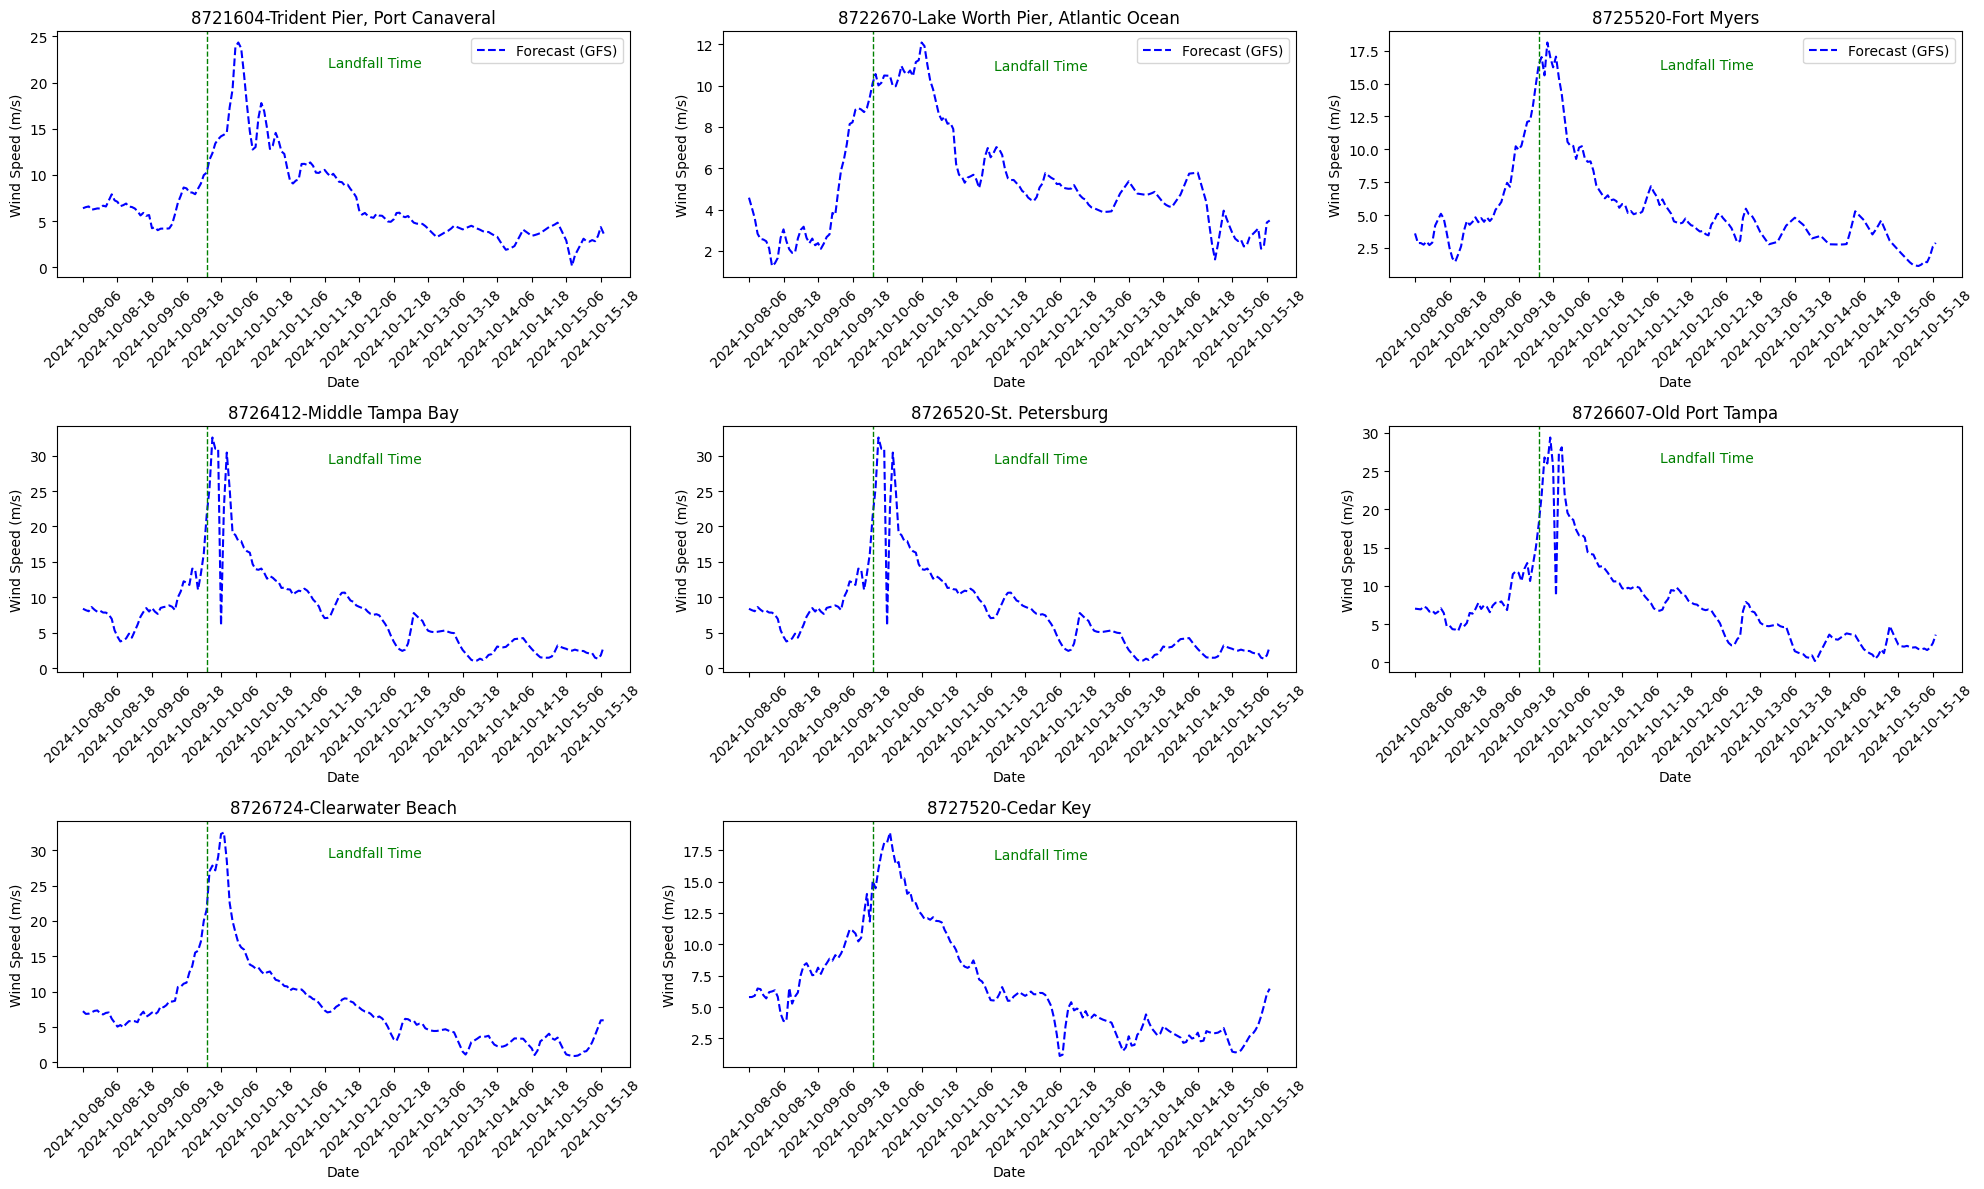

In [130]:

def convert_to_datetime(time_step):
    start_date = time_df['Time'][0]
    time_delta = timedelta(hours=1)  
    return start_date + time_step * time_delta


# Define the number of rows and columns for subplots
num_rows = 3
num_cols = 3


# Create a figure and axes array with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12))



index = 0
for row in range(num_rows):
    for col in range(num_cols):
        if index >= len(filtered_wind_stations['nos_id']):
            axs[row, col].axis('off')
            break
            
        
        nos_id = filtered_wind_stations['nos_id'][filtered_wind_stations.index[index]]
        ax = axs[row, col]
        #ax.plot(Wind_Observation_2d_forecast[index].values, label='Observation', color='red')
        
        ax.plot(np.sqrt(u_wind_dfs_forecast[int(nos_id)]**2 + v_wind_dfs_forecast[int(nos_id)]**2)[:len(Wind_Observation_2d_forecast[0])], label='Forecast (GFS)', color='blue',linestyle='dashed')
      

        ax.set_title(f'{filtered_wind_stations['nos_id'][filtered_wind_stations.index[index]]}-{filtered_wind_stations['name'][filtered_wind_stations.index[index]]}')
        ax.set_xlabel('Date')

        # Set x ticks and labels
        ax.set_xticks(range(0, len(Wind_Observation_2d_forecast[0]), 12)) 
        time_steps = range(0, len(Wind_Observation_2d_forecast[0]))
        time_labels = [convert_to_datetime(step) for step in time_steps]

        # Calculate the landfall time step
        start_date = datetime.strptime(date_range[0], '%Y%m%d')
        landfall_datetime = start_date + timedelta(hours=landfall_time_step)
 
        forecast_2d_landfall_time_step = None 
    
        for step, time_label in zip(time_steps, time_labels): 

            if time_label == landfall_datetime:
                 forecast_2d_landfall_time_step = step 
                 break   
        

        selected_dates = time_labels[::12]
        ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
        
        ax.axvline(x=forecast_2d_landfall_time_step, color='green', linestyle='--', linewidth=1)
        ax.text(landfall_time_step*0.7, ax.get_ylim()[1]*0.85, 'Landfall Time', color='green', ha='center')
        
        ax.set_ylabel('Wind Speed (m/s)')
        if row == 0:
           ax.legend(loc='upper right')
        
        index += 1


# Adjust layout
plt.tight_layout()


# Save the figure
plt.savefig('GFS_Wind_Forecasting.png')


# Display the plot
plt.show()





In [132]:
np.sqrt(u_wind_dfs_forecast[int('8726412')]**2 + v_wind_dfs_forecast[int('8726412')]**2)[:len(Wind_Observation_2d_forecast[0])]

0      8.398488
1      8.201134
2      8.049205
3      8.642181
4      8.266468
         ...   
177    2.138434
178    1.504427
179    1.360772
180    1.827047
181    3.060459
Name: 8726412, Length: 182, dtype: float64

In [133]:
np.sqrt(u_wind_dfs_forecast[int('8726520')]**2 + v_wind_dfs_forecast[int('8726520')]**2)[:len(Wind_Observation_2d_forecast[0])]

0      8.398488
1      8.201134
2      8.049205
3      8.642181
4      8.266468
         ...   
177    2.138434
178    1.504427
179    1.360772
180    1.827047
181    3.060459
Name: 8726520, Length: 182, dtype: float64

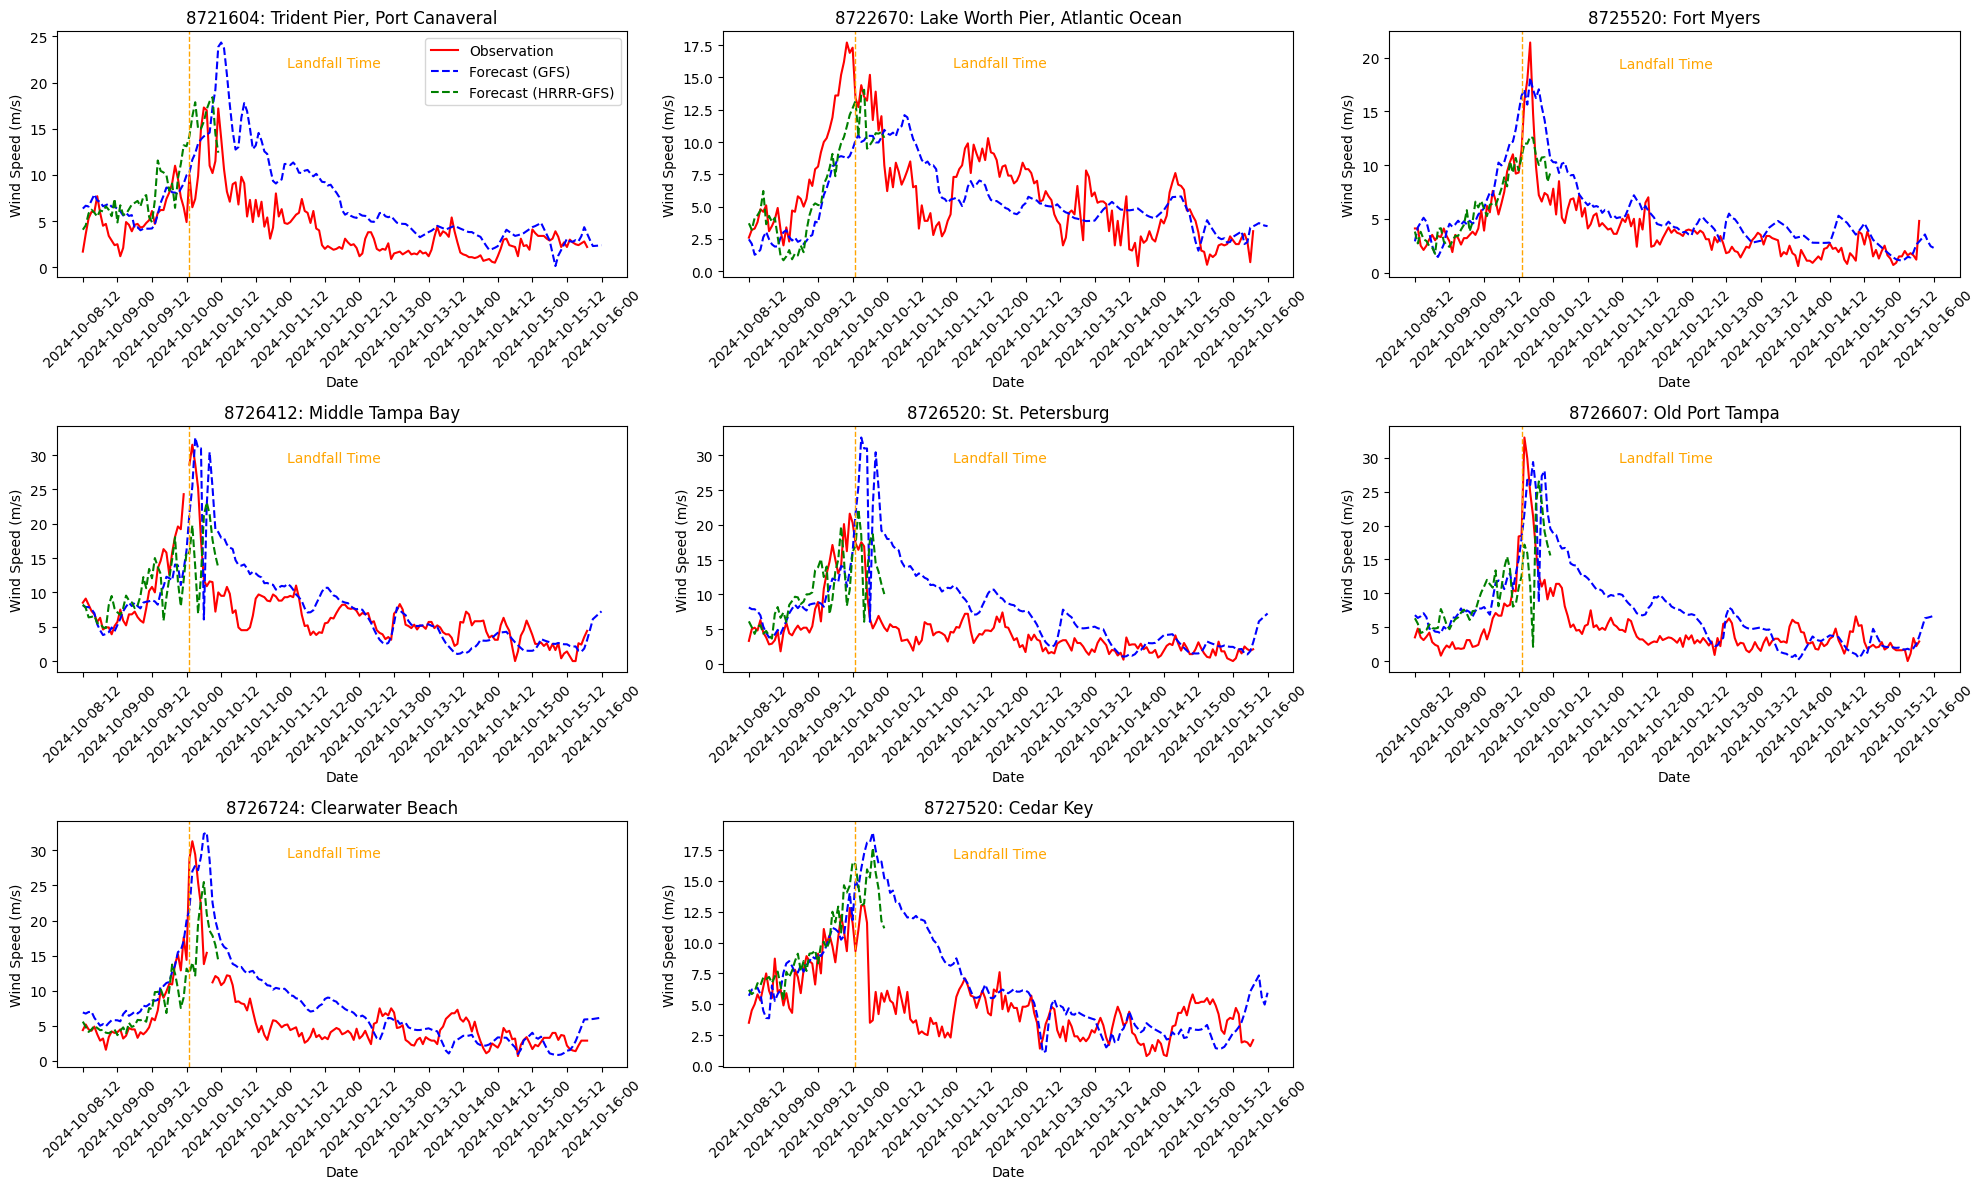

In [140]:

def convert_to_datetime(time_step):
    start_date = time_df['Time'][6]
    time_delta = timedelta(hours=1)  
    return start_date + time_step * time_delta


# Define the number of rows and columns for subplots
num_rows = 3
num_cols = 3


# Create a figure and axes array with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12))



index = 0
for row in range(num_rows):
    for col in range(num_cols):
        if index >= len(filtered_wind_stations['nos_id']):
            axs[row, col].axis('off')
            break
            
        
        nos_id = filtered_wind_stations['nos_id'][filtered_wind_stations.index[index]]
        ax = axs[row, col]
        ax.plot(Wind_Observation_2d_forecast[index].values[6:], label='Observation', color='red')
        
        ax.plot(np.sqrt(u_wind_dfs_forecast[int(nos_id)]**2 + v_wind_dfs_forecast[int(nos_id)]**2)[6:].values, label='Forecast (GFS)', color='blue',linestyle='dashed')
        ax.plot(wind_concat_forecast[24:,index], label='Forecast (HRRR-GFS)', color='green', linestyle='dashed')


        ax.set_title(f'{filtered_wind_stations['nos_id'][filtered_wind_stations.index[index]]}: {filtered_wind_stations['name'][filtered_wind_stations.index[index]]}')
        ax.set_xlabel('Date')

        # Set x ticks and labels
        ax.set_xticks(range(0, len(u_wind_dfs_forecast[int(nos_id)][6:]), 12)) 
        time_steps = range(0, len(u_wind_dfs_forecast[int(nos_id)][6:]))
        time_labels = [convert_to_datetime(step) for step in time_steps]

        # Calculate the landfall time step
        start_date = datetime.strptime(date_range[0], '%Y%m%d')
        landfall_datetime = start_date + timedelta(hours=landfall_time_step)
 
        forecast_2d_landfall_time_step = None 
    
        for step, time_label in zip(time_steps, time_labels): 

            if time_label == landfall_datetime:
                 forecast_2d_landfall_time_step = step 
                 break   
        

        selected_dates = time_labels[::12]
        ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
        
        ax.axvline(x=forecast_2d_landfall_time_step, color='orange', linestyle='--', linewidth=1)
        ax.text(landfall_time_step*0.6, ax.get_ylim()[1]*0.85, 'Landfall Time', color='orange', ha='center')
        
        ax.set_ylabel('Wind Speed (m/s)')
        if row == 0 and col == 0:
           ax.legend(loc='upper right')
        
        index += 1


# Adjust layout
plt.tight_layout()


# Save the figure
plt.savefig('GFS_HRRR_Wind_Forecasting.png')


# Display the plot
plt.show()





In [69]:
time_labels = [convert_to_datetime(step) for step in time_steps]
time_labels
selected_dates = time_labels[::12]
selected_dates

[Timestamp('2024-10-08 12:00:00'),
 Timestamp('2024-10-09 00:00:00'),
 Timestamp('2024-10-09 12:00:00'),
 Timestamp('2024-10-10 00:00:00'),
 Timestamp('2024-10-10 12:00:00'),
 Timestamp('2024-10-11 00:00:00'),
 Timestamp('2024-10-11 12:00:00'),
 Timestamp('2024-10-12 00:00:00'),
 Timestamp('2024-10-12 12:00:00'),
 Timestamp('2024-10-13 00:00:00'),
 Timestamp('2024-10-13 12:00:00'),
 Timestamp('2024-10-14 00:00:00'),
 Timestamp('2024-10-14 12:00:00'),
 Timestamp('2024-10-15 00:00:00'),
 Timestamp('2024-10-15 12:00:00'),
 Timestamp('2024-10-16 00:00:00')]

# Read STOFS-3D-Atl input wind data for nowcast

In [70]:
def read_netcdf_from_s3(bucket_name, key):
    """
    Function to read a NetCDF file from an S3 bucket using thalassa API.
    
    Parameters:
    - bucket_name: Name of the S3 bucket
    - key: Key/path to the NetCDF file in the bucket
    
    Returns:
    - ds: xarray Dataset containing the NetCDF data
    """
    s3 = s3fs.S3FileSystem(anon=True)
    url = f"s3://{bucket_name}/{key}"
    ds = xr.open_dataset(s3.open(url, 'rb'), drop_variables=['nvel'])
    return ds


In [91]:

date = date_range[0]

base_key = f'stofs_3d_atl.{date}'

filename = f'schout_adcirc_{date}.nc'
         
key = f'STOFS-3D-Atl/{base_key}/{filename}'

bucket_name = bucket_name_3d

dataset = read_netcdf_from_s3(bucket_name, key)  # the first 24 hr (240 time steps are the now cast data)


def  get_indices_of_nearest_nodes(ds: xr.Dataset, x: float, y: float, num_nodes: int ) -> List[int]:
    # https://www.unidata.ucar.edu/blogs/developer/en/entry/accessing_netcdf_data_by_coordinates
    # https://github.com/Unidata/python-workshop/blob/fall-2016/notebooks/netcdf-by-coordinates.ipynb
    dist = abs(ds.x - x) ** 2 + abs(ds.y - y) ** 2
    indices_of_nearest_nodes = dist.argsort()[:num_nodes]
    return indices_of_nearest_nodes.values

# Initialize an empty DataFrame to store the data
index = pd.DataFrame()

# Initialize an empty DataFrame to store the data
data = []

for nos_id, x, y in zip(filtered_wind_stations['nos_id'], filtered_wind_stations['lon'], filtered_wind_stations['lat']):
    index_values = get_indices_of_nearest_nodes(dataset, x, y,1)
    data.append({'nos_id': nos_id , 'index_value': index_values})

# Convert the list of dictionaries to a DataFrame
index = pd.DataFrame(data)
index_list = []

for i in range(0,len(index)):
  index_list.append(int(index.index_value[i][0]))



In [95]:
index_list

[1768690, 1679981, 1450114, 1402561, 1402878, 1393725, 1410258, 2525314]

In [92]:

# Read STOFS-3d-Atlantic


bucket_name = bucket_name_3d
start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = datetime.strptime(date_range[1], '%Y%m%d')
end_date += timedelta(days=1)  # to include all nowcast data for the specified range


dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYYMMDD
    current_date += timedelta(days=1)


wind_forecast_3d_all_list = []


for date in dates:
    print(date)
    base_key = f'stofs_3d_atl.{date}'
    previous_date = datetime.strptime(date, '%Y%m%d') - timedelta(days=1)
    filename = f'schout_adcirc_{previous_date.strftime("%Y%m%d")}.nc'
    key = f'STOFS-3D-Atl/{base_key}/{filename}'
    
    try:
        forecast_3d = read_netcdf_from_s3(bucket_name, key)
        
        # Calculate square root of sum of squares for uwind and vwind at specific points (nos_id)
        sqrt_uv_sum = np.sqrt(forecast_3d['uwind'][:, index_list]**2 + forecast_3d['vwind'][:, index_list]**2)
        
        # Store the result in a list
        wind_forecast_3d_all_list.append(sqrt_uv_sum)
        
    except Exception as e:
        print(f'Error reading file {key} from S3: {str(e)}')


# Concatenate all datasets along the time dimension
if wind_forecast_3d_all_list:
    wind_concat = xr.concat(wind_forecast_3d_all_list, dim='time')
else:
    print("No valid data found.")


wind_concat


20241004
20241005
20241006
20241007
20241008
20241009
20241010
20241011


<xarray.DataArray (time: 192, node: 8)> Size: 12kB
array([[4.9031562 , 1.58581738, 0.78648103, ..., 3.38904469, 2.59830747,
        5.13326115],
       [4.76802982, 3.24734149, 2.08911602, ..., 4.41120319, 3.74623147,
        5.09778556],
       [5.28507281, 2.69583382, 1.1215469 , ..., 4.33970595, 3.95530078,
        5.60738035],
       ...,
       [8.19672174, 4.41383783, 4.29599109, ..., 8.556999  , 6.21866606,
        6.61854648],
       [7.52577689, 5.09203161, 4.08854333, ..., 8.97917301, 6.98875041,
        6.75522218],
       [6.7668724 , 3.26766614, 3.84807977, ..., 8.14403654, 5.79120526,
        5.9597113 ]])
Coordinates:
  * time     (time) datetime64[ns] 2kB 2024-10-03T13:00:00 ... 2024-10-11T12:...
    x        (node) float64 64B -80.59 -80.04 -81.87 ... -82.55 -82.83 -83.03
    y        (node) float64 64B 28.42 26.61 26.65 27.66 27.76 27.86 27.98 29.13
Dimensions without coordinates: node

# Read Wind_observation_data for STOFS-3D-Atl

In [93]:
# Initialize an empty DataFrame to store the data
Wind_Observation_3d_nowcast= []

# Loop over each nos_id
for nos_id in filtered_wind_stations['nos_id']:
   
       # Retrieve wind information for the specified date range
       station_wind = fetch_coops_station(
       station_id=nos_id,
       start_date=wind_concat['time'].values[0],
       end_date=wind_concat['time'].values[-1],
       product='wind',  interval='h')
      

       # Add the data for the current station to the result DataFrame
       #station_wind = station_wind.reset_index()
       Wind_Observation_3d_nowcast.append(station_wind['speed'])
Wind_Observation_3d_nowcast

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time

/lustre/en

[time
 2024-10-03 13:00:00+00:00    2.9
 2024-10-03 14:00:00+00:00    4.7
 2024-10-03 15:00:00+00:00    3.5
 2024-10-03 16:00:00+00:00    5.0
 2024-10-03 17:00:00+00:00    4.7
                             ... 
 2024-10-11 08:00:00+00:00    5.5
 2024-10-11 09:00:00+00:00    6.3
 2024-10-11 10:00:00+00:00    4.8
 2024-10-11 11:00:00+00:00    4.7
 2024-10-11 12:00:00+00:00    4.9
 Name: speed, Length: 192, dtype: float64,
 time
 2024-10-03 13:00:00+00:00    1.0
 2024-10-03 14:00:00+00:00    0.7
 2024-10-03 15:00:00+00:00    3.3
 2024-10-03 16:00:00+00:00    2.3
 2024-10-03 17:00:00+00:00    2.8
                             ... 
 2024-10-11 08:00:00+00:00    3.1
 2024-10-11 09:00:00+00:00    3.9
 2024-10-11 10:00:00+00:00    4.4
 2024-10-11 11:00:00+00:00    7.3
 2024-10-11 12:00:00+00:00    7.3
 Name: speed, Length: 192, dtype: float64,
 time
 2024-10-03 13:00:00+00:00    2.8
 2024-10-03 14:00:00+00:00    2.4
 2024-10-03 15:00:00+00:00    2.3
 2024-10-03 16:00:00+00:00    2.0
 2024-10-03 

# Plot Wind nowcast data for STOFS-3D-Atl

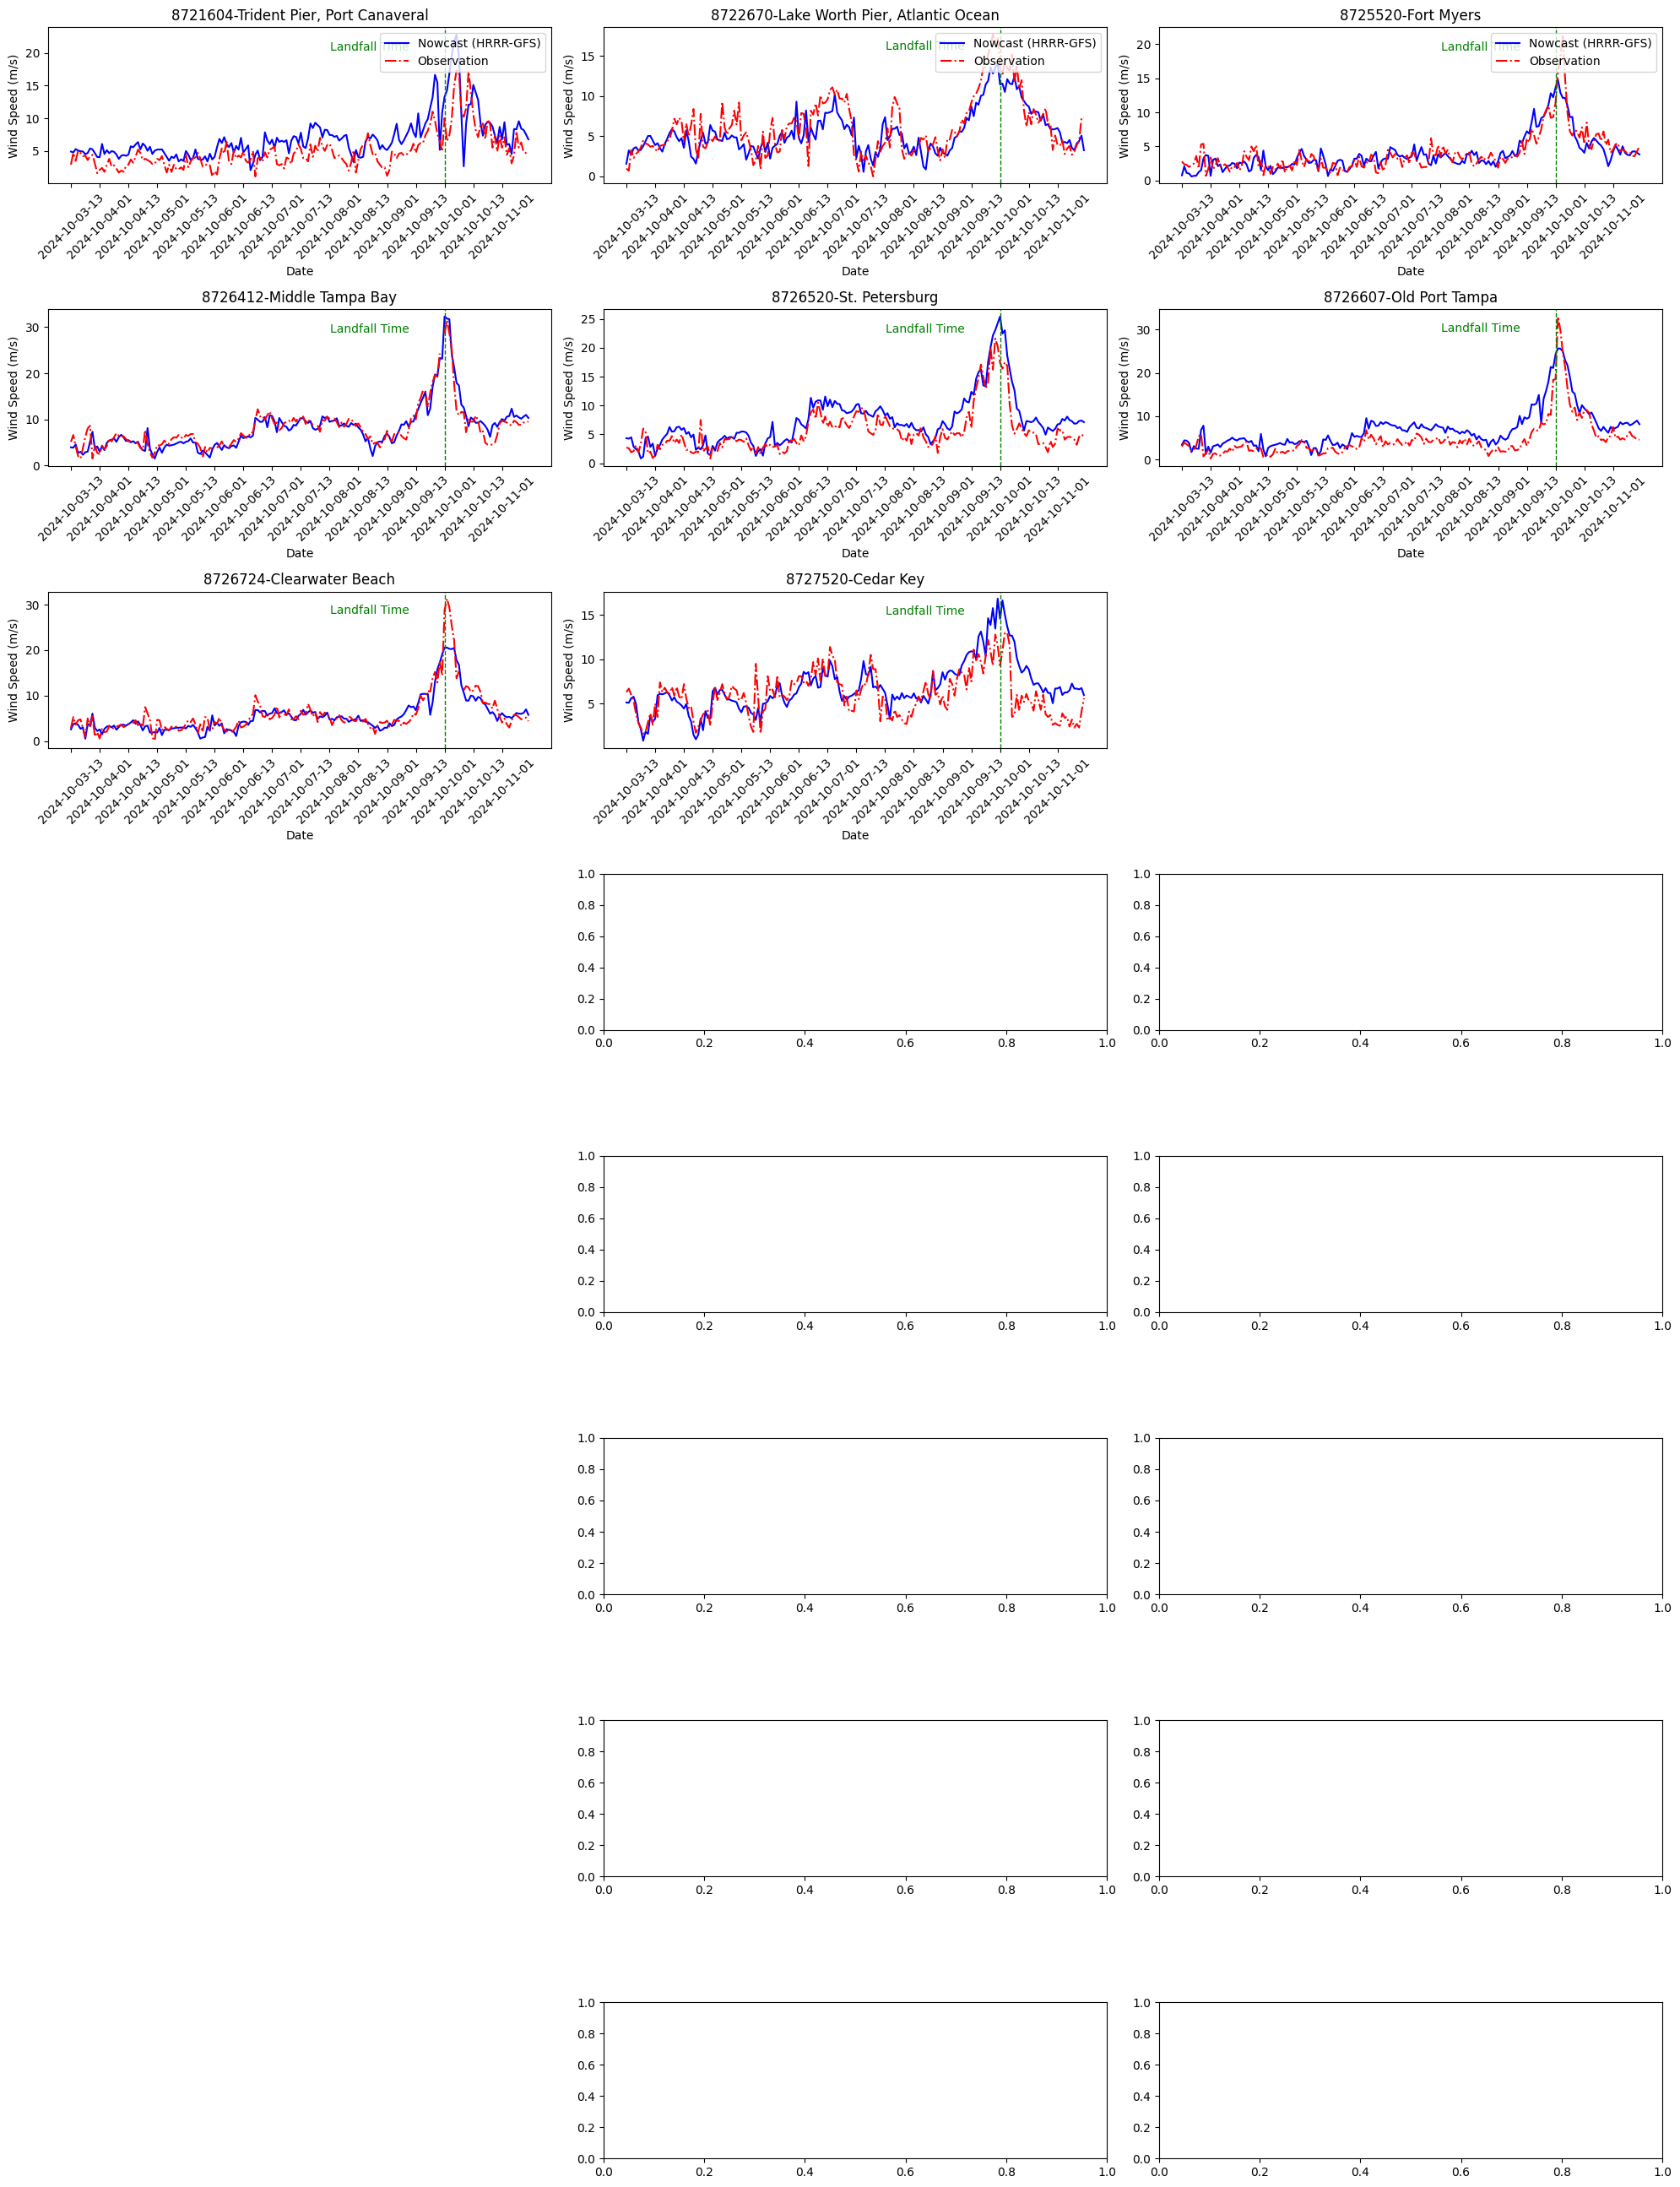

In [94]:

def convert_to_datetime(time_step):
    start_date = datetime.fromtimestamp(wind_concat['time'].values[0].astype(int) * 1e-9, tz=timezone.utc)
    time_delta = timedelta(hours=1)  
    return start_date + time_step * time_delta


# Define the number of rows and columns for subplots
num_rows = 8
num_cols = 3


# Create a figure and axes array with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 26))



index = 0
for row in range(num_rows):
    for col in range(num_cols):
        if index >= len(filtered_wind_stations['nos_id']):
            axs[row, col].axis('off')
            break
        
        nos_id = filtered_wind_stations['nos_id'][filtered_wind_stations.index[index]]
        ax = axs[row, col]
        
        ax.plot(wind_concat[:,index], label='Nowcast (HRRR-GFS)', color='blue')
        ax.plot(Wind_Observation_3d_nowcast[index].values, label='Observation', color='red',linestyle='dashdot')


        ax.set_title(f'{filtered_wind_stations['nos_id'][filtered_wind_stations.index[index]]}-{filtered_wind_stations['name'][filtered_wind_stations.index[index]]}')
        ax.set_xlabel('Date')

        # Set x ticks and labels
        ax.set_xticks(range(0, len(Wind_Observation_3d_nowcast[0]), 12)) 
        time_steps = range(0, len(Wind_Observation_3d_nowcast[0]))
        time_labels = [convert_to_datetime(step) for step in time_steps]
        
        # Calculate the landfall time step
        start_date = datetime.strptime(date_range[0], '%Y%m%d')
        landfall_datetime = start_date + timedelta(hours=landfall_time_step)
 
        nowcast_3d_landfall_time_step = None 

        for step, time_label in zip(time_steps, time_labels): 

            if time_label.replace(tzinfo = None) == landfall_datetime:
               nowcast_3d_landfall_time_step = step 
               break 

        selected_dates = time_labels[::12]
        ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
        ax.axvline(x=nowcast_3d_landfall_time_step, color='green', linestyle='--', linewidth=1)
        ax.text(nowcast_3d_landfall_time_step*0.8, ax.get_ylim()[1]*0.85, 'Landfall Time', color='green', ha='center')
        
        ax.set_ylabel('Wind Speed (m/s)')
        if row == 0:
           ax.legend(loc='upper right')
        
        index += 1


# Adjust layout
plt.tight_layout()


# Save the figure
plt.savefig('STOFS_3D_Wind_Nowcast.png')

# Display the plot
plt.show()




# Read wind Forecast from STOFS-3D-Atl

In [136]:
# Read STOFS-3d-Atlantic


bucket_name = bucket_name_3d
start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = start_date + timedelta(days=5) # Forecast data provided in each STOFS-3D-Atl cycle


# Find the forecast date

dates = []

forecast_date = (start_date + timedelta(hours=landfall_time_step-Hours_before_landfall)).strftime('%Y%m%d')

current_date = datetime.strptime(forecast_date, '%Y%m%d')-timedelta(days=1) #starting from nowcast data
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYYMMDD
    current_date += timedelta(days=1)


wind_forecast_3d_all_list = []

for date in dates:
    print(date)
    base_key = f'stofs_3d_atl.{forecast_date}'
    filename = f'schout_adcirc_{date}.nc'
    key = f'STOFS-3D-Atl/{base_key}/{filename}'
    
    try:
        wind_forecast_3d = read_netcdf_from_s3(bucket_name, key)
        
        # Calculate square root of sum of squares for uwind and vwind at specific points (nos_id)
        sqrt_uv_sum = np.sqrt(wind_forecast_3d['uwind'][:, index_list]**2 + wind_forecast_3d['vwind'][:, index_list]**2)
        
        # Store the result in a list
        wind_forecast_3d_all_list.append(sqrt_uv_sum)
        
    except Exception as e:
        print(f'Error reading file {key} from S3: {str(e)}')


# Concatenate all datasets along the time dimension
if wind_forecast_3d_all_list:
    wind_concat_forecast = xr.concat(wind_forecast_3d_all_list, dim='time')
else:
    print("No valid data found.")


wind_concat_forecast


20241007
20241008
20241009


<xarray.DataArray (time: 72, node: 8)> Size: 5kB
array([[ 7.79489672,  2.27296417,  3.58597752, 10.23933135, 10.163625  ,
         8.03612231,  6.01077157,  6.30621391],
       [ 5.70301831,  3.82882567,  5.29216217, 10.22064333, 10.25689478,
         8.57489068,  6.88546914,  6.49491738],
       [ 5.42769709,  2.73839223,  2.90543304,  9.56686649,  8.64268035,
         7.3438421 ,  5.81388525,  7.79793633],
       [ 6.89916148,  0.57653986,  3.99519427,  9.21608372,  8.60078919,
         7.18348282,  6.3517135 ,  9.81054645],
       [ 9.19059951,  3.12706218,  4.91649752,  9.64461386,  9.0666496 ,
         8.13593967,  6.75986536,  8.33289168],
       [ 8.49722628,  3.91689873,  3.7821979 ,  8.10039291,  8.4575796 ,
         7.41075752,  6.25071214,  8.19326409],
       [ 9.30773682,  2.23316236,  3.85394267,  7.73277679,  8.27054945,
         7.26990786,  6.42644007,  9.1739925 ],
       [ 8.95309032,  1.3683746 ,  2.47408542,  7.91734777,  8.04394878,
         6.99166926,  4.89708745,  6.83999864],
       [ 8.59830705,  3.04014434,  2.2540039 ,  8.5859424 ,  8.99072297,
         6.76502985,  5.43473283,  6.93301538],
       [ 7.05701509,  2.44695013,  3.65673902, 10.63206226,  9.35068025,
         7.38162748,  5.25431776,  6.64305724],
...
       [16.34044182, 10.45841506, 12.01264997, 19.76316779, 22.22545884,
        17.19318208, 14.02208696, 14.58507082],
       [17.86904845, 13.75850368, 11.98946621, 13.75548355, 18.54447513,
        15.91669549, 12.17365979, 12.98360287],
       [14.98243942, 14.0403522 , 12.63509288,  6.88664009,  6.06198595,
        11.19720009, 19.6728604 , 13.1571264 ],
       [15.01475133,  9.48642161, 12.51010065, 12.37669221, 12.66143763,
         2.10529732, 22.91659983, 15.93404179],
       [15.7797224 ,  9.77116251, 10.88001519, 21.12792648, 17.76231421,
        23.18600722, 25.48774773, 15.26437487],
       [17.11753409, 10.10764998, 10.00569125, 23.10940632, 18.64472811,
        26.51600806, 20.95040532, 17.67787988],
       [17.95187504, 10.68446995, 10.70117906, 21.36464392, 14.48530916,
        23.43251032, 18.54176405, 15.66169705],
       [18.41454963, 10.64590235, 10.73650193, 17.66752481, 13.25271688,
        19.08680509, 17.84768451, 14.37381622],
       [14.45224105, 10.77767731,  8.44184098, 15.36368809, 11.46594641,
        17.1597487 , 16.52362906, 11.74576692],
       [12.40502206, 10.32323934,  9.29666336, 13.59953542, 10.03305739,
        15.58500202, 14.29021009, 11.15383415]])
Coordinates:
  * time     (time) datetime64[ns] 576B 2024-10-07T13:00:00 ... 2024-10-10T12...
    x        (node) float64 64B -80.59 -80.04 -81.87 ... -82.55 -82.83 -83.03
    y        (node) float64 64B 28.42 26.61 26.65 27.66 27.76 27.86 27.98 29.13
Dimensions without coordinates: node

# Read Observation data for forecast wind

In [137]:
# Initialize an empty DataFrame to store the data
Wind_Observation_3d_forecast= []

# Loop over each nos_id
for nos_id in filtered_wind_stations['nos_id']:
       print(nos_id)
       # Retrieve wind information for the specified date range
       station_wind = fetch_coops_station(
       station_id=nos_id,
       start_date=wind_concat_forecast['time'].values[0],
       end_date=wind_concat_forecast['time'].values[-1],
       product='wind',  interval='h')
      

       # Add the data for the current station to the result DataFrame
       #station_wind = station_wind.reset_index()
       Wind_Observation_3d_forecast.append(station_wind['speed'])
Wind_Observation_3d_forecast

8721604


/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time



8722670


/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time



8725520


/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time



8726412


/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time



8726520


/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time



8726607


/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time



8726724


/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time



8727520


/lustre/env/miniconda3/envs/STOFS-Observer/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning:

Assuming UTC!
Data is retrieved and stored in UTC time



[time
 2024-10-07 13:00:00+00:00     5.3
 2024-10-07 14:00:00+00:00     3.9
 2024-10-07 15:00:00+00:00     3.9
 2024-10-07 16:00:00+00:00     3.4
 2024-10-07 17:00:00+00:00     6.0
                              ... 
 2024-10-10 08:00:00+00:00    11.0
 2024-10-10 09:00:00+00:00    10.2
 2024-10-10 10:00:00+00:00    11.5
 2024-10-10 11:00:00+00:00    17.2
 2024-10-10 12:00:00+00:00    14.0
 Name: speed, Length: 72, dtype: float64,
 time
 2024-10-07 13:00:00+00:00     2.0
 2024-10-07 14:00:00+00:00     0.6
 2024-10-07 15:00:00+00:00     3.1
 2024-10-07 16:00:00+00:00     2.0
 2024-10-07 17:00:00+00:00     2.6
                              ... 
 2024-10-10 08:00:00+00:00    13.9
 2024-10-10 09:00:00+00:00    10.9
 2024-10-10 10:00:00+00:00    12.0
 2024-10-10 11:00:00+00:00     8.2
 2024-10-10 12:00:00+00:00     6.2
 Name: speed, Length: 72, dtype: float64,
 time
 2024-10-07 13:00:00+00:00    4.1
 2024-10-07 14:00:00+00:00    4.0
 2024-10-07 15:00:00+00:00    2.9
 2024-10-07 16:00:00+00:00

# Plot wind forecast for STOFS-3D-Atl

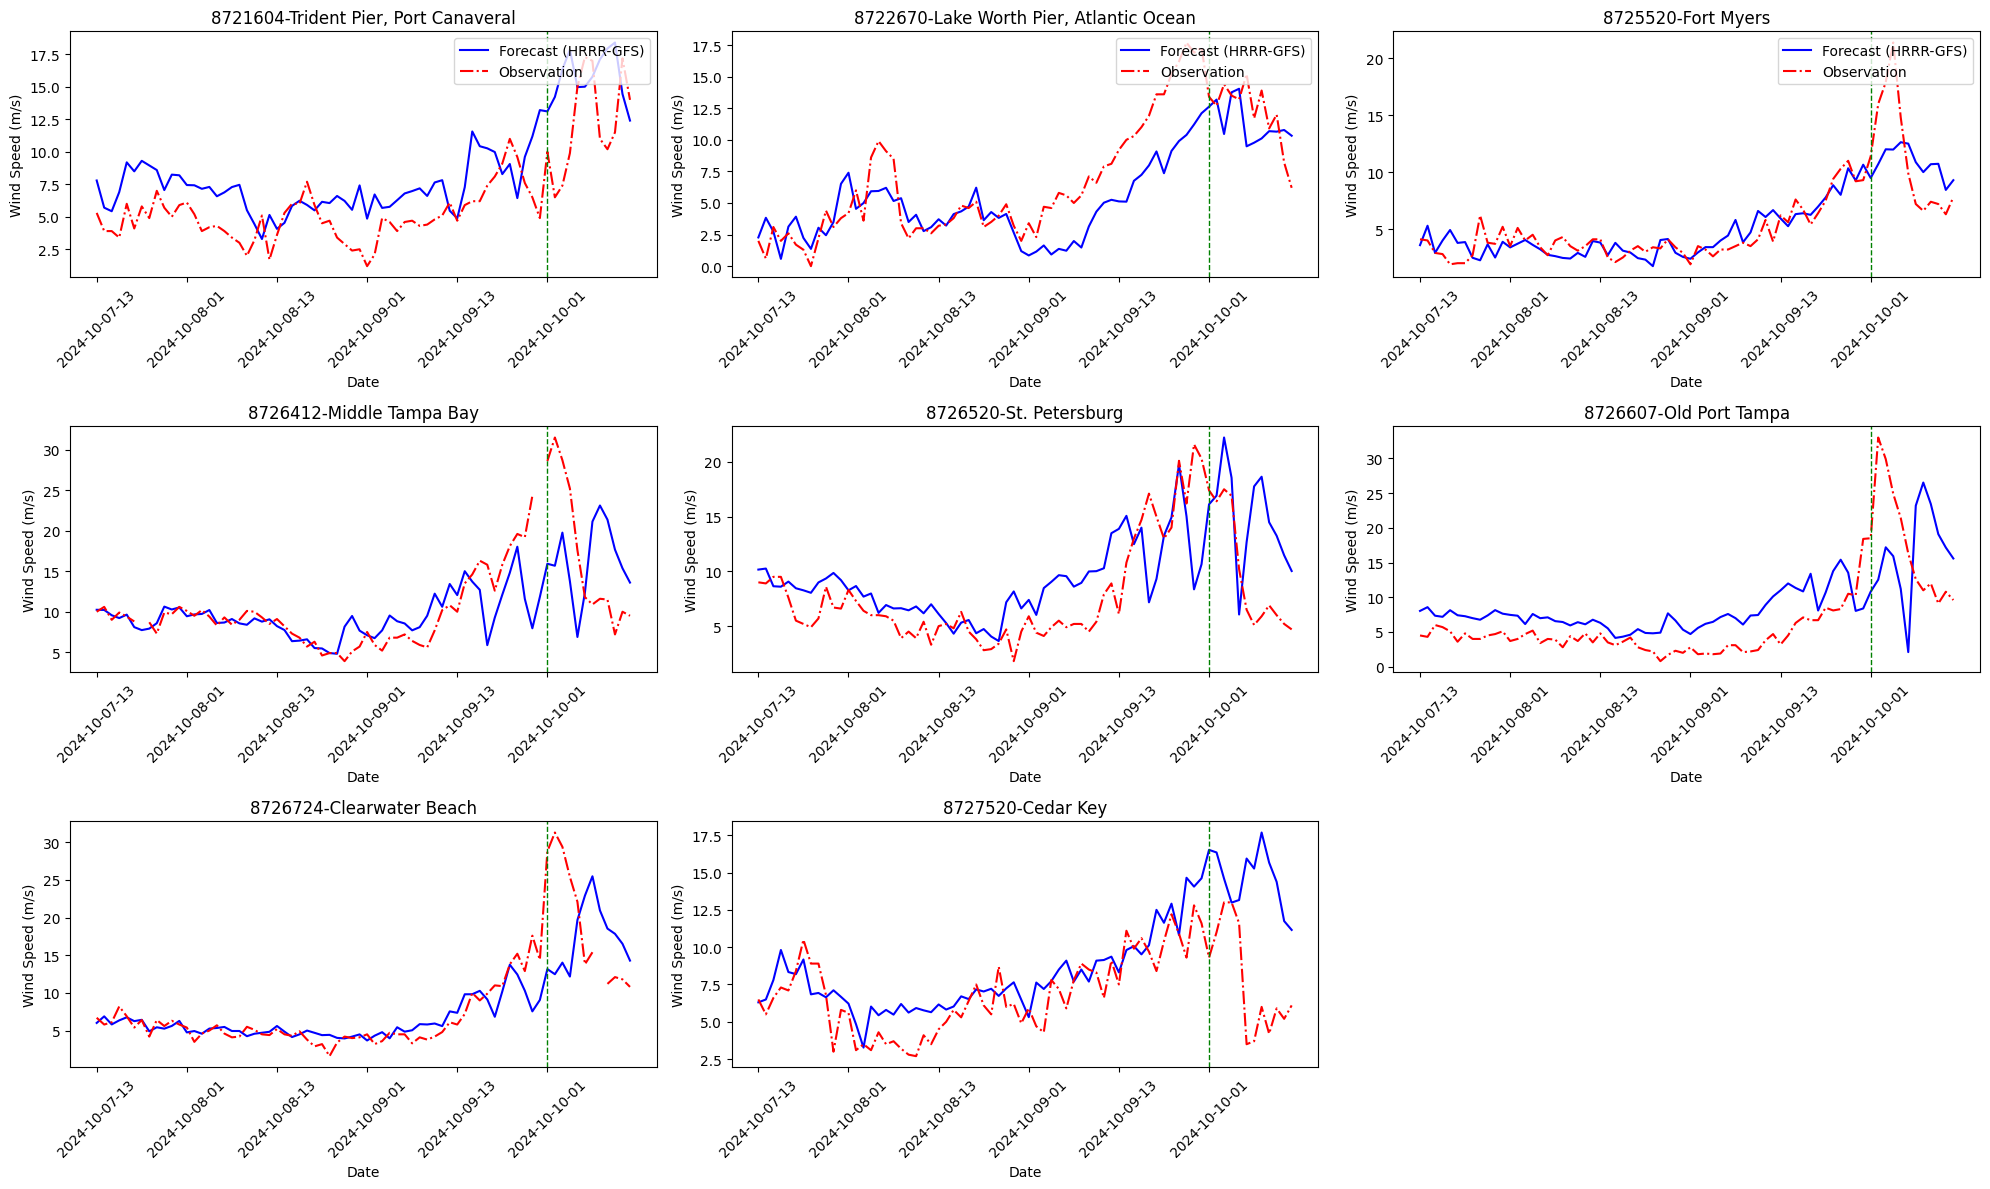

In [139]:
def convert_to_datetime(time_step):
    start_date = datetime.fromtimestamp(wind_concat_forecast['time'].values[0].astype(int) * 1e-9, tz=timezone.utc)
    time_delta = timedelta(hours=1)  
    return start_date + time_step * time_delta


# Define the number of rows and columns for subplots
num_rows = 3
num_cols = 3


# Create a figure and axes array with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 12))



index = 0
for row in range(num_rows):
    for col in range(num_cols):
        if index >= len(filtered_wind_stations['nos_id']):
            axs[row, col].axis('off')
            break
        
        nos_id = filtered_wind_stations['nos_id'][filtered_wind_stations.index[index]]
        ax = axs[row, col]
        
        ax.plot(wind_concat_forecast[:len(Wind_Observation_3d_forecast[0]),index], label='Forecast (HRRR-GFS)', color='blue')
        ax.plot(Wind_Observation_3d_forecast[index].values, label='Observation', color='red',linestyle='dashdot')


        ax.set_title(f'{filtered_wind_stations['nos_id'][filtered_wind_stations.index[index]]}-{filtered_wind_stations['name'][filtered_wind_stations.index[index]]}')
        ax.set_xlabel('Date')

        # Set x ticks and labels
        ax.set_xticks(range(0, len(Wind_Observation_3d_forecast[0]), 12)) 
        time_steps = range(0, len(Wind_Observation_3d_forecast[0]))
        time_labels = [convert_to_datetime(step) for step in time_steps]
        
        # Calculate the landfall time step
        start_date = datetime.strptime(date_range[0], '%Y%m%d')
        landfall_datetime = start_date + timedelta(hours=landfall_time_step)
 
        forecast_3d_landfall_time_step = None 

        for step, time_label in zip(time_steps, time_labels): 

            if time_label.replace(tzinfo = None) == landfall_datetime:
               forecast_3d_landfall_time_step = step 
               break 

        selected_dates = time_labels[::12]
        ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
        ax.axvline(x=forecast_3d_landfall_time_step, color='green', linestyle='--', linewidth=1)
        #ax.text(landfall_time_step*0.8, ax.get_ylim()[1]*0.85, 'Landfall Time', color='green', ha='center')
        
        ax.set_ylabel('Wind Speed (m/s)')
        if row == 0:
           ax.legend(loc='upper right')
        
        index += 1


# Adjust layout
plt.tight_layout()


# Save the figure
plt.savefig('STOFS_3D_Wind_forecast.png')

# Display the plot
plt.show()


# Add Surface Pressure plots

In [187]:
surface_pressure_dfs

8721604    8722670    8725520    8726384    8726412    8726520  \
0    101439.77  101318.17  101258.97  101343.77  101369.37  101369.37   
1    101517.95  101396.35  101349.95  101415.55  101444.35  101444.35   
2    101564.10  101448.90  101404.10  101477.70  101500.10  101500.10   
3    101559.29  101450.49  101428.09  101476.09  101500.09  101500.09   
4    101544.80  101434.40  101396.00  101453.60  101482.40  101482.40   
..         ...        ...        ...        ...        ...        ...   
163  100635.68  100651.68  100763.68  100930.08  100957.28  100957.28   
164  100709.00  100691.40  100797.00  100952.20  100979.40  100979.40   
165  100782.86  100725.26  100830.86  100990.86  101024.46  101024.46   
166  100886.84  100795.64  100898.04  101040.44  101072.44  101072.44   
167  101015.67  100921.27  101028.47  101122.87  101154.87  101154.87   

       8726524    8726607    8726671    8726674    8726679    8726694  \
0    101366.17  101366.17  101321.37  101234.97  101234.97  101321.37   
1    101436.35  101436.35  101394.75  101309.95  101309.95  101394.75   
2    101496.90  101496.90  101453.70  101367.30  101367.30  101453.70   
3    101496.89  101496.89  101456.89  101370.49  101370.49  101456.89   
4    101482.40  101482.40  101442.40  101354.40  101354.40  101442.40   
..         ...        ...        ...        ...        ...        ...   
163  100926.88  100926.88  100875.68  100773.28  100773.28  100875.68   
164  100973.00  100973.00  100929.80  100832.20  100832.20  100929.80   
165  101014.86  101014.86  100976.46  100882.06  100882.06  100976.46   
166  101070.84  101070.84  101030.84  100941.24  100941.24  101030.84   
167  101158.07  101158.07  101126.07  101039.67  101039.67  101126.07   

       8726724    8727520  
0    101321.37  101406.17  
1    101391.55  101477.95  
2    101455.30  101551.30  
3    101463.29  101597.69  
4    101436.00  101567.20  
..         ...        ...  
163  100971.68  101014.88  
164  100993.80  101048.20  
165  101019.66  101094.86  
166  101072.44  101170.04  
167  101151.67  101262.07  

[168 rows x 14 columns]

In [196]:
# Read STOFS-3d-atl surface presussure data

def read_netcdf_from_s3(bucket_name, key):
    """
    Function to read a NetCDF file from an S3 bucket using thalassa API.
    
    Parameters:
    - bucket_name: Name of the S3 bucket
    - key: Key/path to the NetCDF file in the bucket
    
    Returns:
    - ds: xarray Dataset containing the NetCDF data
    """
    s3 = s3fs.S3FileSystem(anon=True)
    url = f"s3://{bucket_name}/{key}"
    print(url)
    ds = xr.open_dataset(s3.open(url, 'rb'), drop_variables=['nvel'])
    return ds

date = date_range[0]

#base_key = f'stofs_3d_atl.{date}'
base_key = f'stofs_3d_atl.20241007'
filename = 'stofs_3d_atl.t12z.gfs.prc.nc'
         
key = f'STOFS-3D-Atl/{base_key}/rerun/{filename}'

bucket_name = 'noaa-nos-stofs3d-pds'

dataset = read_netcdf_from_s3(bucket_name, key)  # the first 24 hr (240 time steps are the now cast data)

dataset


s3://noaa-nos-stofs3d-pds/STOFS-3D-Atl/stofs_3d_atl.20241007/rerun/stofs_3d_atl.t12z.gfs.prc.nc


<xarray.Dataset> Size: 133MB
Dimensions:    (time: 124, latitude: 181, longitude: 185)
Coordinates:
  * time       (time) datetime64[ns] 992B 2024-10-06T11:59:59.912452697 ... 2...
  * latitude   (latitude) float64 1kB 7.5 7.75 8.0 8.25 ... 52.0 52.25 52.5
  * longitude  (longitude) float64 1kB -98.5 -98.25 -98.0 ... -53.0 -52.75 -52.5
Data variables:
    tin        int32 4B ...
    dlwrf      (time, latitude, longitude) float32 17MB ...
    dswrf      (time, latitude, longitude) float32 17MB ...
    lat        (latitude, longitude) float32 134kB ...
    lon        (latitude, longitude) float32 134kB ...
    prate      (time, latitude, longitude) float32 17MB ...
    prmsl      (time, latitude, longitude) float32 17MB ...
    spfh       (time, latitude, longitude) float32 17MB ...
    stmp       (time, latitude, longitude) float32 17MB ...
    uwind      (time, latitude, longitude) float32 17MB ...
    vwind      (time, latitude, longitude) float32 17MB ...
Attributes:
    Conventions:          COARDS
    History:              Mon Oct  7 16:02:52 2024: ncap2 -s time(0)=float(0....
    GRIB2_grid_template:  0
    NCO:                  netCDF Operators version 4.9.7 (Homepage = http://n...

In [ ]:

def  get_indices_of_nearest_nodes(ds: xr.Dataset, x: float, y: float, num_nodes: int ) -> List[int]:
    # https://www.unidata.ucar.edu/blogs/developer/en/entry/accessing_netcdf_data_by_coordinates
    # https://github.com/Unidata/python-workshop/blob/fall-2016/notebooks/netcdf-by-coordinates.ipynb
    dist = abs(ds.x - x) ** 2 + abs(ds.y - y) ** 2
    indices_of_nearest_nodes = dist.argsort()[:num_nodes]
    return indices_of_nearest_nodes.values

# Initialize an empty DataFrame to store the data
index = pd.DataFrame()

# Initialize an empty DataFrame to store the data
data = []

for nos_id, x, y in zip(filtered_wind_stations['nos_id'], filtered_wind_stations['lon'], filtered_wind_stations['lat']):
    index_values = get_indices_of_nearest_nodes(dataset, x, y,1)
    data.append({'nos_id': nos_id , 'index_value': index_values})

# Convert the list of dictionaries to a DataFrame
index = pd.DataFrame(data)
index_list = []

for i in range(0,len(index)):
  index_list.append(int(index.index_value[i][0]))


In [ ]:
https://noaa-nos-stofs3d-pds.s3.amazonaws.com/STOFS-3D-Atl/stofs_3d_atl.20241011/rerun/stofs_3d_atl.t12z.hrrr.prc.nc

In [ ]:
https://noaa-nos-stofs3d-pds.s3.amazonaws.com/STOFS-3D-Atl/stofs_3d_atl.20241011/rerun/stofs_3d_atl.t12z.gfs.prc.nc

In [ ]:
surface_pressure_dfs_forecast